In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_days', help="How many days to the future from 1.1.2023 to predict.", type=int, default=365)
parser.add_argument('--predict_months', help="How many months to the future from 1.1.2023 to predict.", type=int, default=12)

args = parser.parse_args()

days_to_predict = int(args.predict_days)
months_to_predict = int(args.predict_months)

In [3]:
# concat data from multiple CSVs to a single dataframe
df_list = []
filepaths = ['./data-nehody/data_GIS_12-' + str(y) for y in range(2016, 2023)]
for path in filepaths:
    csv_files = glob.glob(path + "/*.csv")
    dfs_in_file = [pd.read_csv(file, sep=";", encoding='ANSI', header=None, low_memory=False) for file in csv_files]
    df_list.append(pd.concat(dfs_in_file, axis=0, ignore_index=True))

accidents_df = pd.concat(df_list, axis=0, ignore_index=True)
accidents_df['date'] = pd.to_datetime(accidents_df[3])
accidents_df['weekday'] = accidents_df[4]
accidents_df = accidents_df[['date', 'weekday']]

In [4]:
accidents_df.head(5)

date  weekday
0 2016-01-01        5
1 2016-01-01        5
2 2016-01-01        5
3 2016-01-01        5
4 2016-01-01        5

Text(0, 0.5, 'number of accidents')

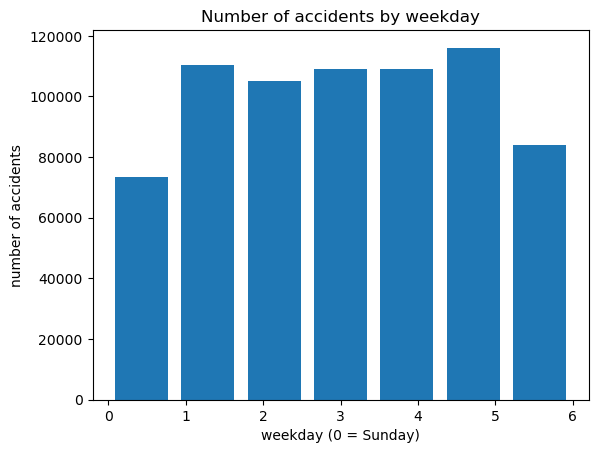

In [5]:
# during the weekend, i.e. saturday (6) and sunday (0), less accidents. 
plt.hist(accidents_df['weekday'], bins=7, rwidth=0.8)
plt.title("Number of accidents by weekday")
plt.xlabel("weekday (0 = Sunday)")
plt.ylabel("number of accidents")

In [168]:
# count number of accidents for each day/month/year
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
monthly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count())
yearly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('Y'))['date'].count())

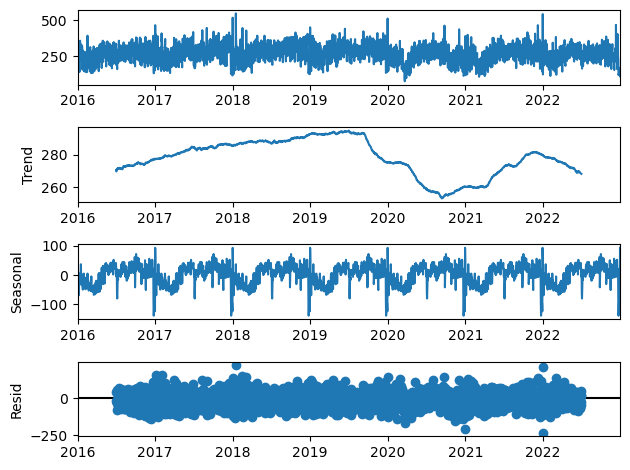

In [7]:
# seasonal decomposition
decomposed = seasonal_decompose(daily_count, period=365).plot()

Text(0, 0.5, 'number of accidents')

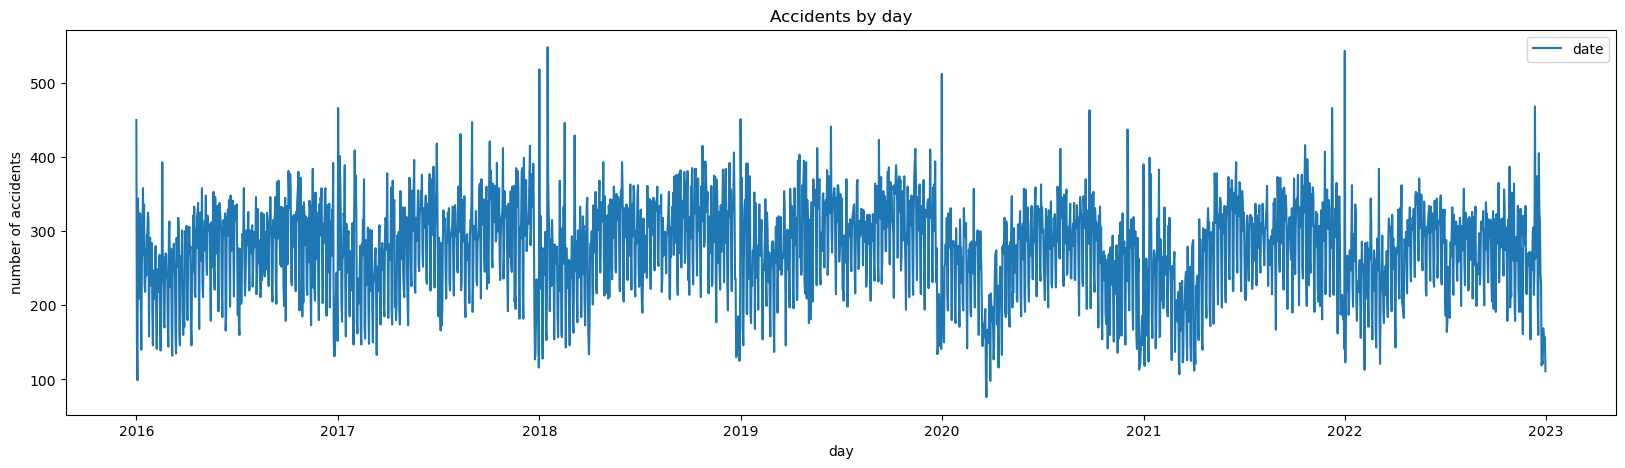

In [8]:
# plot number of accidents on each day
plt.rcParams['figure.figsize'] = [20, 5]
daily_count.plot()
plt.title("Accidents by day")
plt.xlabel("day")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

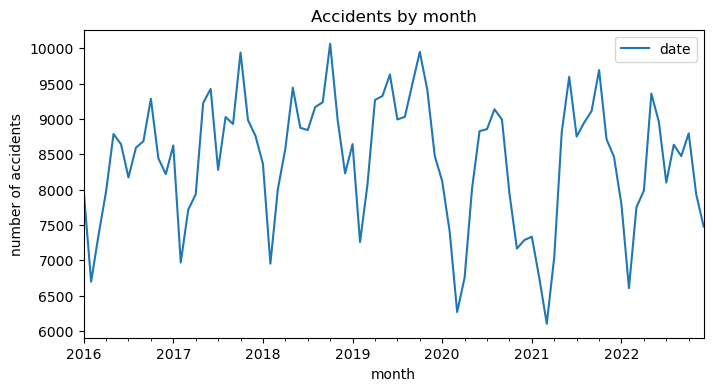

In [9]:
# plot number of accidents in each month
plt.rcParams['figure.figsize'] = [8, 4]
monthly_count.plot()
plt.title("Accidents by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

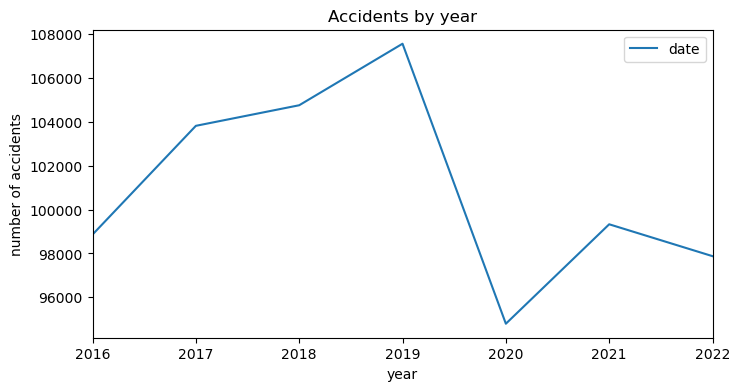

In [10]:
# plot number of accidents in each year
yearly_count.plot()
plt.title("Accidents by year")
plt.xlabel("year")
plt.ylabel("number of accidents")

In [11]:
# split the data to training set and test set

column_names = ['ds', 'y']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
monthly_count_train = monthly_count[:len(monthly_count) - months_to_predict].rename(columns={'date': 'y'}).reset_index()
monthly_count_train.columns = column_names
monthly_count_train['ds'] = monthly_count_train['ds'].dt.to_timestamp()
monthly_count_test = monthly_count[len(monthly_count) - months_to_predict:].rename(columns={'date': 'y'}).reset_index()
monthly_count_test.columns = column_names
monthly_count_test['ds'] = monthly_count_test['ds'].dt.to_timestamp()

print(monthly_count_train)
print(monthly_count_test)

# split also daily data in the same way
daily_count_train = daily_count[:len(daily_count) - days_to_predict].rename(columns={'date': 'y'}).reset_index()
daily_count_train.columns = column_names
daily_count_test = daily_count[len(daily_count) - days_to_predict:].rename(columns={'date': 'y'}).reset_index()
daily_count_test.columns = column_names

print(daily_count_train)
print(daily_count_test)

           ds     y
0  2016-01-01  7992
1  2016-02-01  6698
2  2016-03-01  7362
3  2016-04-01  7974
4  2016-05-01  8788
..        ...   ...
67 2021-08-01  8949
68 2021-09-01  9114
69 2021-10-01  9693
70 2021-11-01  8715
71 2021-12-01  8464

[72 rows x 2 columns]
           ds     y
0  2022-01-01  7786
1  2022-02-01  6607
2  2022-03-01  7750
3  2022-04-01  7987
4  2022-05-01  9359
5  2022-06-01  8962
6  2022-07-01  8101
7  2022-08-01  8636
8  2022-09-01  8476
9  2022-10-01  8798
10 2022-11-01  7936
11 2022-12-01  7479
              ds    y
0     2016-01-01  450
1     2016-01-02  148
2     2016-01-03   99
3     2016-01-04  344
4     2016-01-05  271
...          ...  ...
2187  2021-12-27  214
2188  2021-12-28  199
2189  2021-12-29  181
2190  2021-12-30  198
2191  2021-12-31  141

[2192 rows x 2 columns]
             ds    y
0    2022-01-01  543
1    2022-01-02  123
2    2022-01-03  234
3    2022-01-04  246
4    2022-01-05  219
..          ...  ...
360  2022-12-27  169
361  2022-12-28  157

In [169]:
daily_count = pd.concat([daily_count_train, daily_count_test[len(daily_count_test) - days_to_predict:]])
monthly_count = pd.concat([monthly_count_train, monthly_count_test[len(monthly_count_test) - months_to_predict:]])
print(daily_count)
print(monthly_count)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
..          ...  ...
360  2022-12-27  169
361  2022-12-28  157
362  2022-12-29  151
363  2022-12-30  157
364  2022-12-31  111

[2557 rows x 2 columns]
           ds     y
0  2016-01-01  7992
1  2016-02-01  6698
2  2016-03-01  7362
3  2016-04-01  7974
4  2016-05-01  8788
..        ...   ...
7  2022-08-01  8636
8  2022-09-01  8476
9  2022-10-01  8798
10 2022-11-01  7936
11 2022-12-01  7479

[84 rows x 2 columns]


In [13]:
# create a monthly dataframe that will contain forecasts from all applied algorithms
monthly_predict_df = pd.DataFrame(monthly_count['ds'])

# add new dates to the monthly_predict_df in the length of months from the arguments
last_date = monthly_predict_df['ds'].max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

monthly_predict_df = pd.concat([monthly_predict_df, new_rows])

monthly_predict_df['original'] = list(monthly_count_train['y']) + list(monthly_count_test['y']) + [None] * months_to_predict
monthly_predict_df.set_index('ds', inplace=True)

monthly_predict_df

original
ds                  
2016-01-01    7992.0
2016-02-01    6698.0
2016-03-01    7362.0
2016-04-01    7974.0
2016-05-01    8788.0
...              ...
2023-08-01       NaN
2023-09-01       NaN
2023-10-01       NaN
2023-11-01       NaN
2023-12-01       NaN

[96 rows x 1 columns]

In [14]:
# create a daily dataframe that will contain forecasts from all applied algorithms
daily_predict_df = pd.DataFrame(daily_count['ds'])

# add new dates to the daily_predict_df in the length of days from the arguments
last_date = daily_predict_df['ds'].max()
future_dates = pd.date_range(start=last_date, periods=days_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

daily_predict_df = pd.concat([daily_predict_df, new_rows])

daily_predict_df['original'] = list(daily_count_train['y']) + list(daily_count_test['y']) + [None] * days_to_predict
daily_predict_df.set_index('ds', inplace=True)

daily_predict_df

original
ds                           
2016-01-01              450.0
2016-01-02              148.0
2016-01-03               99.0
2016-01-04              344.0
2016-01-05              271.0
...                       ...
2023-12-27 00:00:00       NaN
2023-12-28 00:00:00       NaN
2023-12-29 00:00:00       NaN
2023-12-30 00:00:00       NaN
2023-12-31 00:00:00       NaN

[2922 rows x 1 columns]

In [15]:
# Prophet - daily
m = Prophet()  # create new object for daily forecast
m.fit(daily_count_train)  # fit the training data
future = m.make_future_dataframe(periods=365 + days_to_predict)  # set length of forecast

22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecast = m.predict(future)  # predict the number of observations that was set in the previous step

Text(83.09722222222221, 0.5, 'number of accidents')

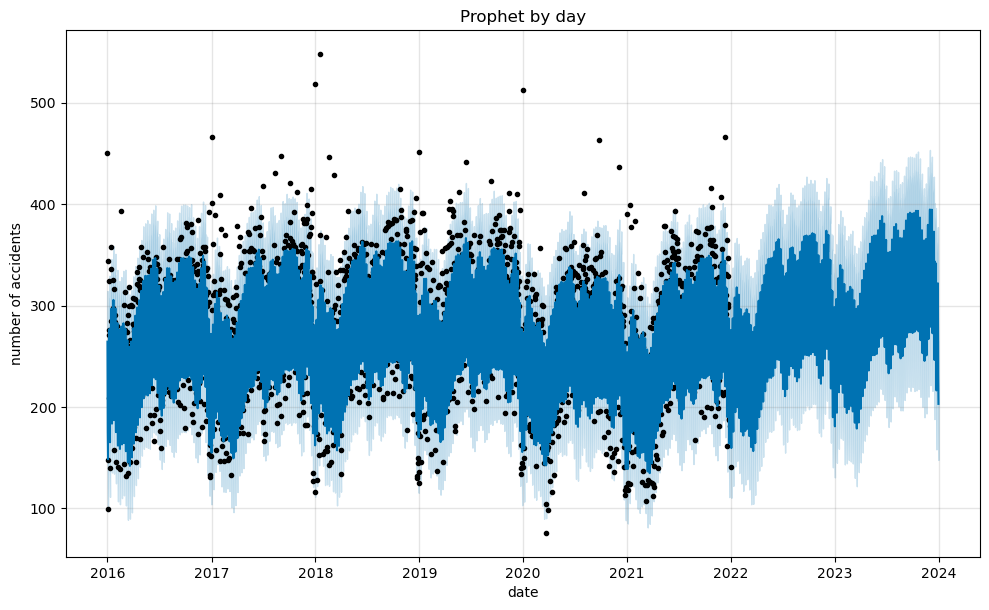

In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

fig1 = m.plot(forecast)  # plot the forecast
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

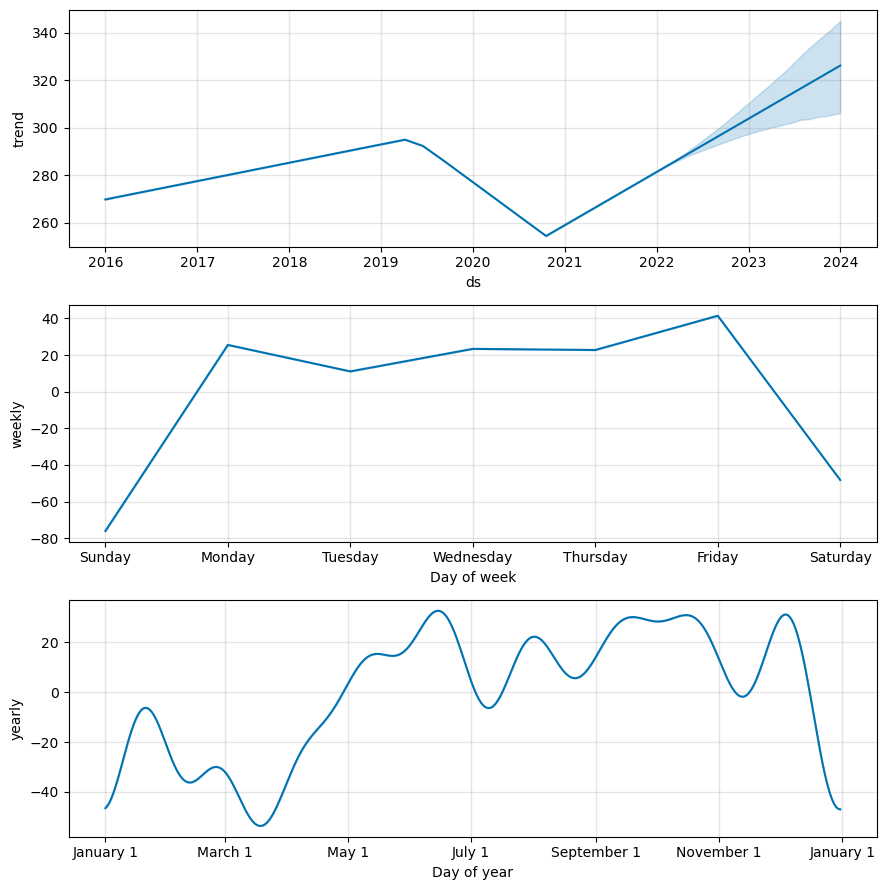

In [18]:
fig2 = m.plot_components(forecast)

C:\Users\katka\AppData\Local\Temp\ipykernel_3976\1752053067.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  daily_predict_df[['original', 'Prophet']].plot()


Text(0, 0.5, 'number of accidents')

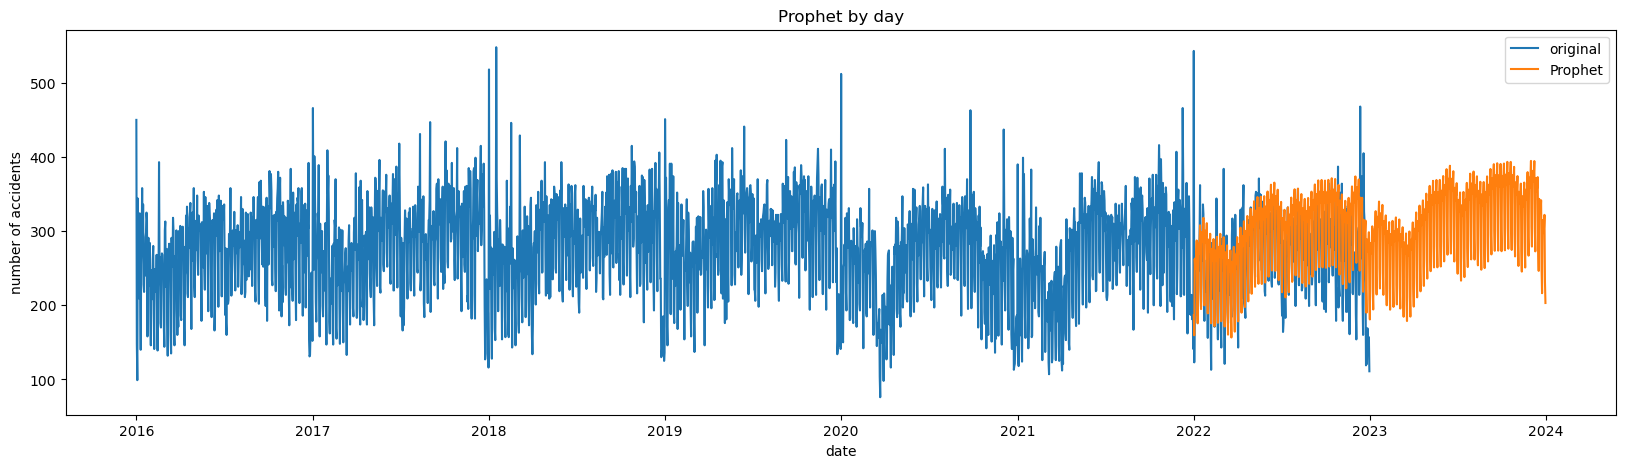

In [19]:
daily_predict_df['Prophet'] = [None]*len(daily_count_train) + list(forecast['yhat'].tail(365 + days_to_predict))  # add results to daily_predict_df

plt.rcParams['figure.figsize'] = [20, 5]  # adjust size of plot
daily_predict_df[['original', 'Prophet']].plot()
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [20]:
# Prophet - monthly

m = Prophet()  # create new object for monthly forecast
m.fit(monthly_count_train)  # fit the training data
future = m.make_future_dataframe(periods=12 + months_to_predict, freq='MS')  # set length of forecast
forecast = m.predict(future)  # predict for the number of observations set in the previous step

22:52:45 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet by month')

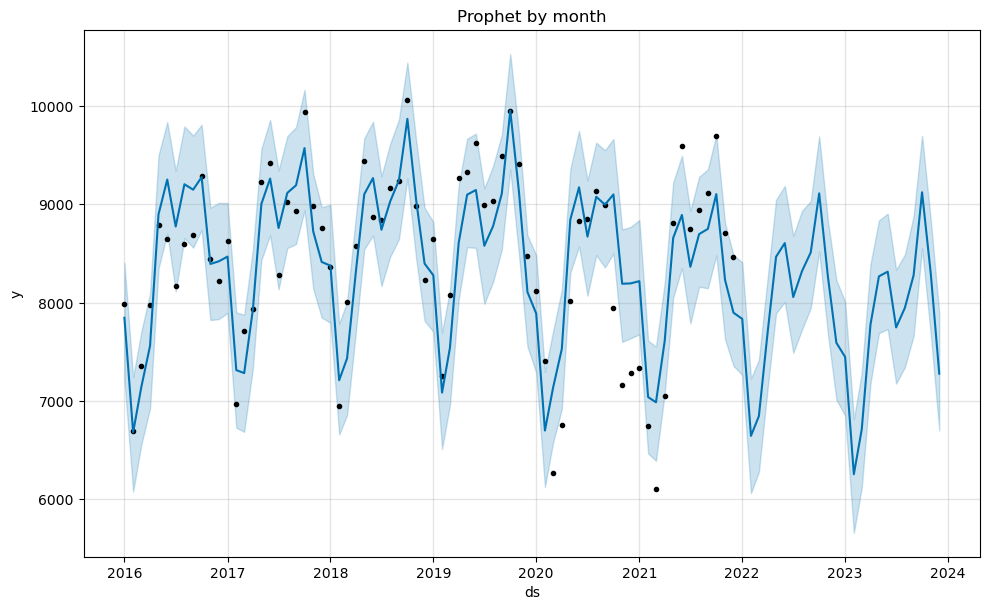

In [21]:
fig1 = m.plot(forecast)  # plot the monthly forecast
plt.title("Prophet by month")

Text(0, 0.5, 'number of accidents')

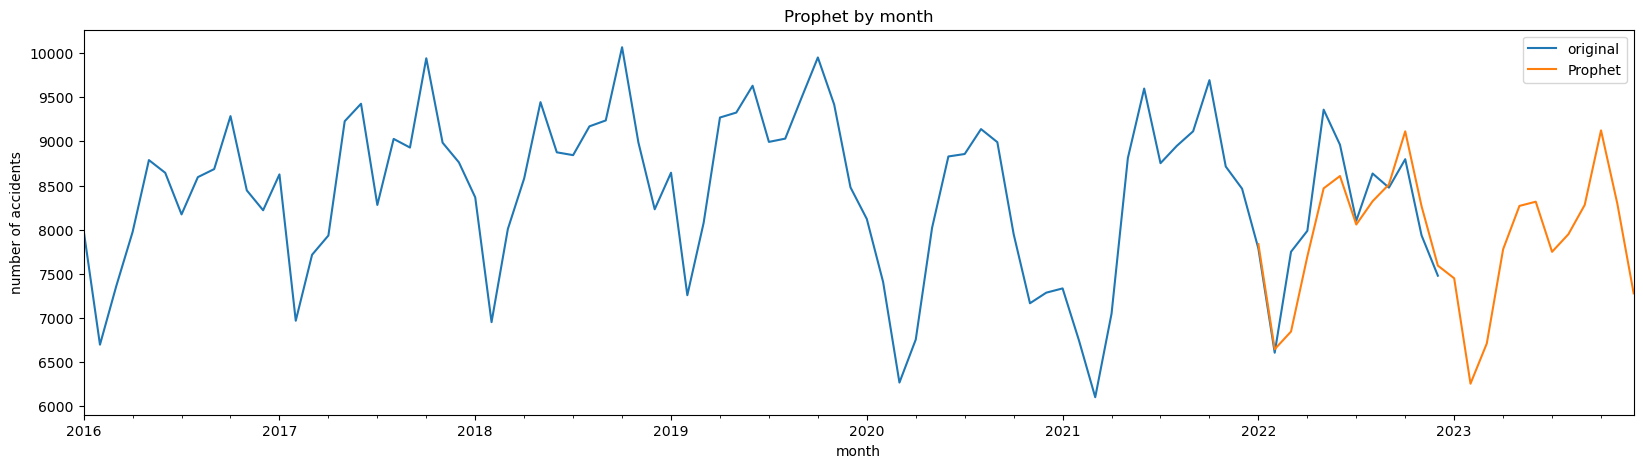

In [22]:
monthly_predict_df['Prophet'] = [None]*len(monthly_count_train) + list(forecast['yhat'].tail(months_to_predict + 12))  # add the forecast to monthly_predict_df

monthly_predict_df[['original', 'Prophet']].plot()
plt.title("Prophet by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [23]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(monthly_count_train['ds'].values.reshape(-1, 1), monthly_count_train['y'].values)  # fit the training data

print("Best parameters: ", grid_search.best_params_)  # print the most optimal hyperparameter values
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score:  -0.27046021919169255


In [24]:
# SVR - monthly
model = SVR(kernel='sigmoid', gamma='scale', C=0.1, epsilon=0.01)  # create model with values from the GridSearchCV
model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)  # fit the training data

y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

y_pred

array([8665.08881798, 8665.14638761, 8665.20215476, 8665.2546307 ,
       8665.30283094, 8665.34629635, 8665.38498619, 8665.41912341,
       8665.44905691, 8665.47516897, 8665.49782677, 8665.51736445])

Text(0, 0.5, 'number of accidents')

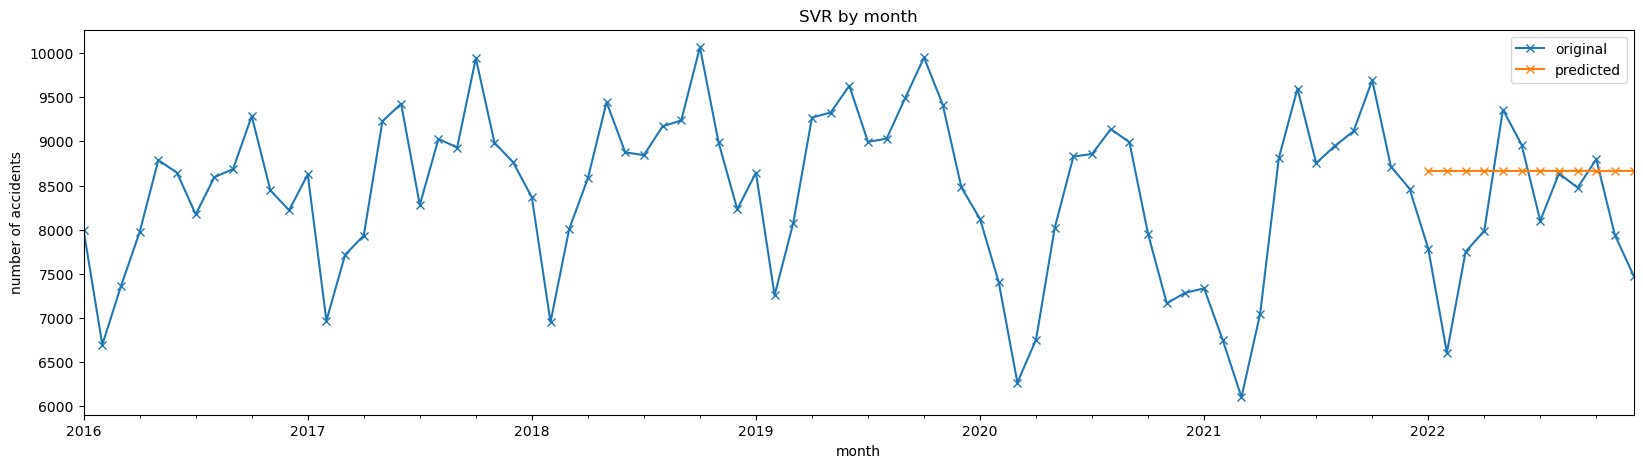

In [25]:
# plot the whole dataset + add predicted values for 2022
predict_df = pd.DataFrame(monthly_count)
predict_df['forecast_value'] = [None]*len(monthly_count_train) + list(y_pred)

predict_df.set_index('ds', inplace=True)
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [26]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score:  -0.06738035160774655


In [27]:
# SVR - daily
model = SVR(kernel='sigmoid', gamma='scale', C=0.1, epsilon=0.1)  # create model with values from the GridSearchCV
model.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)  # fit the training data

y_pred = model.predict(daily_count_test.index.values.reshape(-1, 1))

y_pred

array([281.60313903, 281.59868663, 281.5942348 , 281.58978408,
       281.58533503, 281.58088822, 281.5764442 , 281.57200353,
       281.56756676, 281.56313446, 281.55870718, 281.55428548,
       281.54986991, 281.54546102, 281.54105938, 281.53666553,
       281.53228002, 281.52790342, 281.52353626, 281.51917911,
       281.5148325 , 281.51049699, 281.50617313, 281.50186145,
       281.49756251, 281.49327685, 281.489005  , 281.48474752,
       281.48050493, 281.47627778, 281.4720666 , 281.46787193,
       281.4636943 , 281.45953424, 281.45539228, 281.45126894,
       281.44716475, 281.44308024, 281.43901593, 281.43497233,
       281.43094997, 281.42694935, 281.42297099, 281.4190154 ,
       281.41508308, 281.41117456, 281.40729031, 281.40343085,
       281.39959668, 281.39578829, 281.39200616, 281.3882508 ,
       281.38452268, 281.3808223 , 281.37715012, 281.37350663,
       281.36989231, 281.36630762, 281.36275303, 281.35922901,
       281.35573602, 281.35227452, 281.34884495, 281.34

Text(0, 0.5, 'number of accidents')

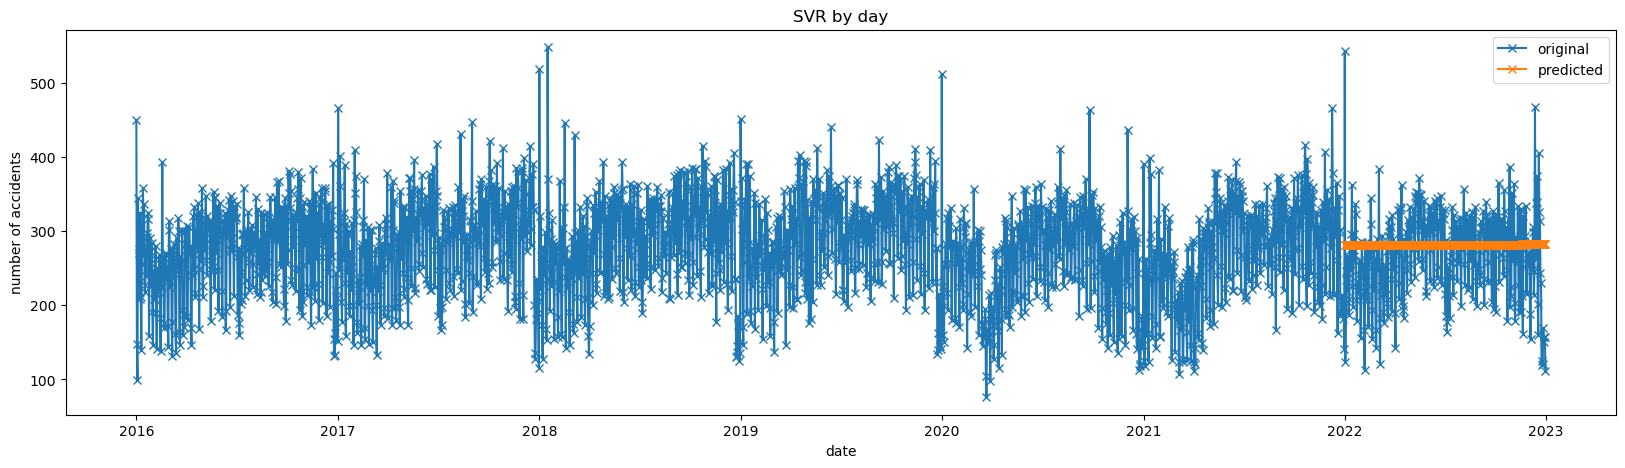

In [28]:
# plot the whole dataset + add predicted values for 2022
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
predict_df = pd.DataFrame(daily_count)
predict_df['forecast_value'] = [None]*len(daily_count_train) + list(y_pred)

plt.rcParams['figure.figsize'] = [20, 5]
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [29]:
# # scaling the data for SVR
# window_size = 3

# # Compute rolling mean and standard deviation
# rolling_mean = monthly_count_train['y'].rolling(window=window_size).mean()
# rolling_std = monthly_count_train['y'].rolling(window=window_size).std()

# # Apply scaling transformation to each time step
# scaled_data = (monthly_count_train['y'] - rolling_mean) / rolling_std

# scaled_data

# monthly_count_train['y'] = scaled_data


In [30]:
# monthly_count_train = monthly_count_train.iloc[2:]
# monthly_count_train

In [31]:
# #find optimal hyperparameters susing grid search for scaled data
# param_grid = {
#     'kernel': ['rbf', 'sigmoid'],
#     'C': [0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 1],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

# cv = TimeSeriesSplit(n_splits=5)

# svr = SVR()

# grid_search = GridSearchCV(svr, param_grid, cv=cv)
# grid_search.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [32]:
# # SVR - monhtly with scaled data
# model = SVR(kernel='rbf',gamma='auto', C=1, epsilon=1)
# model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

# y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

# y_pred

In [33]:
from scalecast.Forecaster import Forecaster

In [34]:
# create a Forecaster object that will make forecasts from multiple models with daily granularity
f_daily = Forecaster(
    y=np.array(daily_count['original']),
    current_dates=np.array(daily_count.index)
)
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [35]:
f_daily.set_test_length(365)  # reserve last 365 observations (a year) as a test set
f_daily.generate_future_dates(days_to_predict)  # predict specified number of days into the future
f_daily.set_validation_length(f_daily.test_length)
f_daily.auto_Xvar_select()
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [36]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for method in forecaster_estimators:
    f_daily.set_estimator(method)
    f_daily.tune()  # find optimal hyperparameters for selected method
    f_daily.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_daily.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 12)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 3, 'subsample': 0.9}
Hyperparameter values for catboost:
{'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 3, 'verbose': 0}
67/67 [==============================] - 2s 32ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
69/69 [==============================] - 1s 9ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'relu', 'dropout': (0.2, 0.2, 0.2), 'lags': 10, 'verbose': 0, 'epochs': 50}


Text(0, 0.5, 'number of accidents')

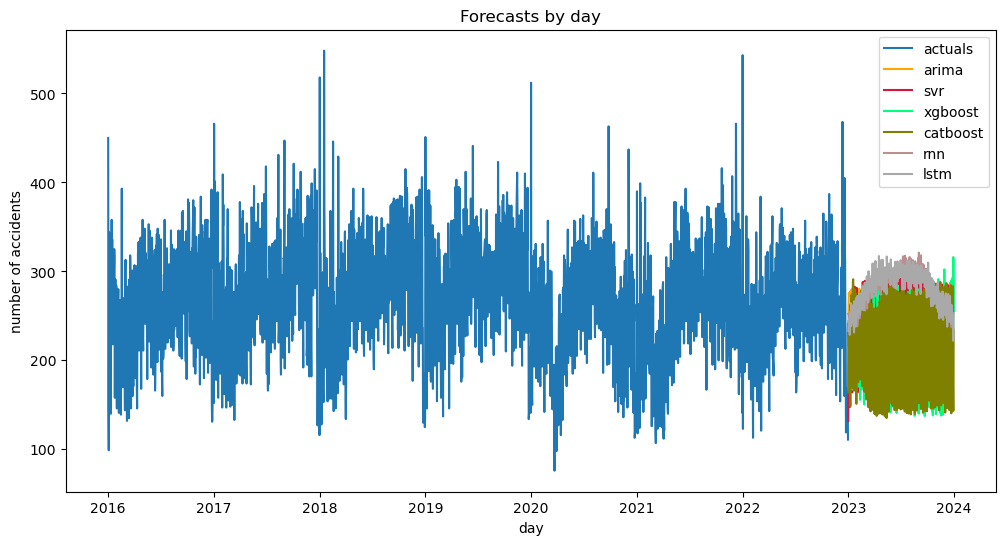

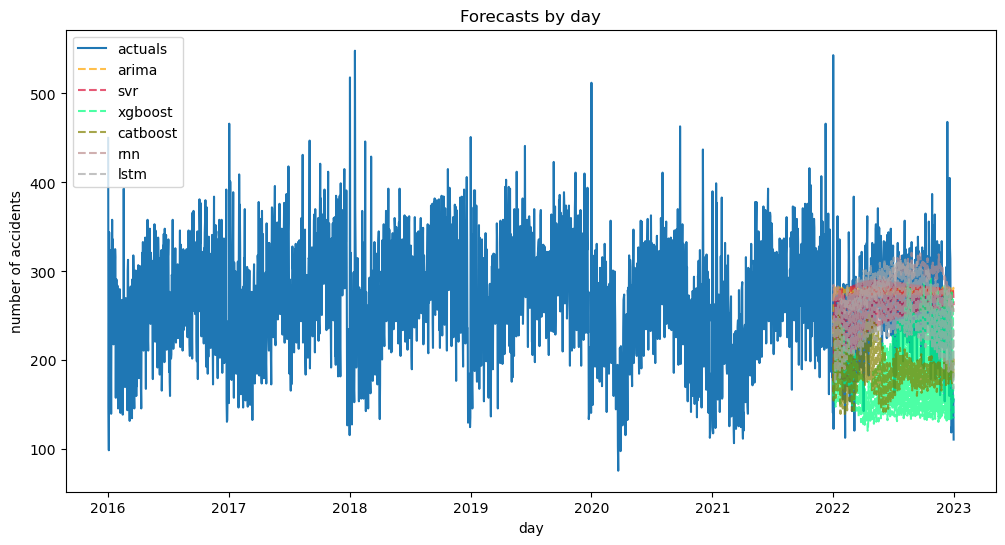

In [37]:
f_daily.plot()  # plots future values
plt.title("Forecasts by day")
plt.xlabel("day")
plt.ylabel("number of accidents")
f_daily.plot_test_set()  # plots values from test set
plt.title("Forecasts by day")
plt.xlabel("day")
plt.ylabel("number of accidents")

In [38]:
# add forecasts from models in Forecaster to daily_predict_df
for method in forecaster_estimators:
    result = f_daily.export_fitted_vals(method)
    daily_predict_df[method] = [None] * len(daily_count_train) + list(result.tail(days_to_predict + 365)['FittedVals'])
daily_predict_df

original     Prophet       arima         svr     xgboost  \
ds                                                                              
2016-01-01              450.0         NaN         NaN         NaN         NaN   
2016-01-02              148.0         NaN         NaN         NaN         NaN   
2016-01-03               99.0         NaN         NaN         NaN         NaN   
2016-01-04              344.0         NaN         NaN         NaN         NaN   
2016-01-05              271.0         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         ...         ...   
2023-12-27 00:00:00       NaN  307.217432  225.791637  250.074637  172.927856   
2023-12-28 00:00:00       NaN  304.655051  242.064947  237.898649  155.386093   
2023-12-29 00:00:00       NaN  321.938731  234.417980  221.441723  147.735184   
2023-12-30 00:00:00       NaN  231.287019  238.109504  237.873521  153.593399   
2023-12-31 00:00:00       NaN  203.053664  237.921081  142.904538  111.033821   

                       catboost         rnn        lstm  
ds                                                       
2016-01-01                  NaN         NaN         NaN  
2016-01-02                  NaN         NaN         NaN  
2016-01-03                  NaN         NaN         NaN  
2016-01-04                  NaN         NaN         NaN  
2016-01-05                  NaN         NaN         NaN  
...                         ...         ...         ...  
2023-12-27 00:00:00  160.319163  264.638362  245.675612  
2023-12-28 00:00:00  158.826733  261.406229  253.532931  
2023-12-29 00:00:00  153.413006  258.282565  231.865689  
2023-12-30 00:00:00  157.342574  256.897896  210.656150  
2023-12-31 00:00:00  108.698764  257.379145  247.638718  

[2922 rows x 8 columns]

In [39]:
# create a Forecaster object that will make forecasts from multiple models with monthly granularity
f_monthly = Forecaster(
    y=np.array(monthly_count.reset_index()['y']),
    current_dates=np.array(monthly_count.reset_index()['ds'])
)
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [40]:
f_monthly.set_test_length(12)  # reserve last 12 observations (a year) as a test set
f_monthly.generate_future_dates(months_to_predict)  # predict 12 months into the future
f_monthly.set_validation_length(f_monthly.test_length)
f_monthly.auto_Xvar_select()
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=12
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos']
    TestLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [41]:
for method in forecaster_estimators:
    f_monthly.set_estimator(method)
    f_monthly.tune()  # find optimal hyperparameters for selected method
    f_monthly.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_monthly.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}
Hyperparameter values for svr:
{'kernel': 'poly', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}
Hyperparameter values for catboost:
{'iterations': 100, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'verbose': 0}
3/3 [==============================] - 0s 7ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
2/2 [==============================] - 0s 12ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'relu', 'dropout': (0.2, 0.2, 0.2), 'l

Text(0, 0.5, 'number of accidents')

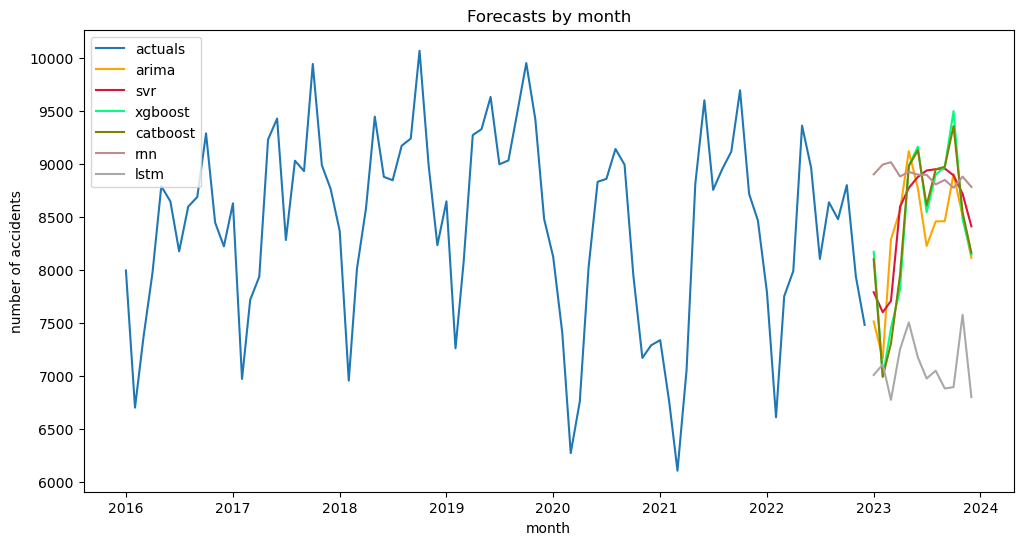

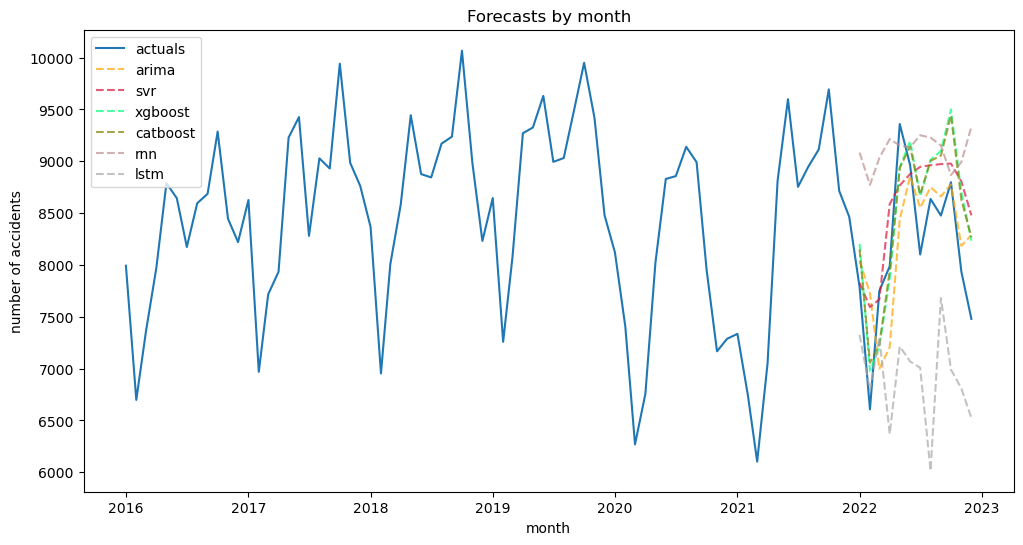

In [42]:
f_monthly.plot()  # plots future values
plt.title("Forecasts by month")
plt.xlabel("month")
plt.ylabel("number of accidents")
f_monthly.plot_test_set()  # plots values from test set
plt.title("Forecasts by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [43]:
# add forecasts from models in Forecaster to monthly_predict_df
for method in forecaster_estimators:
    result = f_monthly.export_fitted_vals(method)
    monthly_predict_df[method] = [None] * len(monthly_count_train) + list(result.tail(months_to_predict + 12)['FittedVals'])
monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  
ds                                                 
2016-01-01          NaN          NaN          NaN  
2016-02-01          NaN          NaN          NaN  
2016-03-01          NaN          NaN          NaN  
2016-04-01          NaN          NaN          NaN  
2016-05-01          NaN          NaN          NaN  
...                 ...          ...          ...  
2023-08-01  8947.191384  8804.869261  7182.074724  
2023-09-01  8971.107381  8846.700258  6998.830085  
2023-10-01  9354.696706  8773.192361  7004.902772  
2023-11-01  8539.760655  8877.902841  7798.322385  
2023-12-01  8159.440253  8781.154164  6892.858521  

[96 rows x 8 columns]

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [45]:
# split datetime to day, month, and year parts for models with GA
monthly_count_ga = monthly_count
monthly_count_ga['day'] = monthly_count['ds'].dt.day
monthly_count_ga['month'] = monthly_count['ds'].dt.month
monthly_count_ga['year'] = monthly_count['ds'].dt.year
monthly_count_ga

ds     y  forecast_value  day  month  year
0  2016-01-01  7992             NaN    1      1  2016
1  2016-02-01  6698             NaN    1      2  2016
2  2016-03-01  7362             NaN    1      3  2016
3  2016-04-01  7974             NaN    1      4  2016
4  2016-05-01  8788             NaN    1      5  2016
..        ...   ...             ...  ...    ...   ...
7  2022-08-01  8636     8665.419123    1      8  2022
8  2022-09-01  8476     8665.449057    1      9  2022
9  2022-10-01  8798     8665.475169    1     10  2022
10 2022-11-01  7936     8665.497827    1     11  2022
11 2022-12-01  7479     8665.517364    1     12  2022

[84 rows x 6 columns]

In [46]:
# split data to training and testing sets
X = monthly_count_ga[['day', 'month', 'year']]
y = monthly_count_ga['y']
X_train_ga = X[:len(X) - months_to_predict]
X_test_ga = X[len(X) - months_to_predict:]
y_train_ga = y[:len(y) - months_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - months_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((72, 3), (12, 3), (72,), (12,))

In [47]:
rf = RandomForestRegressor(random_state=111)

In [48]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [49]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [50]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [51]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	100   	0.0162747	0.130948   	0.218462   	-0.297804  
1  	200   	0.107913 	0.0715253  	0.218462   	-0.0851471 
2  	200   	0.150483 	0.0497298  	0.218462   	-0.0038515 
3  	200   	0.175719 	0.024725   	0.218462   	0.0342482  
4  	200   	0.186287 	0.0178553  	0.218462   	0.102959   
5  	200   	0.195102 	0.0124614  	0.218462   	0.175829   
6  	200   	0.201961 	0.0132544  	0.218462   	0.178154   
7  	200   	0.210016 	0.0149436  	0.218462   	0.101339   
8  	200   	0.216093 	0.00634985 	0.218462   	0.189401   
9  	200   	0.218137 	0.00227472 	0.218462   	0.202214   
10 	200   	0.218462 	0          	0.218462   	0.218462   
11 	200   	0.218462 	0          	0.218462   	0.218462   
12 	200   	0.218462 	0          	0.218462   	0.218462   


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000002A560F2AD90>,
           error_score='raise',
           estimator=RandomForestRegressor(bootstrap=False,
                                           criterion='absolute_error',
                                           max_depth=10, max_features='auto',
                                           min_samples_split=0.33744798665480086,
                                           n_estimators=344, random_state=111),
           generations=12,
           mutation_probabil...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x000002A560AA75B0>,
                       'max_features': <sklearn_genetic.space.space.Categorical object at 0x000002A560AA7100>,
                       'min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000002A560AA7D00>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x000002A560AA7B80>},
           population_size=100, return_train_score=True, scoring='r2')

In [52]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = monthly_count_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
X_test_ga = pd.concat([X_test_ga, new_rows])

In [53]:
X_test_ga = X_test_ga[['day', 'month', 'year']]
X_test_ga

day  month  year
0     1      1  2022
1     1      2  2022
2     1      3  2022
3     1      4  2022
4     1      5  2022
5     1      6  2022
6     1      7  2022
7     1      8  2022
8     1      9  2022
9     1     10  2022
10    1     11  2022
11    1     12  2022
1     1      1  2023
2     1      2  2023
3     1      3  2023
4     1      4  2023
5     1      5  2023
6     1      6  2023
7     1      7  2023
8     1      8  2023
9     1      9  2023
10    1     10  2023
11    1     11  2023
12    1     12  2023

In [54]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [55]:
y_predict_rf_ga

array([7561.5, 7561.5, 7561.5, 7561.5, 8843. , 8843. , 8843. , 8843. ,
       8843. , 8843. , 8843. , 8347.5, 7561.5, 7561.5, 7561.5, 7561.5,
       8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8347.5])

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

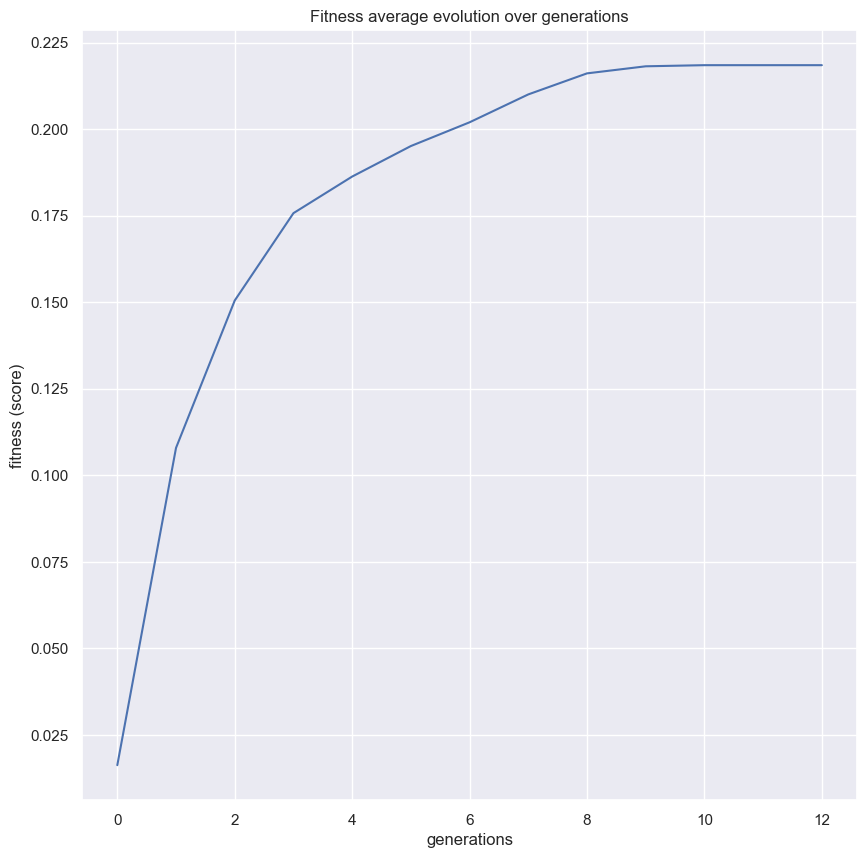

In [56]:
plot_fitness_evolution(rf_estimator_ga)

In [57]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
predict_df = monthly_count[['ds']]

last_date = predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=months_to_predict + 1, freq='MS')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * 12
predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

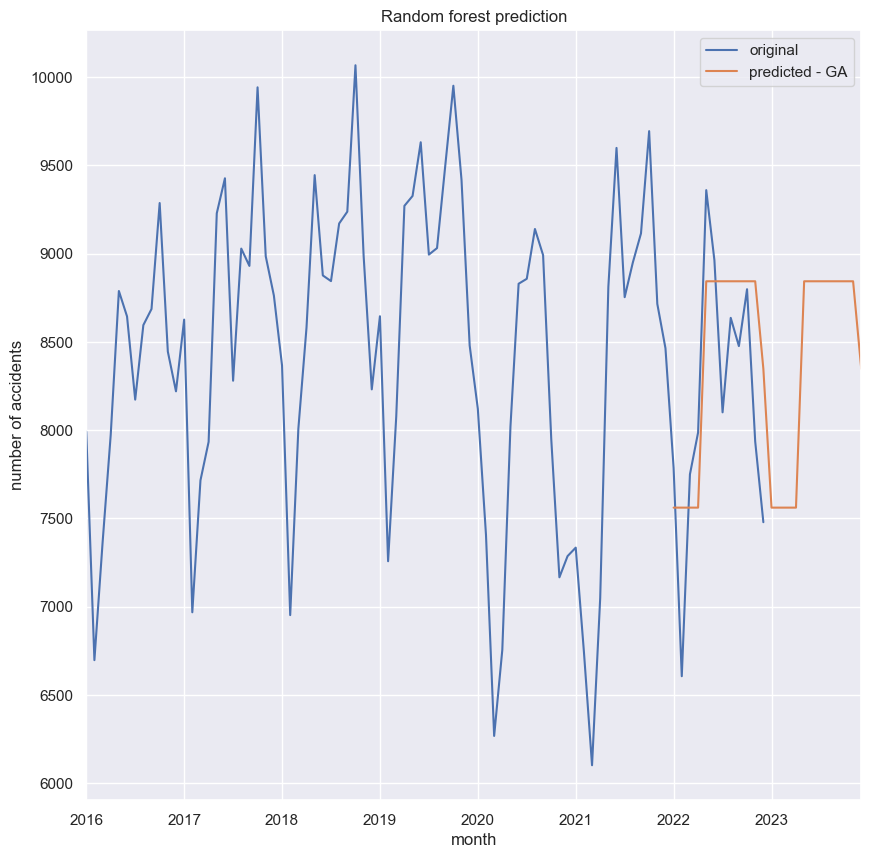

In [58]:
# plot results with random forest and GA
predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [59]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [60]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [61]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

RandomizedSearchCV(error_score='raise',
                   estimator=RandomForestRegressor(random_state=111), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['poisson',
                                                      'squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [0.1, 0.9],
                                        'n_estimators': [100, 600]},
                   random_state=111, scoring='r2')

In [62]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [63]:
y_predict_rf_randomized

array([7630.095, 6845.555, 6842.805, 6870.095, 8951.805, 8988.08 ,
       8894.985, 8992.625, 8996.925, 8841.67 , 8768.455, 8393.07 ,
       7630.095, 6845.555, 6842.805, 6870.095, 8951.805, 8988.08 ,
       8894.985, 8992.625, 8996.925, 8841.67 , 8768.455, 8393.07 ])

In [64]:
predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

Text(0, 0.5, 'number of accidents')

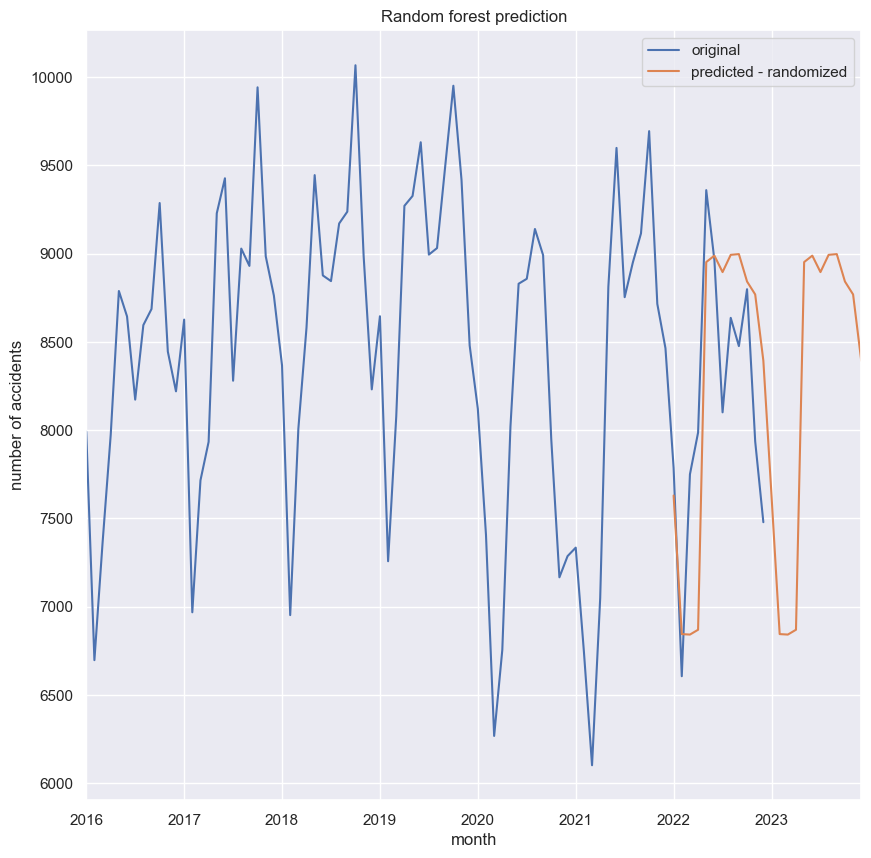

In [65]:
# plot results with random forest and randomized search cv
predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [66]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [67]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [68]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [69]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [70]:
y_predict_rf_grid

array([7349.74916667, 6772.295     , 6784.82      , 6934.98916667,
       8999.1075    , 9123.6605    , 9093.26133333, 9118.51916667,
       9124.42166667, 9235.615     , 8369.1875    , 8312.3375    ,
       7349.74916667, 6772.295     , 6784.82      , 6934.98916667,
       8999.1075    , 9123.6605    , 9093.26133333, 9118.51916667,
       9124.42166667, 9235.615     , 8369.1875    , 8312.3375    ])

In [71]:
predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

Text(0, 0.5, 'number of accidents')

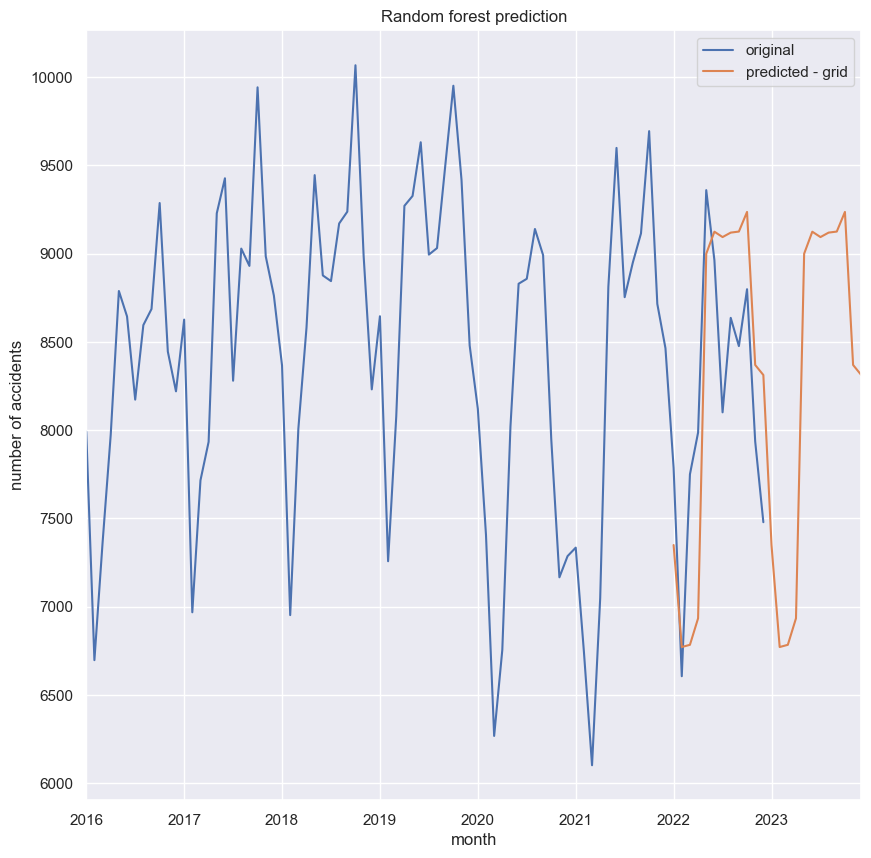

In [72]:
# plot results with random forest and grid search cv
predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [73]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:12], y_test_ga)

0.38079626248441134

In [74]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:12], y_test_ga)

0.1979372704462088

In [75]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:12], y_test_ga)

0.15756574479092245

Text(0, 0.5, 'number of accidents')

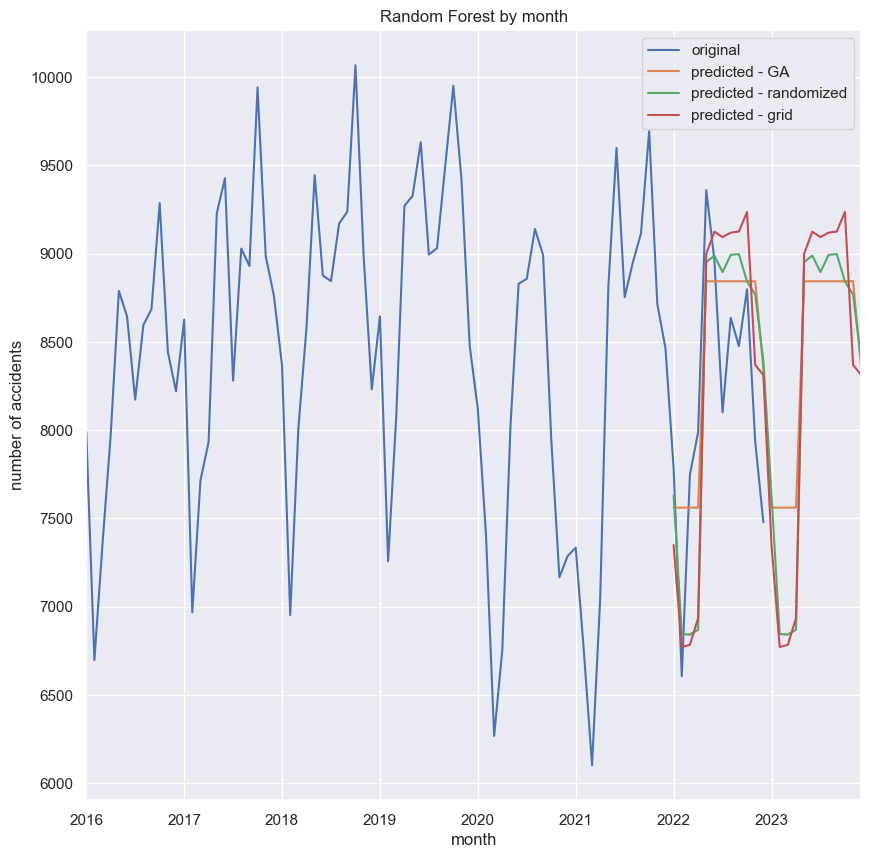

In [76]:
# plot all 3 techniques for random forest on one plot
predict_df.plot()
plt.title("Random Forest by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [77]:
monthly_predict_df['random forest + GA'] = list(predict_df['predicted - GA'])
monthly_predict_df['random forest + randomized'] = list(predict_df['predicted - randomized'])
monthly_predict_df['random forest + grid'] = list(predict_df['predicted - grid'])

monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2016-01-01          NaN          NaN          NaN                 NaN   
2016-02-01          NaN          NaN          NaN                 NaN   
2016-03-01          NaN          NaN          NaN                 NaN   
2016-04-01          NaN          NaN          NaN                 NaN   
2016-05-01          NaN          NaN          NaN                 NaN   
...                 ...          ...          ...                 ...   
2023-08-01  8947.191384  8804.869261  7182.074724              8843.0   
2023-09-01  8971.107381  8846.700258  6998.830085              8843.0   
2023-10-01  9354.696706  8773.192361  7004.902772              8843.0   
2023-11-01  8539.760655  8877.902841  7798.322385              8843.0   
2023-12-01  8159.440253  8781.154164  6892.858521              8347.5   

            random forest + randomized  random forest + grid  
ds                                                            
2016-01-01                         NaN                   NaN  
2016-02-01                         NaN                   NaN  
2016-03-01                         NaN                   NaN  
2016-04-01                         NaN                   NaN  
2016-05-01                         NaN                   NaN  
...                                ...                   ...  
2023-08-01                    8992.625           9118.519167  
2023-09-01                    8996.925           9124.421667  
2023-10-01                    8841.670           9235.615000  
2023-11-01                    8768.455           8369.187500  
2023-12-01                    8393.070           8312.337500  

[96 rows x 11 columns]

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [79]:
# pipeline with data scaling and random forest
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
]

In [80]:
pipeline = Pipeline(steps)

In [81]:
# GA search cv with pipeline
rf_grid_ga = {
    'rf__n_estimators': Integer(100, 600),
    'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'rf__max_depth': Integer(2,20),
    'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'rf__min_samples_split': Continuous(0.1, 0.9),
    'rf__bootstrap': Categorical([True, False])
}

rf_estimator_ga = GASearchCV(estimator=pipeline,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [82]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)

gen	nevals	fitness    	fitness_std	fitness_max	fitness_min
0  	100   	-0.00131425	0.126162   	0.218462   	-0.293392  
1  	200   	0.0920772  	0.0606578  	0.218462   	-0.0387889 
2  	200   	0.139628   	0.0470707  	0.218462   	0.0368899  
3  	200   	0.17397    	0.0335332  	0.218462   	0.0511121  
4  	200   	0.197032   	0.0195655  	0.218462   	0.161518   
5  	200   	0.210677   	0.0138259  	0.218462   	0.172906   
6  	200   	0.217049   	0.00633351 	0.218462   	0.178492   
7  	200   	0.218462   	0          	0.218462   	0.218462   
8  	200   	0.218462   	0          	0.218462   	0.218462   
9  	200   	0.218462   	0          	0.218462   	0.218462   
10 	200   	0.218462   	0          	0.218462   	0.218462   
11 	200   	0.218462   	0          	0.218462   	0.218462   
12 	200   	0.218462   	0          	0.218462   	0.218462   


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000002A560F2AD90>,
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('rf',
                                      RandomForestRegressor(bootstrap=False,
                                                            criterion='absolute_error',
                                                            max_depth=15,
                                                            max_features='auto',
                                                            min_samples_split=0.3956112524535904,
                                                            n_estimators=378,
                                                            ran...
                       'rf__max_depth': <sklearn_genetic.space.space.Integer object at 0x000002A560991A30>,
                       'rf__max_features': <sklearn_genetic.space.space.Categorical object at 0x000002A560991430>,
                       'rf__min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000002A5609916D0>,
                       'rf__n_estimators': <sklearn_genetic.space.space.Integer object at 0x000002A560991310>},
           population_size=100, return_train_score=True, scoring='r2')

In [83]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [84]:
y_predict_rf_ga

array([7561.5, 7561.5, 7561.5, 7561.5, 8843. , 8843. , 8843. , 8843. ,
       8843. , 8843. , 8843. , 8347.5, 7561.5, 7561.5, 7561.5, 7561.5,
       8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8843. , 8347.5])

In [85]:
# r2 score for random forest with GA and pipeline
rf_estimator_ga.score(X_test_ga[:12], y_test_ga)

0.38079626248441134

In [86]:
predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

Text(0, 0.5, 'number of accidents')

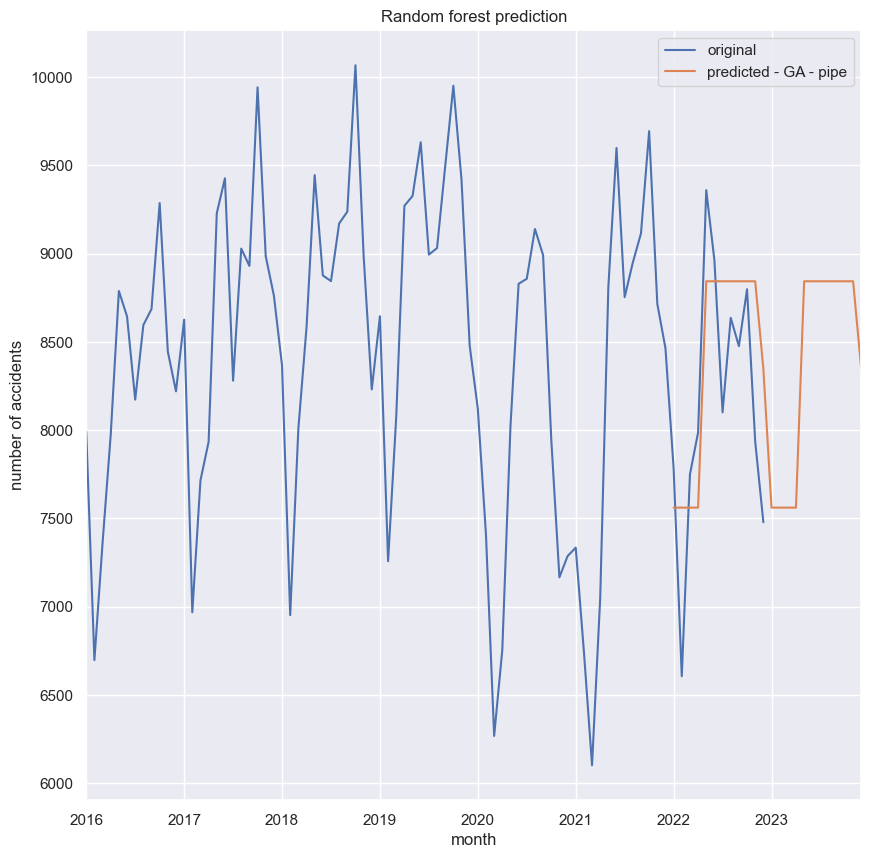

In [87]:
# plot results of random forest regressor with pipeline and GA search cv
predict_df[['original', 'predicted - GA - pipe']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [88]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [89]:
mlp = MLPRegressor(random_state=111)

In [90]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [91]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(monthly_count_ga[['day', 'month', 'year', 'y']].head(len(monthly_count_ga) - 12))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
scaled_data = monthly_count[['day', 'month', 'year', 'y']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y']]), columns=['day', 'month', 'year', 'y'])

X = scaled_data[['day', 'month', 'year']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - months_to_predict - 12)
X_test_scale = X.tail(months_to_predict + 12)
y_train_scale = y.head(len(X) - months_to_predict - 12)
y_test_scale = y.tail(months_to_predict + 12)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

((72, 3), (24, 3), (72,), (24,))

In [92]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [93]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [94]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	200   	-0.895319	1.08852    	0.0486014  	-8.77837   
1  	400   	-0.34697 	0.204724   	0.050138   	-0.995059  
2  	400   	-0.215753	0.128467   	0.050138   	-0.7206    
3  	400   	-0.12285 	0.0941312  	0.0575291  	-0.370234  
4  	400   	-0.0605515	0.0987155  	0.0575287  	-0.942026  
5  	400   	-0.0128282	0.0566871  	0.0575287  	-0.26457   
6  	400   	0.0126386 	0.0498685  	0.0591854  	-0.236793  
7  	400   	0.0314482 	0.0455161  	0.0591861  	-0.472444  
8  	400   	0.0380567 	0.0490285  	0.103834   	-0.495155  
9  	400   	0.0532874 	0.0272437  	0.103834   	-0.236378  
10 	400   	0.0614547 	0.0318357  	0.103834   	-0.236496  
11 	400   	0.071029  	0.0406286  	0.103834   	-0.344995  
12 	400   	0.0887422 	0.0275953  	0.103834   	-0.163084  


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000002A5097383D0>,
           error_score='raise',
           estimator=MLPRegressor(alpha=0.005258735301658574,
                                  hidden_layer_sizes=59,
                                  learning_rate='invscaling', max_iter=246,
                                  random_state=111, solver='sgd'),
           generations=12,
           mutation_probability=<sklearn_genetic.schedules.schedul...
                       'hidden_layer_sizes': <sklearn_genetic.space.space.Integer object at 0x000002A5090EE5E0>,
                       'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x000002A5090EE6D0>,
                       'max_iter': <sklearn_genetic.space.space.Integer object at 0x000002A5090EE6A0>,
                       'solver': <sklearn_genetic.space.space.Categorical object at 0x000002A5090EE790>},
           population_size=200, return_train_score=True, scoring='r2')

In [95]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

array([-0.28562529, -0.14218304, -0.03187456,  0.06563785,  0.16119706,
        0.2430873 ,  0.31322335,  0.40198261,  0.47543443,  0.53300166,
        0.60293773,  0.67493884, -0.23475302, -0.13470085, -0.03252316,
        0.06903885,  0.17034134,  0.26429674,  0.34713481,  0.41577584,
        0.47963472,  0.53614046,  0.59454104,  0.67040654])

In [96]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(12), y_test_scale.head(12))

-0.46000885899080224

In [97]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_3976\3139332339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_ga.tolist()


day  month    year            y
0   1.0    1.0  2022.0  8200.710762
1   1.0    2.0  2022.0  8331.136184
2   1.0    3.0  2022.0  8431.434603
3   1.0    4.0  2022.0  8520.098139
4   1.0    5.0  2022.0  8606.985718
5   1.0    6.0  2022.0  8681.444739
6   1.0    7.0  2022.0  8745.216213
7   1.0    8.0  2022.0  8825.920913
8   1.0    9.0  2022.0  8892.707267
9   1.0   10.0  2022.0  8945.050491
10  1.0   11.0  2022.0  9008.640135
11  1.0   12.0  2022.0  9074.107421
12  1.0    1.0  2023.0  8246.966577
13  1.0    2.0  2023.0  8337.939393
14  1.0    3.0  2023.0  8430.844861
15  1.0    4.0  2023.0  8523.190513
16  1.0    5.0  2023.0  8615.300185
17  1.0    6.0  2023.0  8700.729503
18  1.0    7.0  2023.0  8776.050338
19  1.0    8.0  2023.0  8838.462455
20  1.0    9.0  2023.0  8896.526397
21  1.0   10.0  2023.0  8947.904454
22  1.0   11.0  2023.0  9001.005414
23  1.0   12.0  2023.0  9069.986411

Text(0, 0.5, 'number of accidents')

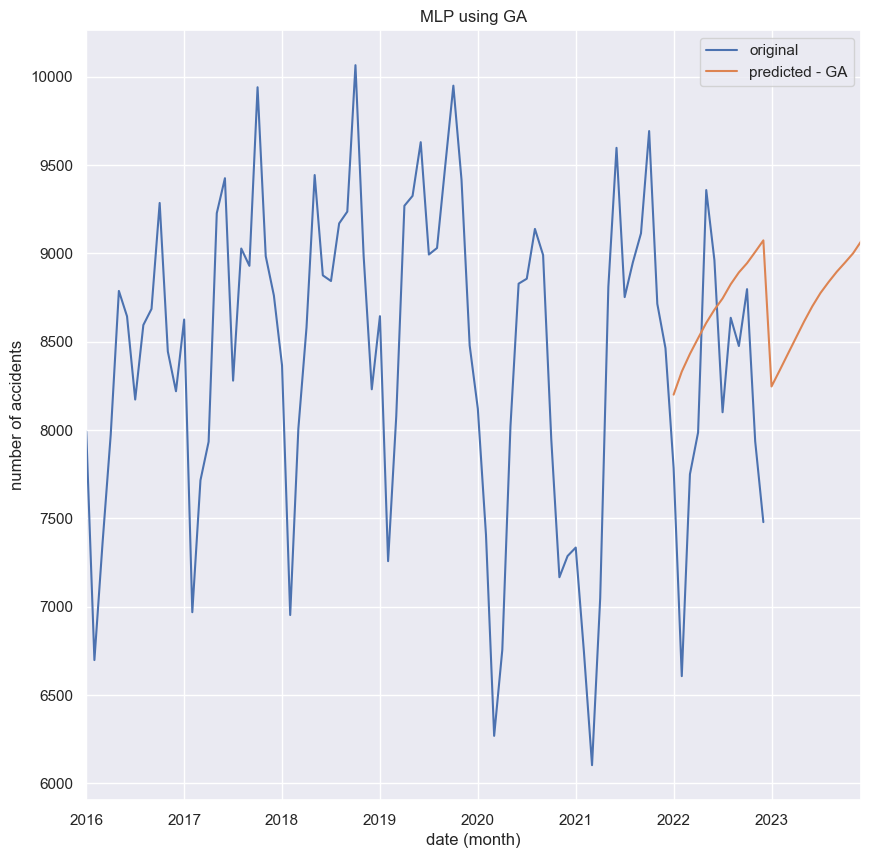

In [98]:
predict_df = pd.concat([monthly_count[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

predict_df['original'] = list(monthly_count['y']) + [None] * months_to_predict
predict_df['predicted - GA'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df.set_index('ds', inplace=True)
predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

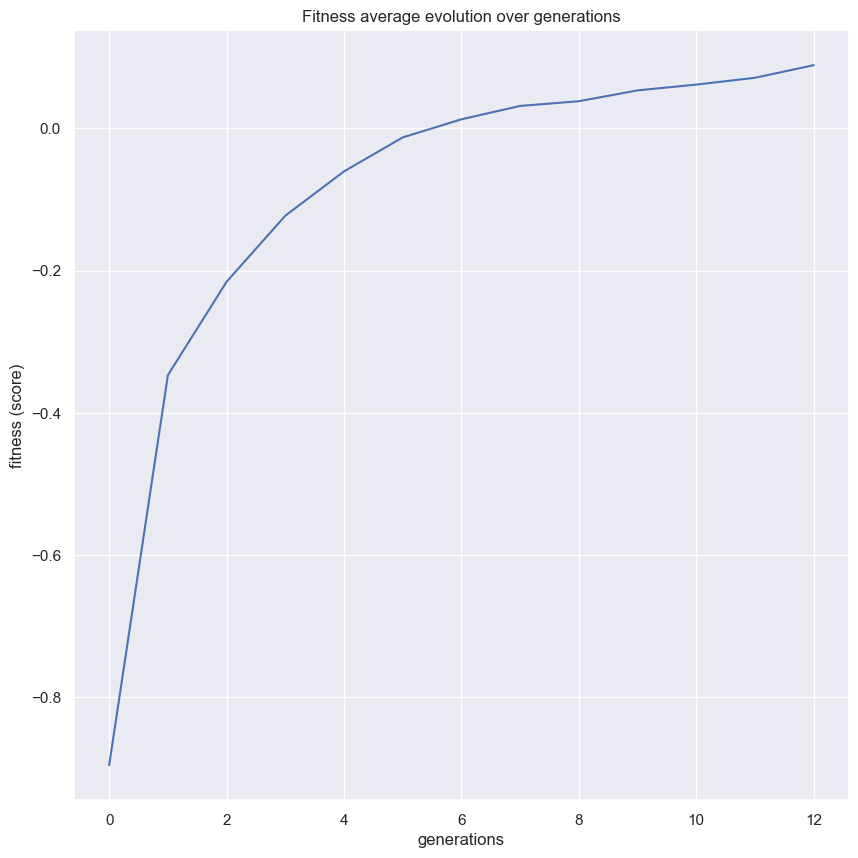

In [99]:
plot_fitness_evolution(mlp_estimator_ga)

In [100]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [101]:
from sklearn.model_selection import RandomizedSearchCV

mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [102]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=MLPRegressor(alpha=0.005258735301658574,
                                          hidden_layer_sizes=59,
                                          learning_rate='invscaling',
                                          max_iter=246, random_state=111,
                                          solver='sgd'),
                   n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [5e-05, 0.05],
                                        'hidden_layer_sizes': [10, 500],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [150, 300],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=111, scoring='neg_root_mean_squared_error')

In [103]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_randomized

array([-2.10004791, -1.84246748, -1.56751849, -1.15981008, -0.74579814,
       -0.33178969,  0.05495546,  0.27451376,  0.21784281,  0.09216976,
       -0.05117521, -0.28436577, -2.3631446 , -2.0907177 , -1.81545806,
       -1.40918919, -1.00194054, -0.59775331, -0.23934798, -0.06574099,
       -0.09243835, -0.2037329 , -0.33350234, -0.47102197])

In [104]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year']].head(12), y_test_scale.head(12))

-0.8130834123484522

In [105]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_3976\2992247175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()


day  month    year            y
0   1.0    1.0  2022.0  6550.939973
1   1.0    2.0  2022.0  6785.145979
2   1.0    3.0  2022.0  7035.144409
3   1.0    4.0  2022.0  7405.854864
4   1.0    5.0  2022.0  7782.296823
5   1.0    6.0  2022.0  8158.735603
6   1.0    7.0  2022.0  8510.385131
7   1.0    8.0  2022.0  8710.019366
8   1.0    9.0  2022.0  8658.491085
9   1.0   10.0  2022.0  8544.222374
10  1.0   11.0  2022.0  8413.885407
11  1.0   12.0  2022.0  8201.855986
12  1.0    1.0  2023.0  6311.718291
13  1.0    2.0  2023.0  6559.423503
14  1.0    3.0  2023.0  6809.704399
15  1.0    4.0  2023.0  7179.105938
16  1.0    5.0  2023.0  7549.398352
17  1.0    6.0  2023.0  7916.907158
18  1.0    7.0  2023.0  8242.788586
19  1.0    8.0  2023.0  8400.641421
20  1.0    9.0  2023.0  8376.366737
21  1.0   10.0  2023.0  8275.171738
22  1.0   11.0  2023.0  8157.178373
23  1.0   12.0  2023.0  8032.138113

Text(0, 0.5, 'number of accidents')

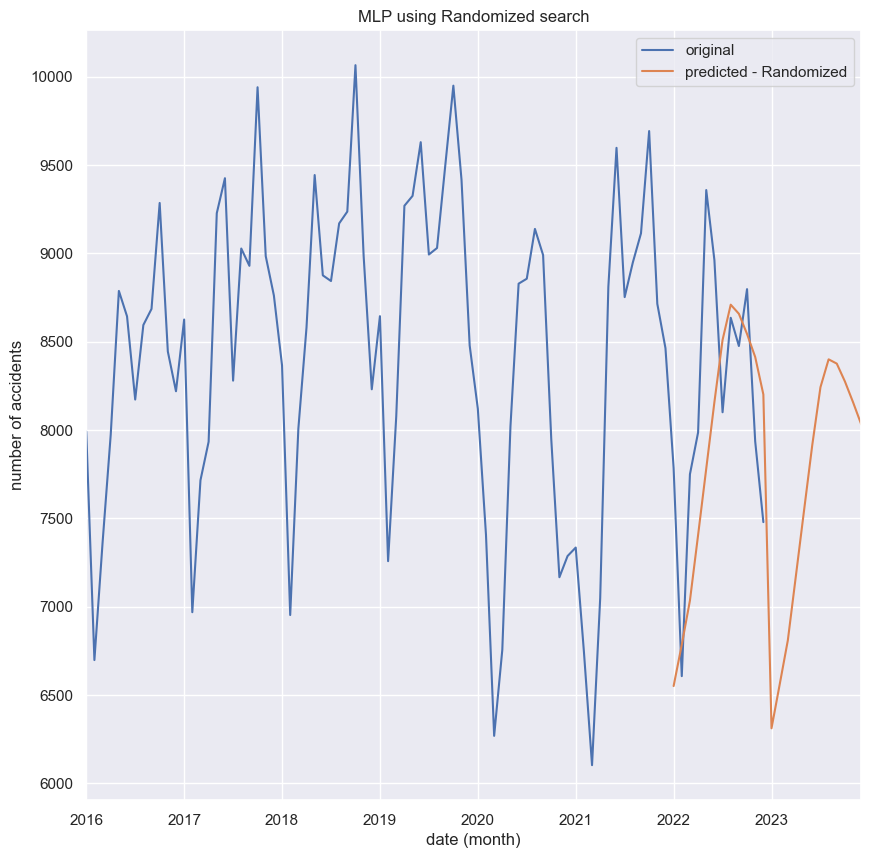

In [106]:
# plot predicted values from MLP model with randomized search cv
predict_df['predicted - Randomized'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [107]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [108]:
from sklearn.model_selection import GridSearchCV

mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [109]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(error_score='raise',
             estimator=MLPRegressor(alpha=0.005258735301658574,
                                    hidden_layer_sizes=59,
                                    learning_rate='invscaling', max_iter=246,
                                    random_state=111, solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.05],
                         'hidden_layer_sizes': [10, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [150, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_root_mean_squared_error')

In [110]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_grid

array([-0.84152622, -1.63788287, -1.80442158, -1.15825419,  0.1812241 ,
        1.19088398,  1.53300327,  1.56163188,  1.48957105,  1.38255307,
        1.25696781,  1.11634386, -0.52777083, -1.24823856, -1.42450206,
       -0.91962546,  0.36470287,  1.57898255,  2.09183655,  2.20186869,
        2.17957836,  2.1175718 ,  2.04008317,  1.95215859])

In [111]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year']].head(12), y_test_scale.head(12))

-1.2796208462143457

In [112]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_3976\1944907383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_grid.tolist()


day  month    year             y
0   1.0    1.0  2022.0   7695.255690
1   1.0    2.0  2022.0   6971.165320
2   1.0    3.0  2022.0   6819.739359
3   1.0    4.0  2022.0   7407.269557
4   1.0    5.0  2022.0   8625.195378
5   1.0    6.0  2022.0   9543.232538
6   1.0    7.0  2022.0   9854.305826
7   1.0    8.0  2022.0   9880.336499
8   1.0    9.0  2022.0   9814.814911
9   1.0   10.0  2022.0   9717.508400
10  1.0   11.0  2022.0   9603.319513
11  1.0   12.0  2022.0   9475.456646
12  1.0    1.0  2023.0   7980.538994
13  1.0    2.0  2023.0   7325.450920
14  1.0    3.0  2023.0   7165.182649
15  1.0    4.0  2023.0   7624.243658
16  1.0    5.0  2023.0   8792.024160
17  1.0    6.0  2023.0   9896.112665
18  1.0    7.0  2023.0  10362.427147
19  1.0    8.0  2023.0  10462.474296
20  1.0    9.0  2023.0  10442.206732
21  1.0   10.0  2023.0  10385.827027
22  1.0   11.0  2023.0  10315.370186
23  1.0   12.0  2023.0  10235.424428

Text(0, 0.5, 'number of accidents')

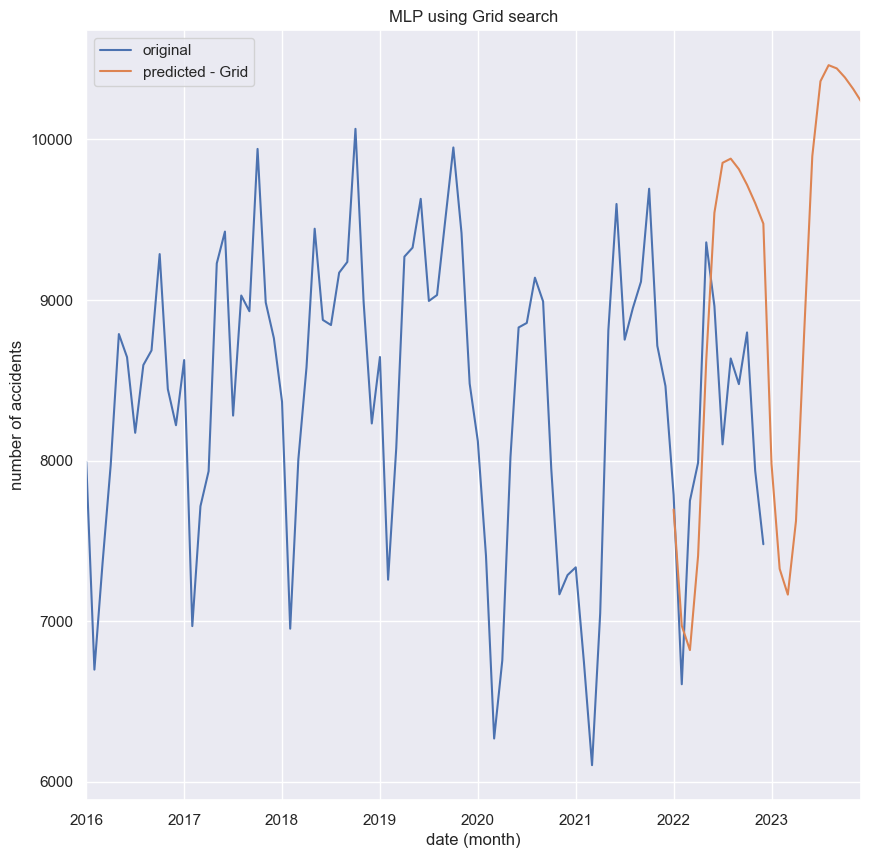

In [113]:
# plot predicted values from MLP model with grid search cv
predict_df['predicted - Grid'] = [None] * (len(predict_df) - 12 - months_to_predict) + list(predictions_unscaled['y'])
predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [114]:
monthly_predict_df['MLP + GA'] = list(predict_df['predicted - GA'])
monthly_predict_df['MLP + randomized'] = list(predict_df['predicted - Randomized'])
monthly_predict_df['MLP + grid'] = list(predict_df['predicted - Grid'])

monthly_predict_df

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2016-01-01    7992.0          NaN          NaN          NaN          NaN   
2016-02-01    6698.0          NaN          NaN          NaN          NaN   
2016-03-01    7362.0          NaN          NaN          NaN          NaN   
2016-04-01    7974.0          NaN          NaN          NaN          NaN   
2016-05-01    8788.0          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2016-01-01          NaN          NaN          NaN                 NaN   
2016-02-01          NaN          NaN          NaN                 NaN   
2016-03-01          NaN          NaN          NaN                 NaN   
2016-04-01          NaN          NaN          NaN                 NaN   
2016-05-01          NaN          NaN          NaN                 NaN   
...                 ...          ...          ...                 ...   
2023-08-01  8947.191384  8804.869261  7182.074724              8843.0   
2023-09-01  8971.107381  8846.700258  6998.830085              8843.0   
2023-10-01  9354.696706  8773.192361  7004.902772              8843.0   
2023-11-01  8539.760655  8877.902841  7798.322385              8843.0   
2023-12-01  8159.440253  8781.154164  6892.858521              8347.5   

            random forest + randomized  random forest + grid     MLP + GA  \
ds                                                                          
2016-01-01                         NaN                   NaN          NaN   
2016-02-01                         NaN                   NaN          NaN   
2016-03-01                         NaN                   NaN          NaN   
2016-04-01                         NaN                   NaN          NaN   
2016-05-01                         NaN                   NaN          NaN   
...                                ...                   ...          ...   
2023-08-01                    8992.625           9118.519167  8838.462455   
2023-09-01                    8996.925           9124.421667  8896.526397   
2023-10-01                    8841.670           9235.615000  8947.904454   
2023-11-01                    8768.455           8369.187500  9001.005414   
2023-12-01                    8393.070           8312.337500  9069.986411   

            MLP + randomized    MLP + grid  
ds                                          
2016-01-01               NaN           NaN  
2016-02-01               NaN           NaN  
2016-03-01               NaN           NaN  
2016-04-01               NaN           NaN  
2016-05-01               NaN           NaN  
...                      ...           ...  
2023-08-01       8400.641421  10462.474296  
2023-09-01       8376.366737  10442.206732  
2023-10-01       8275.171738  10385.827027  
2023-11-01       8157.178373  10315.370186  
2023-12-01       8032.138113  10235.424428  

[96 rows x 14 columns]

In [212]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [298]:
def create_graph_dataset(dataframe, num_neighbors=5):
    ds_values = pd.to_datetime(dataframe['ds']).values.astype(float)
    y_values = dataframe['y'].values.astype(float)

    x = torch.tensor(y_values, dtype=torch.float32).view(-1, 1)
    edge_index = torch.zeros((2, 0), dtype=torch.long)

    for i in range(len(ds_values)):
        # num_neighbors nearest timestamps will be edges
        start = max(0, i - num_neighbors)
        end = min(len(ds_values), i + num_neighbors + 1)
        neighbors = list(range(start, i)) + list(range(i + 1, end))
        edges = torch.tensor([[i] * len(neighbors), neighbors], dtype=torch.long)
        edge_index = torch.cat([edge_index, edges], dim=1)

    return Data(x=x, edge_index=edge_index)

# create a graph dataset from the DataFrame with train and test data
train_dataset = create_graph_dataset(monthly_count_train)
test_dataset = create_graph_dataset(monthly_count_test)

# create data loaders for training and testing
train_loader = DataLoader([train_dataset], batch_size=64)
test_loader = DataLoader([test_dataset], batch_size=64)

In [299]:
# define the GNN model
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TimeSeriesGNN, self).__init__()
        torch.manual_seed(111)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear1 = torch.nn.Linear(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # second GCN layer
        x = self.conv2(x, edge_index)
        
        x = self.linear1(x)

        return x

# dimensions used for the GNN
input_dim = 1  # dimension of node features
hidden_dim = 64
output_dim = 1  # dimension of the predicted output

model = TimeSeriesGNN(input_dim, hidden_dim, output_dim)  # create the GNN model

loss_fn = nn.MSELoss()  # loss function used for regression

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # optimizer used for regression

# train the model using the DataLoader object
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.x)
        loss.backward()
        optimizer.step()

# make predictions
model.eval()
for data in test_loader:
    output = model(data)
    print(output)
    monthly_predict_df['GNN'] = [None] * len(monthly_count_train) + output.flatten().tolist() + [None] * months_to_predict

tensor([[6737.9297],
        [7287.1870],
        [7808.2510],
        [8299.7285],
        [8770.3701],
        [9212.4961],
        [9233.5820],
        [8823.0947],
        [8393.0020],
        [7936.3623],
        [7438.3013],
        [6896.5308]], grad_fn=<AddmmBackward0>)


In [317]:
from autots import AutoTS

In [318]:
model_monthly = AutoTS(forecast_length=months_to_predict)
model_monthly = model_monthly.fit(monthly_count_train, date_col='ds', value_col='y', id_col=None)

Inferred frequency is: MS
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
2/2 [==============================] - 19s 20ms/step - loss: 0.3540
Epoch 2/50
2/2 [==============================] - 0s 13ms/step - loss: 0.3468
Epoch 3/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3386
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3386
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.3336
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3300
Epoch 7/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3302
Epoch 8/50
2/2 [==============================] - 0s 14ms/step - loss: 0.3192
Epoch 9/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3211
Epoch 10/50
2/2 [==============================] - 0s 15ms/step - loss: 0.3149
Epoch 11/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3123
Epoch 12/50
2/2 [==============================] - 0s 17ms/step - loss:

11:22:00 - cmdstanpy - INFO - Chain [1] start processing
11:22:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

11:22:13 - cmdstanpy - INFO - Chain [1] start processing
11:26:10 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in mo

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 69 with model FBProphet in generation 0 of 10


11:26:15 - cmdstanpy - INFO - Chain [1] start processing
11:26:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 74 in generation 0: ARIMA
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regre

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 106 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'cffilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: ETS
Model Number: 107 with model UnobservedComponents in generation 0 of 10
Model Number: 108 with model NVAR in generation 0 of 10
Model Number: 109 with model Gluo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 113 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 113 in generation 0: VAR
Model Number: 114 with model ETS in generation 0 of 10
Model Number: 115 with model ETS in generation 0 of 10
Model Number: 116 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 116 in generation 0: UnobservedComponents
Model Number: 117 with model ETS in generation 0 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
Model Number: 118 with model SeasonalNaive in generation 0 of 10
Model Number: 119 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_r

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 3.462e-05
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: ETS
Model Number: 140 with model ConstantNaive in generation 0 of 10
Model Number: 141 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 141 in generation 0: MultivariateRegression
Model Number: 142 with model VAR in generation 0 of 10
Template Eval Error: IndexError('tuple index out of range') in model 142 in generation 0: VAR
Model Number: 143 with model NVAR in generation 0 of 10
Model Number: 144 with model SeasonalNaive in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 144 in generation 0: SeasonalNaive
Model Number: 145 with model LastValueNaive in generation 0 of 10
Model Number: 146 with model LastValueNaive in generation 0 of 10
Model Number: 147 with model FBProphet in generation 0 of 10
No anomalies det

11:26:51 - cmdstanpy - INFO - Chain [1] start processing
11:27:02 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 148 with model LastValueNaive in generation 0 of 10
Model Number: 149 with model SeasonalNaive in generation 0 of 10
Model Number: 150 with model NVAR in generation 0 of 10
Model Number: 151 with model MultivariateRegression in generation 0 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 151 in generation 0: MultivariateRegression
Model Number: 152 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 152 in generation 0: VECM
Model Number: 153 with model NVAR in generation 0 of 10
Model Number: 154 with model AverageValueNaive in generation 0 of 10
Model Number: 155 with model ARCH in generation 0 of 10
M

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 173 with model MultivariateMotif in generation 0 of 10
Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model ARDL in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 175 in generation 0: ARDL
Model Number: 176 with model DatepartRegression in generation 0 of 10
Model Number: 177 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 177 in generation 0: UnobservedComponents
Model Number: 178 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 178 in generation 0: UnobservedComponents
Model Number: 179 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 179 in gen

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 201 with model FBProphet in generation 1 of 10
No anomalies detected.


11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 202 with model GLM in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 202 in generation 1: GLM
Model Number: 203 with model WindowRegression in generation 1 of 10
Model Number: 204 with model SeasonalNaive in generation 1 of 10
Model Number: 205 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 205 in generation 1: DatepartRegression
Model Number: 206 with model AverageValueNaive in generation 1 of 10
Model Number: 207 with model UnobservedComponents in generation 1 of 10
Model Number: 208 with model ARDL in generation 1 of 10
Model Number: 209 with model DatepartRegression in generation 1 of 10
Model Number: 210 with model Theta in generation 1 of 10
Model Number: 211 with model ConstantNaive in generation 1 of 10
Model Number: 212 with model MultivariateMotif in generation 1 of 10
Model Number: 213 with model ETS in generation 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 230 with model SectionalMotif in generation 1 of 10
Model Number: 231 with model UnivariateMotif in generation 1 of 10
Model Number: 232 with model UnivariateMotif in generation 1 of 10
Model Number: 233 with model NVAR in generation 1 of 10
Model Number: 234 with model NVAR in generation 1 of 10
Model Number: 235 with model GLS in generation 1 of 10
Model Number: 236 with model DatepartRegression in generation 1 of 10
Model Number: 237 with model DatepartRegression in generation 1 of 10
Model Number: 238 with model UnobservedComponents in generation 1 of 10
Model Number: 239 with model MultivariateRegression in generation 1 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 239 in generation 1: MultivariateRegression
Model Number: 240 with model MetricMotif in generation 1 of 10
Model Number: 241 with model LastValueNaive in generation 1 of 10
Model Number: 242 with model GLM in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 243 with model MultivariateMotif in generation 1 of 10
Model Number: 244 with model WindowRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 245 with model AverageValueNaive in generation 1 of 10
Model Number: 246 with model SeasonalNaive in generation 1 of 10
Model Number: 247 with model SeasonalNaive in generation 1 of 10
Model Number: 248 with model ARCH in generation 1 of 10
HolidayTransformer: no anomalies detected.
Model Number: 249 with model FBProphet in generation 1 of 10


11:31:22 - cmdstanpy - INFO - Chain [1] start processing
11:31:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 250 with model MultivariateRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 251 with model NVAR in generation 1 of 10
Model Number: 252 with model SeasonalNaive in generation 1 of 10
Model Number: 253 with model UnivariateRegression in generation 1 of 10
Model Number: 254 with model NVAR in generation 1 of 10
Model Number: 255 with model SectionalMotif in generation 1 of 10
Template Eval Error: ValueError('kth(=10) out of bounds (10)') in model 255 in generation 1: SectionalMotif
Model Number: 256 with model GLS in generation 1 of 10
Model Number: 257 with model SeasonalNaive in generation 1 of 10
Model Number: 258 with model ARCH in generation 1 of 10
Model Number: 259 with model GLS in generation 1 of 10
Model Number: 260 with model ConstantNaive in generation 1 of 10
Model Number: 261 with model UnobservedComponents in generation 1 of 10
Model Number: 262 with model UnivariateRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 262 in generation 1: UnivariateRegr

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 269 with model GLS in generation 1 of 10
Model Number: 270 with model ConstantNaive in generation 1 of 10
Model Number: 271 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 272 with model DatepartRegression in generation 1 of 10
Model Number: 273 with model ETS in generation 1 of 10
Model Number: 274 with model SeasonalNaive in generation 1 of 10
Model Number: 275 with model DatepartRegression in generation 1 of 10
Model Number: 276 with model FBProphet in generation 1 of 10
No anomalies detected.


11:32:02 - cmdstanpy - INFO - Chain [1] start processing
11:32:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 277 with model GLM in generation 1 of 10
Model Number: 278 with model Theta in generation 1 of 10
Model Number: 279 with model DatepartRegression in generation 1 of 10
Epoch 1/50
2/2 [==============================] - 27s 13ms/step - loss: 0.4682
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4586
Epoch 3/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4542
Epoch 4/50
2/2 [==============================] - 0s 13ms/step - loss: 0.4424
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4402
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4339
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 0.4241
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.4189
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 0.4232
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4107
Epoch 11/50
2/2 [===================

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Model Number: 288 with model ETS in generation 1 of 10
Model Number: 289 with model UnobservedComponents in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 289 in generation 1: UnobservedComponents
Model Number: 290 with model Theta in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Model Number: 291 with model UnivariateRegression in generation 1 of 10
Template Eval Error: ValueError('Input X contains NaN.\nMultiTaskElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 291 in generation 1: UnivariateRegression
Model Number: 292 with model WindowRegression in generation 1 of 10
Model Number: 293 with model DatepartRegression in generation 1 of 10
Model Number: 294 with model LastValueNaive in generation 1 o

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 299 with model GLS in generation 1 of 10
Model Number: 300 with model ConstantNaive in generation 1 of 10
Model Number: 301 with model UnobservedComponents in generation 1 of 10
Template Eval Error: LinAlgError('Singular matrix') in model 301 in generation 1: UnobservedComponents
Model Number: 302 with model GLM in generation 1 of 10
Model Number: 303 with model NVAR in generation 1 of 10
Model Number: 304 with model SectionalMotif in generation 1 of 10
Model Number: 305 with model UnivariateMotif in generation 1 of 10
Template Eval Error: ValueError('The number of observations (22) is too small; the covariance matrix is singular. For observations with 28 dimensions, at least 29 observations are required.') in model 305 in generation 1: UnivariateMotif
Model Number: 306 with model AverageValueNaive in generation 1 of 10
Model Number: 307 with model Theta in generation 1 of 10
Model Number: 308 with model MultivariateRegression in generation 1 of 10
Model Number: 309 with 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


Model Number: 318 with model UnivariateMotif in generation 2 of 10
Model Number: 319 with model MultivariateRegression in generation 2 of 10
Model Number: 320 with model UnivariateMotif in generation 2 of 10
Model Number: 321 with model ETS in generation 2 of 10
Model Number: 322 with model Theta in generation 2 of 10
Model Number: 323 with model SeasonalNaive in generation 2 of 10
Model Number: 324 with model NVAR in generation 2 of 10
Model Number: 325 with model LastValueNaive in generation 2 of 10
Model Number: 326 with model DatepartRegression in generation 2 of 10
Model Number: 327 with model ETS in generation 2 of 10
Model Number: 328 with model SectionalMotif in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 328 in generation 2: SectionalMotif
Model Number: 329 with model NVAR in generation 2 of 10
Model Number: 330 with model ARDL in generation 2 of 10
Template Eval Error: ValueError("ARDL series y failed with error I

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 335 with model DatepartRegression in generation 2 of 10
Epoch 1/50
2/2 [==============================] - 29s 28ms/step - loss: 0.1281
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1017
Epoch 3/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0648
Epoch 4/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0470
Epoch 5/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0362
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0382
Epoch 7/50
2/2 [==============================] - 0s 44ms/step - loss: 0.0416
Epoch 8/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0445
Epoch 9/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0436
Epoch 10/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0433
Epoch 11/50
2/2 [==============================] - 0s 20ms/step - loss: 0.0402
Epoch 12/50
2/2 [==============================] - 0s 22ms/step - los

11:34:40 - cmdstanpy - INFO - Chain [1] start processing
11:34:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 342 with model WindowRegression in generation 2 of 10
Model Number: 343 with model MultivariateRegression in generation 2 of 10
Model Number: 344 with model SeasonalNaive in generation 2 of 10
Model Number: 345 with model SeasonalNaive in generation 2 of 10
Model Number: 346 with model DatepartRegression in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 346 in generation 2: DatepartRegression
Model Number: 347 with model AverageValueNaive in generation 2 of 10
Model Number: 348 with model SectionalMotif in generation 2 of 10
Model Number: 349 with model ETS in generation 2 of 10
Model Number: 350 with model DatepartRegression in generation 2 of 10
Model Number: 351 with model Theta in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 352 with model UnivariateMotif in generation 2 of 10
Model Number: 353 with model MetricMotif in generation 2 of 10
Model Number: 354 with model UnivariateMotif in generation 2 of 10
Model Number: 355 with model ConstantNaive in generation 2 of 10
Model Number: 356 with model NVAR in generation 2 of 10
Model Number: 357 with model MultivariateRegression in generation 2 of 10
Model Number: 358 with model FBProphet in generation 2 of 10


11:34:46 - cmdstanpy - INFO - Chain [1] start processing
11:34:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 359 with model UnivariateRegression in generation 2 of 10
Model Number: 360 with model MultivariateRegression in generation 2 of 10
Model Number: 361 with model GLS in generation 2 of 10
Model Number: 362 with model LastValueNaive in generation 2 of 10
Model Number: 363 with model UnobservedComponents in generation 2 of 10
Model Number: 364 with model Theta in generation 2 of 10
Model Number: 365 with model DatepartRegression in generation 2 of 10
Model Number: 366 with model ARDL in generation 2 of 10
Model Number: 367 with model UnivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 367 in generation 2: UnivariateRegression
Model Number: 368 with model SectionalMotif in generation 2 of 10
Template Eval Error: ValueError('zero-size array to reduction operation fmax which has no identity') in model 368 in generation 2: SectionalMotif
Model Number: 369 with model ARDL in generation 2 

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Model Number: 371 with model ConstantNaive in generation 2 of 10
Model Number: 372 with model AverageValueNaive in generation 2 of 10
Model Number: 373 with model WindowRegression in generation 2 of 10
Model Number: 374 with model NVAR in generation 2 of 10
Model Number: 375 with model MultivariateMotif in generation 2 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (39)') in model 375 in generation 2: MultivariateMotif
Model Number: 376 with model MetricMotif in generation 2 of 10
Template Eval Error: ValueError('kth(=99) out of bounds (34)') in model 376 in generation 2: MetricMotif
Model Number: 377 with model SeasonalNaive in generation 2 of 10
Model Number: 378 with model Theta in generation 2 of 10
Model Number: 379 with model MultivariateRegression in generation 2 of 10
Model Number: 380 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 380 in generation 2: Datepart

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in double_scalars
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 385 with model AverageValueNaive in generation 2 of 10
Model Number: 386 with model GLS in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 386 in generation 2: GLS
Model Number: 387 with model ARDL in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 388 with model Theta in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 388 in generation 2: Theta
Model Number: 389 with model GLS in generation 2 of 10
Model Number: 390 with model DatepartRegression in generation 2 of 10
Model Number: 391 with model NVAR in generation 2 of 10
Model Number: 392 with model AverageValueNaive in generation 2 of 10
Model Number: 393 with model MetricMotif in generation 2 of 10
Model Number: 394 with model GLM in generation 2 of 10
Model Number: 395 with model MultivariateRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 396 with model GLS in generation 2 of 10
Model Number: 397 with model ConstantNaive in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 397 in generation 2: ConstantNaive
Model Number: 398 with model SectionalMotif in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 398 in generation 2: SectionalMotif
Model Number: 399 with model SeasonalNaive in generation 2 of 10
Model Number: 400 with model ARDL in generation 2 of 10
Template Eval Error: ValueError("ARDL series y failed with error ValueError('The number of regressors (107) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (57).') exog train             seasonalitycommonfourier_0  seasonalitycommonfourier_1  \\\nds                                                                   \n2016-01-01                    0.99996

Model Number: 402 with model UnobservedComponents in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 402 in generation 2: UnobservedComponents
Model Number: 403 with model MetricMotif in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 403 in generation 2: MetricMotif
Model Number: 404 with model MultivariateRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Template Eval Error: ValueError("Input X contains infinity or a value too large for dtype('float64').") in model 404 in generation 2: MultivariateRegression
Model Number: 405 with model ARCH in generation 2 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 405 in generation 2: ARCH
Model Number: 406 with model DatepartRegression in generation 2 of 10
Epoch 1/50
8/8 [==============================] - 11s 8ms/step - loss: 1.0073
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 1.0021
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 1.0007
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 1.0005
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.9995
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 1.0039
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 1.0025
Epoch 8/50
8/8 [==============================] - 0s 8ms/step - loss: 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 410 with model UnobservedComponents in generation 2 of 10
Model Number: 411 with model ARDL in generation 2 of 10
Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 411 in generation 2: ARDL
Model Number: 412 with model WindowRegression in generation 2 of 10
Model Number: 413 with model UnobservedComponents in generation 2 of 10
Model Number: 414 with model MultivariateMotif in generation 2 of 10
Model Number: 415 with model ARIMA in generation 2 of 10
Model Number: 416 with model ARDL in generation 2 of 10
Model Number: 417 with model ARDL in generation 2 of 10
Model Number: 418 with model ARDL in generation 2 of 10
Model Number: 419 with model ARCH in generation 2 of 10
Model Number: 420 with model GLS in generation 2 of 10
Model Number: 421 with model Theta in generation 2 of 10
Model Number: 422 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") i

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods

Model Number: 436 with model SeasonalNaive in generation 2 of 10
New Generation: 3 of 10
Model Number: 437 with model Theta in generation 3 of 10
Model Number: 438 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 438 in generation 3: MultivariateRegression
Model Number: 439 with model MultivariateMotif in generation 3 of 10
Model Number: 440 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 441 with model ConstantNaive in generation 3 of 10
Model Number: 442 with model Theta in generation 3 of 10
Model Number: 443 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 443 in generation 3: GLM
Model Number: 444 with model SeasonalNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog

Model Number: 445 with model SeasonalNaive in generation 3 of 10
Model Number: 446 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 446 in generation 3: MultivariateRegression
Model Number: 447 with model AverageValueNaive in generation 3 of 10
Model Number: 448 with model NVAR in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 448 in generation 3: NVAR
Model Number: 449 with model ARCH in generation 3 of 10
Model Number: 450 with model ARDL in generation 3 of 10
Model Number: 451 with model ARDL in generation 3 of 10
Model Number: 452 with model ETS in generation 3 of 10
Model Number: 453 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 453 in generation 3: MultivariateRegression
Model Number: 454 with model MetricMotif in generation 3 of 10
Model Number: 455 with model NVAR 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)



Model Number: 457 with model MultivariateRegression in generation 3 of 10
Model Number: 458 with model NVAR in generation 3 of 10
Model Number: 459 with model ARDL in generation 3 of 10
Model Number: 460 with model ETS in generation 3 of 10
Model Number: 461 with model ETS in generation 3 of 10
Model Number: 462 with model UnivariateMotif in generation 3 of 10
Model Number: 463 with model SeasonalNaive in generation 3 of 10
Model Number: 464 with model FBProphet in generation 3 of 10


11:35:32 - cmdstanpy - INFO - Chain [1] start processing
11:35:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 465 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 465 in generation 3: GLM
Model Number: 466 with model ETS in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 467 with model ConstantNaive in generation 3 of 10
Model Number: 468 with model ARIMA in generation 3 of 10
Model Number: 469 with model ConstantNaive in generation 3 of 10
Model Number: 470 with model Theta in generation 3 of 10
Model Number: 471 with model WindowRegression in generation 3 of 10
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 471 in generation 3: WindowRegression
Model Number: 472 with model ETS in generation 3 of 10
Model Number: 473 with model WindowRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 473 in generation 3: WindowRegression
Model Number: 474 with model MetricMotif in generation 3 of 10
Model Number: 475 with model WindowRegression in generation 3 of 10
Model Number: 476 with model MultivariateMotif in generation 3 of 10
Model Number: 477 with model AverageValueNaive in generation 3 of 10
M

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 486 with model UnivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 486 in generation 3: UnivariateMotif
Model Number: 487 with model WindowRegression in generation 3 of 10
Model Number: 488 with model MetricMotif in generation 3 of 10
Model Number: 489 with model MultivariateRegression in generation 3 of 10
Model Number: 490 with model UnobservedComponents in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 491 with model WindowRegression in generation 3 of 10
Template Eval Error: ValueError('Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by MLPRegressor.') in model 491 in generation 3: WindowRegression
Model Number: 492 with model WindowRegression in generation 3 of 10
Model Number: 493 with model SectionalMotif in generation 3 of 10
Model Number: 494 with model ETS in generation 3 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
Model Number: 495 with model MultivariateMotif in generation 3 of 10
Model Number: 496 with model MultivariateMotif in generation 3 of 10
Model Number: 497 with model MultivariateMotif in generation 3 of 10
Model Number: 498 with model UnobservedComponents in generation 3 of 10
Model Numbe

C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Model Number: 506 with model Theta in generation 3 of 10
Model Number: 507 with model SeasonalNaive in generation 3 of 10
Model Number: 508 with model ETS in generation 3 of 10
Model Number: 509 with model SeasonalNaive in generation 3 of 10
Model Number: 510 with model GLS in generation 3 of 10
Model Number: 511 with model DatepartRegression in generation 3 of 10
Epoch 1/50
2/2 [==============================] - 15s 12ms/step - loss: 0.3989
Epoch 2/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3901
Epoch 3/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3866
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.3748
Epoch 5/50
2/2 [==============================] - 0s 10ms/step - loss: 0.3716
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3698
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3556
Epoch 8/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3537
Epoch 9/

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 528 with model WindowRegression in generation 3 of 10
Model Number: 529 with model NVAR in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 530 with model SectionalMotif in generation 3 of 10
Template Eval Error: ValueError('kth(=10) out of bounds (2)') in model 530 in generation 3: SectionalMotif
Model Number: 531 with model GLM in generation 3 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 531 in generation 3: GLM
Model Number: 532 with model SeasonalNaive in generation 3 of 10
Model Number: 533 with model Theta in generation 3 of 10
Model Number: 534 with model MultivariateRegression in generation 3 of 10
Model Number: 535 with model DatepartRegression in generation 3 of 10
Model Number: 536 with model ARDL in generation 3 of 10
Model Number: 537 with model MultivariateRegression in generation 3 of 10
Model Number: 538 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 538 in generation 3: GLM
Model Number: 539 with model SectionalMotif in generation 3 o

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 539 in generation 3: SectionalMotif
Model Number: 540 with model LastValueNaive in generation 3 of 10
Model Number: 541 with model GLS in generation 3 of 10
Model Number: 542 with model SeasonalNaive in generation 3 of 10
Model Number: 543 with model SectionalMotif in generation 3 of 10
Model Number: 544 with model AverageValueNaive in generation 3 of 10
Model Number: 545 with model ARIMA in generation 3 of 10
Model Number: 546 with model GLS in generation 3 of 10
Model Number: 547 with model ETS in generation 3 of 10
Model Number: 548 with model WindowRegression in generation 3 of 10
Model Number: 549 with model SeasonalNaive in generation 3 of 10
Model Number: 550 with model ETS in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 551 with model MultivariateMotif in generation 3 of 10
Model Number: 552 with model SectionalMotif in generation 3 of 10
Model Number: 553 with model UnivariateRegression in generation 3 of 10
Template Eval Error: ValueError('Input X contains NaN.\nRidge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 553 in generation 3: UnivariateRegression
Model Number: 554 with model ETS in generation 3 of 10
Model Number: 555 with 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 569 with model ARDL in generation 4 of 10
Model Number: 570 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 570 in generation 4: MultivariateRegression
Model Number: 571 with model ARDL in generation 4 of 10
Model Number: 572 with model ARIMA in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 572 in generation 4: ARIMA
Model Number: 573 with model UnivariateMotif in generation 4 of 10
Model Number: 574 with model GLS in generation 4 of 10
Model Number: 575 with model GLS in generation 4 of 10
Model Number: 576 with model DatepartRegression in generation 4 of 10
Model Number: 577 with model SeasonalNaive in generation 4 of 10
Model Number: 578 with model MultivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 579 with model UnivariateMotif in generation 4 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (39)') in model 579 in generation 4: UnivariateMotif
Model Number: 580 with model UnivariateMotif in generation 4 of 10
Model Number: 581 with model MetricMotif in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 582 with model MultivariateRegression in generation 4 of 10
Model Number: 583 with model WindowRegression in generation 4 of 10
Model Number: 584 with model SeasonalNaive in generation 4 of 10
Model Number: 585 with model MultivariateMotif in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 585 in generation 4: MultivariateMotif
Model Number: 586 with model WindowRegression in generation 4 of 10
Model Number: 587 with model ARDL in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 587 in generation 4: ARDL
Model Number: 588 with model MultivariateMotif in generation 4 of 10
Model Number: 589 with model MultivariateRegression in generation 4 of 10
Model Number: 590 with model MultivariateRegression in generation 4 of 10
Model Number: 591 with model AverageValueNaive in generation 4 of 10
Model Number: 592 with model LastValueNaive in generation 4 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 606 with model ARDL in generation 4 of 10
Model Number: 607 with model MultivariateRegression in generation 4 of 10
Model Number: 608 with model ConstantNaive in generation 4 of 10
Model Number: 609 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 609 in generation 4: DatepartRegression
Model Number: 610 with model UnobservedComponents in generation 4 of 10
Model Number: 611 with model AverageValueNaive in generation 4 of 10
Model Number: 612 with model MetricMotif in generation 4 of 10
Model Number: 613 with model ARIMA in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 613 in generation 4: ARIMA
Model Number: 614 with model GLM in generation 4 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 614 in generation 4: GLM
Model Number: 615 with model FBP

11:37:15 - cmdstanpy - INFO - Chain [1] start processing
11:37:15 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 616 with model NVAR in generation 4 of 10
Model Number: 617 with model UnivariateMotif in generation 4 of 10
Model Number: 618 with model SeasonalNaive in generation 4 of 10
Model Number: 619 with model MetricMotif in generation 4 of 10
Model Number: 620 with model SeasonalNaive in generation 4 of 10
Model Number: 621 with model ARIMA in generation 4 of 10
Model Number: 622 with model UnobservedComponents in generation 4 of 10
Model Number: 623 with model LastValueNaive in generation 4 of 10
Model Number: 624 with model ARIMA in generation 4 of 10
Model Number: 625 with model ETS in generation 4 of 10
Model Number: 626 with model GLM in generation 4 of 10
Model Number: 627 with model ARIMA in generation 4 of 10
Model Number: 628 with model Theta in generation 4 of 10
Model Number: 629 with model MultivariateRegression in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 629 in generation 4: MultivariateRegression
Model N

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 637 in generation 4: GLM
Model Number: 638 with model MetricMotif in generation 4 of 10
Template Eval Error: ValueError('kth(=99) out of bounds (41)') in model 638 in generation 4: MetricMotif
Model Number: 639 with model UnivariateRegression in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 639 in generation 4: UnivariateRegression
Model Number: 640 with model MultivariateRegression in generation 4 of 10
Model Number: 641 with model FBProphet in generation 4 of 10


11:37:31 - cmdstanpy - INFO - Chain [1] start processing
11:37:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 642 with model NVAR in generation 4 of 10
Model Number: 643 with model WindowRegression in generation 4 of 10
Model Number: 644 with model ARDL in generation 4 of 10
Model Number: 645 with model WindowRegression in generation 4 of 10
Model Number: 646 with model SeasonalNaive in generation 4 of 10
Model Number: 647 with model SectionalMotif in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 647 in generation 4: SectionalMotif
Model Number: 648 with model UnobservedComponents in generation 4 of 10
Model Number: 649 with model UnobservedComponents in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 649 in generation 4: UnobservedComponents
Model Number: 650 with model WindowRegression in generation 4 of 10
Model Number: 651 with model Theta in generation 4 of 10
Model Number: 652 with model MultivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 653 with model NVAR in generation 4 of 10
Model Number: 654 with model SeasonalNaive in generation 4 of 10
Model Number: 655 with model SectionalMotif in generation 4 of 10
Model Number: 656 with model ARCH in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 657 with model ARDL in generation 4 of 10
Model Number: 658 with model ConstantNaive in generation 4 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'PowerTransformer', '1': 'SeasonalDifference', '2': 'PositiveShift'}, 'transformation_params': {'0': {}, '1': {'lag_1': 12, 'method': 'LastValue'}, '2': {}}}. fail_on_forecast_nan=True") in model 658 in generation 4: ConstantNaive
Model Number: 659 with model NVAR in generation 4 of 10
Model Number: 660 with model SeasonalNaive in generation 4 of 10
Model Number: 661 with model GLS in generation 4 of 10
Model Number: 662 with model NVAR in generation 4 of 10
Model Number: 663 with model SectionalMotif in generation 4 of 10
Model Number: 664 with model SectionalMotif in generation 4 of 10
Model Number: 665 with model LastValueNaive in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 666 with model ARDL in generation 4 of 10
Template Eval Error: ValueError("ARDL series y failed with error ValueError('The number of regressors (69) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (58).') exog train             day  weekend      epoch  month_1  month_2  month_3  month_4  \\\nds                                                                        \n2016-01-01    1        0  2457388.5      1.0      0.0      0.0      0.0   \n2016-02-01    1        0  2457419.5      0.0      1.0      0.0      0.0   \n2016-03-01    1        0  2457448.5      0.0      0.0      1.0      0.0   \n2016-04-01    1        0  2457479.5      0.0      0.0      0.0      1.0   \n2016-05-01    1        1  2457509.5      0.0      0.0      0.0      0.0   \n2016-06-01    1        0  2457540.5      0.0      0.0      0.0      0.0   \n2016-07-01    1        0  2457570.5      0.0      0.0      0.0      0.

Model Number: 668 with model WindowRegression in generation 4 of 10
Model Number: 669 with model AverageValueNaive in generation 4 of 10
Model Number: 670 with model AverageValueNaive in generation 4 of 10
Model Number: 671 with model ETS in generation 4 of 10
Model Number: 672 with model GLM in generation 4 of 10
Model Number: 673 with model Theta in generation 4 of 10
Model Number: 674 with model MetricMotif in generation 4 of 10
Template Eval Error: TypeError("'NoneType' object is not subscriptable") in model 674 in generation 4: MetricMotif
Model Number: 675 with model ETS in generation 4 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 676 with model ARDL in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 677 with model DatepartRegression in generation 4 of 10
Model Number: 678 with model MultivariateRegression in generation 4 of 10
Model Number: 679 with model DatepartRegression in generation 4 of 10
Model Number: 680 with model ARDL in generation 4 of 10
Model Number: 681 with model FBProphet in generation 4 of 10


11:37:47 - cmdstanpy - INFO - Chain [1] start processing
11:37:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 682 with model MultivariateMotif in generation 4 of 10
Model Number: 683 with model MultivariateMotif in generation 4 of 10
Template Eval Error: ValueError('The number of observations (10) is too small; the covariance matrix is singular. For observations with 10 dimensions, at least 11 observations are required.') in model 683 in generation 4: MultivariateMotif
Model Number: 684 with model ARCH in generation 4 of 10
Model Number: 685 with model ConstantNaive in generation 4 of 10
Model Number: 686 with model ARDL in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 686 in generation 4: ARDL
New Generation: 5 of 10
Model Number: 687 with model Theta in generation 5 of 10
Model Number: 688 with model ETS in generation 5 of 10
Model Number: 689 with model AverageValueNaive in generation 5 of 10
Model Number: 690 with model LastValueNaive in generation 5 of 10
Template Eval Error: Exception('Transformer BTC

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.21702e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 696 with model UnivariateMotif in generation 5 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 696 in generation 5: UnivariateMotif
Model Number: 697 with model ConstantNaive in generation 5 of 10
Model Number: 698 with model WindowRegression in generation 5 of 10
Model Number: 699 with model ETS in generation 5 of 10
Model Number: 700 with model ARDL in generation 5 of 10
Model Number: 701 with model ARDL in generation 5 of 10
Model Number: 702 with model SectionalMotif in generation 5 of 10
Model Number: 703 with model SectionalMotif in generation 5 of 10
Model Number: 704 with model WindowRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 705 with model DatepartRegression in generation 5 of 10
Model Number: 706 with model UnivariateMotif in generation 5 of 10
Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 706 in generation 5: UnivariateMotif
Model Number: 707 with model SeasonalNaive in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 708 with model UnivariateRegression in generation 5 of 10
Model Number: 709 with model SectionalMotif in generation 5 of 10
Model Number: 710 with model MultivariateRegression in generation 5 of 10
Model Number: 711 with model SeasonalNaive in generation 5 of 10
Model Number: 712 with model ARIMA in generation 5 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'pad', 'transformations': {'0': 'SeasonalDifference', '1': 'Detrend', '2': 'AlignLastValue', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'lag_1': 96, 'method': 'LastValue'}, '1': {'model': 'Linear', 'phi': 0.998, 'window': 90, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '2': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}, '3': {'rows': 1, 'lag': 7, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 728 with model WindowRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Epoch 1/50
4/4 [==============================] - 6s 287ms/step - loss: 0.6021 - val_loss: 0.6647
Epoch 2/50
4/4 [==============================] - 0s 99ms/step - loss: 0.5492 - val_loss: 0.6566
Epoch 3/50
4/4 [==============================] - 0s 97ms/step - loss: 0.5467 - val_loss: 0.6517
Epoch 4/50
4/4 [==============================] - 0s 103ms/step - loss: 0.5300 - val_loss: 0.6468
Epoch 5/50
4/4 [==============================] - 0s 102ms/step - loss: 0.5194 - val_loss: 0.6423
Epoch 6/50
4/4 [==============================] - 0s 95ms/step - loss: 0.5150 - val_loss: 0.6377
Epoch 7/50
4/4 [==============================] - 0s 100ms/step - loss: 0.4897 - val_loss: 0.6340
Epoch 8/50
4/4 [==============================] - 0s 97ms/step - loss: 0.4863 - val_loss: 0.6312
Epoch 9/50
4/4 [==============================] - 0s 94ms/step - loss: 0.4935 - val_loss: 0.6280
Epoch 10/50
4/4 [==============================] - 0s 84ms/step - loss: 0.4385 - val_loss: 0.6250
Epoch 11/50
4/4 [========

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 736 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 736 in generation 5: WindowRegression
Model Number: 737 with model UnivariateMotif in generation 5 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 737 in generation 5: UnivariateMotif
Model Number: 738 with model UnobservedComponents in generation 5 of 10
Model Number: 739 with model MultivariateRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 740 with model ConstantNaive in generation 5 of 10
Model Number: 741 with model GLM in generation 5 of 10
Model Number: 742 with model SeasonalNaive in generation 5 of 10

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)



Model Number: 743 with model ETS in generation 5 of 10
Model Number: 744 with model MetricMotif in generation 5 of 10
Model Number: 745 with model Theta in generation 5 of 10
Model Number: 746 with model GLM in generation 5 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 746 in generation 5: GLM
Model Number: 747 with model GLM in generation 5 of 10
Model Number: 748 with model SeasonalNaive in generation 5 of 10
Model Number: 749 with model UnobservedComponents in generation 5 of 10
Model Number: 750 with model MultivariateRegression in generation 5 of 10
Model Number: 751 with model MultivariateRegression in generation 5 of 10
Model Number: 752 with model LastValueNaive in generation 5 of 10
Model Number: 753 with model ARIMA in generation 5 of 10
Model Number: 754 with model SeasonalNaive in generation 5 of 10
Model Number: 755 with model Theta in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 756 with model AverageValueNaive in generation 5 of 10
Model Number: 757 with model SectionalMotif in generation 5 of 10
Template Eval Error: ValueError('kth(=10) out of bounds (10)') in model 757 in generation 5: SectionalMotif
Model Number: 758 with model ARIMA in generation 5 of 10
Model Number: 759 with model ETS in generation 5 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 760 with model NVAR in generation 5 of 10
Model Number: 761 with model ARDL in generation 5 of 10
Template Eval Error: ValueError("ARDL series y failed with error IndexError('tuple index out of range') exog train None and predict None") in model 761 in generation 5: ARDL
Model Number: 762 with model MetricMotif in generation 5 of 10
Model Number: 763 with model GLM in generation 5 of 10
Model Number: 764 with model AverageValueNaive in generation 5 of 10
Model Number: 765 with model ARDL in gene

Model Number: 767 with model UnobservedComponents in generation 5 of 10
Model Number: 768 with model ETS in generation 5 of 10
Model Number: 769 with model ETS in generation 5 of 10
Model Number: 770 with model Theta in generation 5 of 10
Model Number: 771 with model DatepartRegression in generation 5 of 10
Model Number: 772 with model ETS in generation 5 of 10
Model Number: 773 with model GLM in generation 5 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 773 in generation 5: GLM
Model Number: 774 with model WindowRegression in generation 5 of 10
Model Number: 775 with model NVAR in generation 5 of 10
Model Number: 776 with model UnivariateRegression in generation 5 of 10
Template Eval Error: ValueError('Input X contains NaN.\nLinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing 

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



New Generation: 6 of 10
Model Number: 787 with model NVAR in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 787 in generation 6: NVAR
Model Number: 788 with model ARDL in generation 6 of 10
Template Eval Error: ValueError("ARDL series y failed with error ValueError('The number of regressors (1103) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (57).') exog train             dp0  dp1        dp2  dp3  dp4  dp5  dp6  dp7  dp8  dp9  ...  \\\nds                                                                  ...   \n2016-01-01  1.0  0.0  2457388.5  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   \n2016-02-01  1.0  0.0  2457419.5  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   \n2016-03-01  1.0  0.0  2457448.5  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   \n2016-04-01  1.0  0.0  2457479.5  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   \n2016-05-01  1.0  1.0  2457509.

Model Number: 790 with model ARDL in generation 6 of 10
Model Number: 791 with model SeasonalNaive in generation 6 of 10
Model Number: 792 with model ETS in generation 6 of 10
Model Number: 793 with model WindowRegression in generation 6 of 10
Model Number: 794 with model MultivariateMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (39)') in model 794 in generation 6: MultivariateMotif
Model Number: 795 with model GLS in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 796 with model AverageValueNaive in generation 6 of 10
Model Number: 797 with model MultivariateRegression in generation 6 of 10
Model Number: 798 with model UnivariateRegression in generation 6 of 10
Model Number: 799 with model ARDL in generation 6 of 10
Model Number: 800 with model Theta in generation 6 of 10
Model Number: 801 with model NVAR in generation 6 of 10
Model Number: 802 with model ARDL in generation 6 of 10
Model Number: 803 with model ARDL in generation 6 of 10
Model Number: 804 with model MultivariateMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (39)') in model 804 in generation 6: MultivariateMotif
Model Number: 805 with model NVAR in generation 6 of 10
Model Number: 806 with model ARDL in generation 6 of 10
Model Number: 807 with model GLM in generation 6 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 807 in generation 6: GLM
Model Number: 808 with model Averag

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 813 in generation 6: UnivariateMotif
Model Number: 814 with model UnobservedComponents in generation 6 of 10
Model Number: 815 with model MetricMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model Number: 816 with model ETS in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 817 with model MultivariateRegression in generation 6 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Number: 818 with model MultivariateMotif in generation 6 of 10
Model Number: 819 with model Theta in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 820 with model GLS in generation 6 of 10
Model Number: 821 with model SeasonalNaive in generation 6 of 10
Model Number: 822 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 823 with model ARDL in generation 6 of 10
Model Number: 824 with model ARIMA in generation 6 of 10
Model Number: 825 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError('Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by Ridge.') in model 825 in generation 6: WindowRegression
Model Number: 826 with model LastValueNaive in generation 6 of 10
Model Number: 827 with model MultivariateRegression in generation 6 of 10
Model Number: 828 with model AverageValueNaive in generation 6 of 10
Model Number: 829 with model LastValueNaive in generation 6 of 10
Model Number: 830 with model SectionalMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (4)') in model 830 in generation 6: SectionalMotif
Model Number: 831 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.78051e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 832 with model SeasonalNaive in generation 6 of 10
Model Number: 833 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 834 with model Theta in generation 6 of 10
Model Number: 835 with model ARIMA in generation 6 of 10
Model Number: 836 with model GLS in generation 6 of 10
Model Number: 837 with model SectionalMotif in generation 6 of 10
Model Number: 838 with model SeasonalNaive in generation 6 of 10
Model Number: 839 with model GLM in generation 6 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 839 in generation 6: GLM
Model Number: 840 with model ETS in generation 6 of 10
Model Number: 841 with model GLM in generation 6 of 10

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genm


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 841 in generation 6: GLM
Model Number: 842 with model SectionalMotif in generation 6 of 10
Model Number: 843 with model AverageValueNaive in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\si

Model Number: 844 with model MultivariateRegression in generation 6 of 10
Model Number: 845 with model ARDL in generation 6 of 10
Model Number: 846 with model AverageValueNaive in generation 6 of 10
Model Number: 847 with model UnivariateRegression in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 847 in generation 6: UnivariateRegression
Model Number: 848 with model WindowRegression in generation 6 of 10
Model Number: 849 with model ETS in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 850 with model GLM in generation 6 of 10
Model Number: 851 with model WindowRegression in generation 6 of 10
Model Number: 852 with model ConstantNaive in generation 6 of 10
Model Number: 853 with model AverageValueNaive in generation 6 of 10
Model Number: 854 with model GLM in generation 6 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 854 in generation 6: GLM
Model Number: 855 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 856 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 856 in generation 6: DatepartRegression
Model Number: 857 with model MultivariateMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 858 with model ConstantNaive in generation 6 of 10
Model Number: 859 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 859 in generation 6: WindowRegression
Model Number: 860 with model UnobservedComponents in generation 6 of 10
Model Number: 861 with model GLM in generation 6 of 10
Model Number: 862 with model ETS in generation 6 of 10
Model Number: 863 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 864 with model ConstantNaive in generation 6 of 10
Model Number: 865 with model UnivariateMotif in generation 6 of 10
Model Number: 866 with model AverageValueNaive in generation 6 of 10
Model Number: 867 with model DatepartRegression in generatio

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 873 with model AverageValueNaive in generation 6 of 10
Model Number: 874 with model SectionalMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=15) out of bounds (10)') in model 874 in generation 6: SectionalMotif
Model Number: 875 with model NVAR in generation 6 of 10
Model Number: 876 with model SectionalMotif in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 876 in generation 6: SectionalMotif
Model Number: 877 with model SeasonalNaive in generation 6 of 10
Model Number: 878 with model WindowRegression in generation 6 of 10
Model Number: 879 with model ConstantNaive in generation 6 of 10
Model Number: 880 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 881 with model GLM in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Template Eval Error: Exception('Transformer DifferencedTransformer failed on inverse') in model 881 in generation 6: GLM
Model Number: 882 with model ETS in generation 6 of 10
Model Number: 883 with model MetricMotif in generation 6 of 10
Model Number: 884 with model Theta in generation 6 of 10
HolidayTransformer: no anomalies detected.
Model Number: 885 with model SeasonalNaive in generation 6 of 10
Model Number: 886 with model DatepartRegression in generation 6 of 10
New Generation: 7 of 10
Model Number: 887 with model Theta in generation 7 of 10
Model Number: 888 with model AverageValueNaive in generation 7 of 10
Model Number: 889 with model DatepartRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 889 in generation 7: DatepartRegression
Model Number: 890 with model ETS in generation 7 of 10
Model Number: 891 with model GLS in generation 7 of 10
Model Number: 892 with model SectionalMotif in generation 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:620: RuntimeWarning: divide by zero encountered in divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormaliz

Template Eval Error: ValueError('Input y contains NaN.') in model 906 in generation 7: DatepartRegression
Model Number: 907 with model MultivariateRegression in generation 7 of 10
Model Number: 908 with model ARIMA in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 908 in generation 7: ARIMA
Model Number: 909 with model GLS in generation 7 of 10
Model Number: 910 with model ConstantNaive in generation 7 of 10
Model Number: 911 with model AverageValueNaive in generation 7 of 10
Model Number: 912 with model MultivariateRegression in generation 7 of 10
Template Eval Error: ValueError('Input X contains NaN.\nRadiusNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 914 with model MultivariateRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 914 in generation 7: MultivariateRegression
Model Number: 915 with model AverageValueNaive in generation 7 of 10
Model Number: 916 with model MultivariateRegression in generation 7 of 10
Model Number: 917 with model GLM in generation 7 of 10
Template Eval Error: PerfectSeparationError('Perfect separation detected, results not available') in model 917 in generation 7: GLM
Model Number: 918 with model GLM in generation 7 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 918 in generation 7: GLM
Model Number: 919 with model AverageValueNaive in generation 7 of 10
Model Number: 920 with model MultivariateMotif in generation 7 of 10
Model Number: 921 with model ARDL in generation 7 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 921 in

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model Number: 941 with model MetricMotif in generation 7 of 10
Model Number: 942 with model MetricMotif in generation 7 of 10
Model Number: 943 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 944 with model MultivariateMotif in generation 7 of 10
Model Number: 945 with model ARDL in generation 7 of 10
Model Number: 946 with model ETS in generation 7 of 10
Model Number: 947 with model AverageValueNaive in generation 7 of 10
Model Number: 948 with model SeasonalNaive in generation 7 of 10
Model Number: 949 with model ConstantNaive in generation 7 of 10
Model Number: 950 with model DatepartRegression in generation 7 of 10
Model Number: 951 with model Theta in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 952 with model GLM in generation 7 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 952 in generation 7: GLM
Model Number: 953 with model UnivariateRegression in generation 7 of 10
Model Number: 954 with model MultivariateMotif in generation 7 of 10
Model Number: 955 with model ARDL in generation 7 of 10
Model Number: 956 with model ConstantNaive in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 956 in generation 7: ConstantNaive
Model Number: 957 with model ConstantNaive in generation 7 of 10
Model Number: 958 with model NVAR in generation 7 of 10
Model Number: 959 with model DatepartRegression in generation 7 of 10
Model Number: 960 with model ARDL in generation 7 of 10
Model Number: 961 with model SeasonalNaive in generation 7 of 10
Model Number: 962 with model NVAR in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:620: RuntimeWarning: divide by zero encountered in divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 967 with model UnivariateRegression in generation 7 of 10
Model Number: 968 with model ARDL in generation 7 of 10
Model Number: 969 with model MultivariateMotif in generation 7 of 10
Model Number: 970 with model GLS in generation 7 of 10
Model Number: 971 with model ARDL in generation 7 of 10
Model Number: 972 with model DatepartRegression in generation 7 of 10
Model Number: 973 with model AverageValueNaive in generation 7 of 10
Model Number: 974 with model ARIMA in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 974 in generation 7: ARIMA
Model Number: 975 with model MetricMotif in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Template Eval Error: TypeError("'NoneType' object is not subscriptable") in model 975 in generation 7: MetricMotif
Model Number: 976 with model ARIMA in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 976 in generation 7: ARIMA
Model Number: 977 with model DatepartRegression in generation 7 of 10
Model Number: 978 with model GLS in generation 7 of 10
Model Number: 979 with model SeasonalNaive in generation 7 of 10
Model Number: 980 with model NVAR in generation 7 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 980 in generation 7: NVAR
Model Number: 981 with model UnivariateRegression in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 981 in generation 7: UnivariateRegression
Model Number: 982 with model UnobservedComponents in generation 7 of 10
Model Number: 983 with model MultivariateMotif in generation 7 of 10
Mode

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 993 with model MultivariateRegression in generation 8 of 10
Model Number: 994 with model WindowRegression in generation 8 of 10
Model Number: 995 with model ARDL in generation 8 of 10
Model Number: 996 with model AverageValueNaive in generation 8 of 10
Model Number: 997 with model UnobservedComponents in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 998 with model AverageValueNaive in generation 8 of 10
Model Number: 999 with model ARIMA in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1000 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 1001 with model GLM in generation 8 of 10
Model Number: 1002 with model SeasonalNaive in generation 8 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


HolidayTransformer: no anomalies detected.
Model Number: 1003 with model GLM in generation 8 of 10
Model Number: 1004 with model SeasonalNaive in generation 8 of 10
Model Number: 1005 with model GLS in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1005 in generation 8: GLS
Model Number: 1006 with model MultivariateMotif in generation 8 of 10
Model Number: 1007 with model GLS in generation 8 of 10
Model Number: 1008 with model WindowRegression in generation 8 of 10
Model Number: 1009 with model SectionalMotif in generation 8 of 10
Template Eval Error: ValueError('zero-size array to reduction operation fmax which has no identity') in model 1009 in generation 8: SectionalMotif
Model Number: 1010 with model MultivariateMotif in generation 8 of 10
Model Number: 1011 with model SeasonalNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model Number: 1012 with model MultivariateRegression in generation 8 of 10
Model Number: 1013 with model Theta in generation 8 of 10
Model Number: 1014 with model GLM in generation 8 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 1014 in generation 8: GLM
Model Number: 1015 with model MultivariateRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Model Number: 1020 with model WindowRegression in generation 8 of 10
Model Number: 1021 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1021 in generation 8: UnobservedComponents
Model Number: 1022 with model ARDL in generation 8 of 10
Model Number: 1023 with model WindowRegression in generation 8 of 10
Model Number: 1024 with model MultivariateMotif in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1025 with model DatepartRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1026 with model UnobservedComponents in generation 8 of 10
Model Number: 1027 with model ETS in generation 8 of 10
Model Number: 1028 with model SeasonalNaive in generation 8 of 10
Model Number: 1029 with model MultivariateRegression in generation 8 of 10
Model Number: 1030 with model NVAR in generation 8 of 10
Model Number: 1031 with model SectionalMotif in generation 8 of 10
Model Number: 1032 with model ARIMA in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1033 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1033 in generation 8: UnobservedComponents
Model Number: 1034 with model SectionalMotif in generation 8 of 10
Model Number: 1035 with model SeasonalNaive in generation 8 of 10
Model Number: 1036 with model WindowRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1036 in generation 8: WindowRegression
Model Number: 1037 with model AverageValueNaive in generation 8 of 10
Model Number: 1038 with model NVAR in generation 8 of 10
Model Number: 1039 with model SeasonalNaive in generation 8 of 10
Model Number: 1040 with model UnivariateMotif in generation 8 of 10
Model Number: 1041 with model SeasonalNaive in generation 8 of 10
Model Number: 1042 with model AverageValueNaive in generation 8 of 10
Model Number: 1043 with model DatepartRegression in generation 8 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1044 with model DatepartRegression in generation 8 of 10
Model Number: 1045 with model SeasonalNaive in generation 8 of 10
Model Number: 1046 with model WindowRegression in generation 8 of 10
Model Number: 1047 with model DatepartRegression in generation 8 of 10
Model Number: 1048 with model WindowRegression in generation 8 of 10
Model Number: 1049 with model SeasonalNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1050 with model LastValueNaive in generation 8 of 10
Model Number: 1051 with model NVAR in generation 8 of 10
Model Number: 1052 with model ETS in generation 8 of 10
Model Number: 1053 with model NVAR in generation 8 of 10
Model Number: 1054 with model SeasonalNaive in generation 8 of 10
Model Number: 1055 with model GLS in generation 8 of 10
Model Number: 1056 with model GLM in generation 8 of 10
Model Number: 1057 with model ARIMA in generation 8 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1057 in generation 8: ARIMA
Model Number: 1058 with model UnobservedComponents in generation 8 of 10
Model Number: 1059 with model ConstantNaive in generation 8 of 10
Model Number: 1060 with model NVAR in generation 8 of 10
Model Number: 1061 with model MultivariateMotif in generation 8 of 10
Model Number: 1062 with model SeasonalNaive in generation 8 of 10
Model Number: 1063 with model Datepart

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1066 with model MultivariateRegression in generation 8 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1066 in generation 8: MultivariateRegression
Model Number: 1067 with model MultivariateRegression in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1068 with model GLS in generation 8 of 10
Model Number: 1069 with model DatepartRegression in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 1070 with model GLS in generation 8 of 10
Model Number: 1071 with model AverageValueNaive in generation 8 of 10
Model Number: 1072 with model SectionalMotif in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1073 with model SectionalMotif in generation 8 of 10
Model Number: 1074 with model ARIMA in generation 8 of 10
Model Number: 1075 with model ConstantNaive in generation 8 of 10
Model Number: 1076 with model Theta in generation 8 of 10
Model Number: 1077 with model DatepartRegression in generation 8 of 10
Model Number: 1078 with model ConstantNaive in generation 8 of 10
Model Number: 1079 with model SectionalMotif in generation 8 of 10
Model Number: 1080 with model SeasonalNaive in generation 8 of 10
Model Number: 1081 with model UnivariateMotif in generation 8 of 10
Model Number: 1082 with model MultivariateRegression in generation 8 of 10
Model Number: 1083 with model ARDL in generation 8 of 10
Model Number: 1084 with model UnivariateRegression in generation 8 of 10
Model Number: 1085 with model ARDL in generation 8 of 10
Model Number: 1086 with model AverageValueNaive in generation 8 of 10
New Generation: 9 of 10
Model Number: 1087 with model ARDL in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 1091 with model UnivariateRegression in generation 9 of 10
Model Number: 1092 with model MultivariateMotif in generation 9 of 10
Model Number: 1093 with model MultivariateRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1093 in generation 9: MultivariateRegression
Model Number: 1094 with model NVAR in generation 9 of 10
Model Number: 1095 with model GLM in generation 9 of 10
Model Number: 1096 with model ARIMA in generation 9 of 10
Model Number: 1097 with model MultivariateRegression in generation 9 of 10
Model Number: 1098 with model AverageValueNaive in generation 9 of 10
Model Number: 1099 with model UnivariateRegression in generation 9 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1099 in generation 9: UnivariateRegression
Model Number: 1100 with model LastValueNaive in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD fail

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1114 with model DatepartRegression in generation 9 of 10
Model Number: 1115 with model DatepartRegression in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1115 in generation 9: DatepartRegression
Model Number: 1116 with model DatepartRegression in generation 9 of 10
Model Number: 1117 with model UnobservedComponents in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1117 in generation 9: UnobservedComponents
Model Number: 1118 with model UnivariateRegression in generation 9 of 10
Model Number: 1119 with model SectionalMotif in generation 9 of 10
Model Number: 1120 with model DatepartRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1120 in generation 9: DatepartRegression
Model Number: 1121 with model AverageValueNaive in generation 9 of 10
Model Number: 1122 wit

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 1126 with model UnobservedComponents in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1126 in generation 9: UnobservedComponents
Model Number: 1127 with model UnivariateRegression in generation 9 of 10
Model Number: 1128 with model WindowRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1128 in generation 9: WindowRegression
Model Number: 1129 with model MultivariateMotif in generation 9 of 10
Model Number: 1130 with model ConstantNaive in generation 9 of 10
Model Number: 1131 with model MultivariateRegression in generation 9 of 10
Model Number: 1132 with model MetricMotif in generation 9 of 10
Model Number: 1133 with model SectionalMotif in generation 9 of 10
Model Number: 1134 with model SectionalMotif in generation 9 of 10
Model Number: 1135 with model GLS in generation 9 of 10
Model Number: 1136 with model GLM in gen

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 1145 with model ConstantNaive in generation 9 of 10
Model Number: 1146 with model GLM in generation 9 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1146 in generation 9: GLM
Model Number: 1147 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in divide
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in add
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: divide by ze

Model Number: 1148 with model SectionalMotif in generation 9 of 10
Model Number: 1149 with model WindowRegression in generation 9 of 10
Template Eval Error: ValueError('Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by ElasticNet.') in model 1149 in generation 9: WindowRegression
Model Number: 1150 with model AverageValueNaive in generation 9 of 10
Model Number: 1151 with model SeasonalNaive in generation 9 of 10
Model Number: 1152 with model MultivariateMotif in generation 9 of 10
Model Number: 1153 with model NVAR in generation 9 of 10
Model Number: 1154 with model ARDL in generation 9 of 10
Model Number: 1155 with model NVAR in generation 9 of 10
Model Number: 1156 with model WindowRegression in generation 9 of 10
Model Number: 1157 with model NVAR in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1158 with model NVAR in generation 9 of 10
Model Number: 1159 with model WindowRegression in generation 9 of 10
Model Number: 1160 with model ARDL in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1160 in generation 9: ARDL
Model Number: 1161 with model WindowRegression in generation 9 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 1169 with model WindowRegression in generation 9 of 10
Model Number: 1170 with model LastValueNaive in generation 9 of 10
Model Number: 1171 with model ConstantNaive in generation 9 of 10
Model Number: 1172 with model ARDL in generation 9 of 10
Model Number: 1173 with model SectionalMotif in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1174 with model WindowRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1175 with model ARIMA in generation 9 of 10
Model Number: 1176 with model NVAR in generation 9 of 10
Model Number: 1177 with model UnivariateMotif in generation 9 of 10
Model Number: 1178 with model AverageValueNaive in generation 9 of 10
Model Number: 1179 with model SeasonalNaive in generation 9 of 10
Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 1179 in generation 9: SeasonalNaive
Model Number: 1180 with model SeasonalNaive in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Model Number: 1181 with model ETS in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1181 in generation 9: ETS
Model Number: 1182 with model UnobservedComponents in generation 9 of 10
Model Number: 1183 with model SectionalMotif in generation 9 of 10
Model Number: 1184 with model NVAR in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1184 in generation 9: NVAR
Model Number: 1185 with model MultivariateRegression in generation 9 of 10
Model Number: 1186 with model WindowRegression in generation 9 of 10
New Generation: 10 of 10
Model Number: 1187 with model UnivariateRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1187 in generation 10: UnivariateRegression
Model Number: 1188 with model ARDL in generation 10 of 10
Template Eval Error: ValueError("ARDL series y failed with error ValueE

Model Number: 1192 with model ARDL in generation 10 of 10
Model Number: 1193 with model WindowRegression in generation 10 of 10
Model Number: 1194 with model ARIMA in generation 10 of 10
Model Number: 1195 with model ARDL in generation 10 of 10
Model Number: 1196 with model NVAR in generation 10 of 10
Model Number: 1197 with model SectionalMotif in generation 10 of 10
Model Number: 1198 with model ARIMA in generation 10 of 10
Model Number: 1199 with model GLM in generation 10 of 10
Model Number: 1200 with model SeasonalNaive in generation 10 of 10
Model Number: 1201 with model MultivariateMotif in generation 10 of 10
Model Number: 1202 with model GLS in generation 10 of 10
Model Number: 1203 with model SeasonalNaive in generation 10 of 10
Model Number: 1204 with model MultivariateRegression in generation 10 of 10
Model Number: 1205 with model WindowRegression in generation 10 of 10
Model Number: 1206 with model NVAR in generation 10 of 10
Model Number: 1207 with model GLS in generation

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 1209 with model WindowRegression in generation 10 of 10
Model Number: 1210 with model SeasonalNaive in generation 10 of 10
Model Number: 1211 with model MetricMotif in generation 10 of 10
Model Number: 1212 with model WindowRegression in generation 10 of 10
Template Eval Error: LightGBMError('[tweedie]: at least one target label is negative') in model 1212 in generation 10: WindowRegression
Model Number: 1213 with model ARDL in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1213 in generation 10: ARDL
Model Number: 1214 with model NVAR in generation 10 of 10
Model Number: 1215 with model NVAR in generation 10 of 10
Model Number: 1216 with model MultivariateRegression in generation 10 of 10
Model Number: 1217 with model ARIMA in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1217 in generation 10: ARIMA
Model Number: 1218 with 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1227 with model NVAR in generation 10 of 10
Model Number: 1228 with model MultivariateRegression in generation 10 of 10
Model Number: 1229 with model ARDL in generation 10 of 10
Model Number: 1230 with model SeasonalNaive in generation 10 of 10
Model Number: 1231 with model GLM in generation 10 of 10
Model Number: 1232 with model ARDL in generation 10 of 10
Model Number: 1233 with model ARDL in generation 10 of 10
Model Number: 1234 with model WindowRegression in generation 10 of 10
Model Number: 1235 with model NVAR in generation 10 of 10
Model Number: 1236 with model SeasonalNaive in generation 10 of 10
Model Number: 1237 with model MultivariateRegression in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1237 in generation 10: MultivariateRegression
Model Number: 1238 with model ARIMA in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1238 in generatio

Model Number: 1253 with model ARDL in generation 10 of 10
Model Number: 1254 with model MultivariateRegression in generation 10 of 10
Model Number: 1255 with model MultivariateMotif in generation 10 of 10
Model Number: 1256 with model GLM in generation 10 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1256 in generation 10: GLM
Model Number: 1257 with model WindowRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1257 in generation 10: WindowRegression
Model Number: 1258 with model AverageValueNaive in generation 10 of 10
Model Number: 1259 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1259 in generation 10: DatepartRegression
Model Number: 1260 with model MultivariateRegression in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 2 - Ensemble with avg smape 11.72: 
Model Number: 3 of 191 with model Ensemble for Validation 1
3 - Ensemble with avg smape 11.93: 
Model Number: 4 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 - Ensemble with avg smape 11.79: 
Model Number: 5 of 191 with model Ensemble for Validation 1
5 - Ensemble with avg smape 11.98: 
Model Number: 6 of 191 with model NVAR for Validation 1
6 - NVAR with avg smape 12.15: 
Model Number: 7 of 191 with model NVAR for Validation 1
7 - NVAR with avg smape 12.15: 
Model Number: 8 of 191 with model Ensemble for Validation 1
8 - Ensemble with avg smape 12.15: 
Model Number: 9 of 191 with model Ensemble for Validation 1
9 - Ensemble with avg smape 12.15: 
Model Number: 10 of 191 with model NVAR for Validation 1
10 - NVAR with avg smape 12.15: 
Model Number: 11 of 191 with model NVAR for Validation 1
11 - NVAR with avg smape 12.15: 
Model Number: 12 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 12 - Ensemble with avg smape 11.71: 
Model Number: 13 of 191 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13 - Ensemble with avg smape 11.71: 
Model Number: 14 of 191 with model NVAR for Validation 1
14 - NVAR with avg smape 12.11: 
Model Number: 15 of 191 with model ARDL for Validation 1
📈 15 - ARDL with avg smape 11.54: 
Model Number: 16 of 191 with model NVAR for Validation 1
16 - NVAR with avg smape 11.63: 
Model Number: 17 of 191 with model NVAR for Validation 1
17 - NVAR with avg smape 11.63: 
Model Number: 18 of 191 with model ARDL for Validation 1
📈 18 - ARDL with avg smape 11.37: 
Model Number: 19 of 191 with model ARDL for Validation 1
19 - ARDL with avg smape 12.12: 
Model Number: 20 of 191 with model ARDL for Validation 1
20 - ARDL with avg smape 12.12: 
Model Number: 21 of 191 with model ARDL for Validation 1
21 - ARDL with avg smape 11.37: 
Model Number: 22 of 191 with model ARDL for Validation 1
22 - ARDL with avg smape 11.37: 
Model Number: 23 of 191 with model ARDL for Validation 1
23 - ARDL with avg smape 11.37: 
Model Number: 24 of 191 with model ARDL for Validation 1
24

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


28 - WindowRegression with avg smape 12.21: 
Model Number: 29 of 191 with model MultivariateRegression for Validation 1
📈 29 - MultivariateRegression with avg smape 9.75: 
Model Number: 30 of 191 with model MultivariateRegression for Validation 1
30 - MultivariateRegression with avg smape 9.75: 
Model Number: 31 of 191 with model MultivariateRegression for Validation 1
31 - MultivariateRegression with avg smape 11.41: 
Model Number: 32 of 191 with model DatepartRegression for Validation 1
32 - DatepartRegression with avg smape 11.65: 
Model Number: 33 of 191 with model DatepartRegression for Validation 1
33 - DatepartRegression with avg smape 11.65: 
Model Number: 34 of 191 with model DatepartRegression for Validation 1
34 - DatepartRegression with avg smape 11.65: 
Model Number: 35 of 191 with model DatepartRegression for Validation 1
35 - DatepartRegression with avg smape 11.65: 
Model Number: 36 of 191 with model WindowRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - WindowRegression with avg smape 12.65: 
Model Number: 37 of 191 with model MultivariateRegression for Validation 1
📈 37 - MultivariateRegression with avg smape 9.6: 
Model Number: 38 of 191 with model WindowRegression for Validation 1
38 - WindowRegression with avg smape 12.24: 
Model Number: 39 of 191 with model WindowRegression for Validation 1
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped traini

40 - WindowRegression with avg smape 11.85: 
Model Number: 41 of 191 with model MultivariateRegression for Validation 1
41 - MultivariateRegression with avg smape 10.89: 
Model Number: 42 of 191 with model MultivariateRegression for Validation 1
42 - MultivariateRegression with avg smape 14.47: 
Model Number: 43 of 191 with model NVAR for Validation 1
43 - NVAR with avg smape 12.31: 
Model Number: 44 of 191 with model ARIMA for Validation 1
44 - ARIMA with avg smape 12.46: 
Model Number: 45 of 191 with model ARIMA for Validation 1
45 - ARIMA with avg smape 12.46: 
Model Number: 46 of 191 with model ARIMA for Validation 1
46 - ARIMA with avg smape 12.47: 
Model Number: 47 of 191 with model SeasonalNaive for Validation 1
47 - SeasonalNaive with avg smape 9.74: 
Model Number: 48 of 191 with model SeasonalNaive for Validation 1
48 - SeasonalNaive with avg smape 9.74: 
Model Number: 49 of 191 with model SeasonalNaive for Validation 1
49 - SeasonalNaive with avg smape 9.74: 
Model Number: 50

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


50 - WindowRegression with avg smape 12.04: 
Model Number: 51 of 191 with model WindowRegression for Validation 1
51 - WindowRegression with avg smape 14.37: 
Model Number: 52 of 191 with model Theta for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


52 - Theta with avg smape 11.25: 
Model Number: 53 of 191 with model MultivariateRegression for Validation 1
53 - MultivariateRegression with avg smape 15.59: 
Model Number: 54 of 191 with model MultivariateRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


54 - MultivariateRegression with avg smape 14.92: 
Model Number: 55 of 191 with model DatepartRegression for Validation 1
55 - DatepartRegression with avg smape 11.4: 
Model Number: 56 of 191 with model DatepartRegression for Validation 1
56 - DatepartRegression with avg smape 11.4: 
Model Number: 57 of 191 with model AverageValueNaive for Validation 1
57 - AverageValueNaive with avg smape 12.06: 
Model Number: 58 of 191 with model GLS for Validation 1
58 - GLS with avg smape 11.3: 
Model Number: 59 of 191 with model GLS for Validation 1
59 - GLS with avg smape 11.3: 
Model Number: 60 of 191 with model GLS for Validation 1
60 - GLS with avg smape 11.22: 
Model Number: 61 of 191 with model GLS for Validation 1
61 - GLS with avg smape 11.22: 
Model Number: 62 of 191 with model GLS for Validation 1
62 - GLS with avg smape 11.23: 
Model Number: 63 of 191 with model GLS for Validation 1
63 - GLS with avg smape 11.23: 
Model Number: 64 of 191 with model GLS for Validation 1
64 - GLS with avg

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


69 - GLM with avg smape 21.76: 
Model Number: 70 of 191 with model AverageValueNaive for Validation 1
70 - AverageValueNaive with avg smape 12.49: 
Model Number: 71 of 191 with model AverageValueNaive for Validation 1
71 - AverageValueNaive with avg smape 11.98: 
Model Number: 72 of 191 with model AverageValueNaive for Validation 1
72 - AverageValueNaive with avg smape 11.98: 
Model Number: 73 of 191 with model AverageValueNaive for Validation 1
73 - AverageValueNaive with avg smape 11.98: 
Model Number: 74 of 191 with model AverageValueNaive for Validation 1
74 - AverageValueNaive with avg smape 11.98: 
Model Number: 75 of 191 with model SeasonalNaive for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


75 - SeasonalNaive with avg smape 11.43: 
Model Number: 76 of 191 with model WindowRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


76 - WindowRegression with avg smape 12.04: 
Model Number: 77 of 191 with model WindowRegression for Validation 1
77 - WindowRegression with avg smape 12.04: 
Model Number: 78 of 191 with model AverageValueNaive for Validation 1
78 - AverageValueNaive with avg smape 12.42: 
Model Number: 79 of 191 with model SeasonalNaive for Validation 1
79 - SeasonalNaive with avg smape 11.29: 
Model Number: 80 of 191 with model SeasonalNaive for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


80 - SeasonalNaive with avg smape 11.26: 
Model Number: 81 of 191 with model SeasonalNaive for Validation 1
81 - SeasonalNaive with avg smape 10.15: 
Model Number: 82 of 191 with model AverageValueNaive for Validation 1
82 - AverageValueNaive with avg smape 12.0: 
Model Number: 83 of 191 with model SeasonalNaive for Validation 1
83 - SeasonalNaive with avg smape 10.78: 
Model Number: 84 of 191 with model UnivariateRegression for Validation 1
84 - UnivariateRegression with avg smape 12.07: 
Model Number: 85 of 191 with model DatepartRegression for Validation 1
85 - DatepartRegression with avg smape 14.95: 
Model Number: 86 of 191 with model SectionalMotif for Validation 1
86 - SectionalMotif with avg smape 13.06: 
Model Number: 87 of 191 with model SectionalMotif for Validation 1
87 - SectionalMotif with avg smape 13.01: 
Model Number: 88 of 191 with model UnobservedComponents for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


88 - UnobservedComponents with avg smape 12.66: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 1
89 - MultivariateMotif with avg smape 15.98: 
Model Number: 90 of 191 with model UnobservedComponents for Validation 1
90 - UnobservedComponents with avg smape 12.53: 
Model Number: 91 of 191 with model GLM for Validation 1
91 - GLM with avg smape 15.25: 
Model Number: 92 of 191 with model GLM for Validation 1
92 - GLM with avg smape 19.04: 
Model Number: 93 of 191 with model GLM for Validation 1
93 - GLM with avg smape 19.04: 
Model Number: 94 of 191 with model MultivariateMotif for Validation 1
94 - MultivariateMotif with avg smape 12.91: 
Model Number: 95 of 191 with model MultivariateMotif for Validation 1
95 - MultivariateMotif with avg smape 12.91: 
Model Number: 96 of 191 with model ARIMA for Validation 1
96 - ARIMA with avg smape 11.27: 
Model Number: 97 of 191 with model MultivariateMotif for Validation 1
97 - MultivariateMotif with avg smape 15.98: 
Model Num

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


109 - GLM with avg smape 15.84: 
Model Number: 110 of 191 with model MultivariateMotif for Validation 1
110 - MultivariateMotif with avg smape 12.5: 
Model Number: 111 of 191 with model MultivariateMotif for Validation 1
111 - MultivariateMotif with avg smape 12.52: 
Model Number: 112 of 191 with model MultivariateMotif for Validation 1
112 - MultivariateMotif with avg smape 12.94: 
Model Number: 113 of 191 with model MultivariateMotif for Validation 1
113 - MultivariateMotif with avg smape 12.73: 
Model Number: 114 of 191 with model SectionalMotif for Validation 1
114 - SectionalMotif with avg smape 13.31: 
Model Number: 115 of 191 with model UnivariateRegression for Validation 1
115 - UnivariateRegression with avg smape 13.45: 
Model Number: 116 of 191 with model Theta for Validation 1
HolidayTransformer: no anomalies detected.
116 - Theta with avg smape 19.4: 
Model Number: 117 of 191 with model DatepartRegression for Validation 1
117 - DatepartRegression with avg smape 11.63: 
Mode

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


133 - ARCH with avg smape 9.75: 
Model Number: 134 of 191 with model ConstantNaive for Validation 1
134 - ConstantNaive with avg smape 9.75: 
Model Number: 135 of 191 with model UnivariateMotif for Validation 1
135 - UnivariateMotif with avg smape 9.75: 
Model Number: 136 of 191 with model UnivariateMotif for Validation 1
136 - UnivariateMotif with avg smape 9.75: 
Model Number: 137 of 191 with model UnivariateMotif for Validation 1
137 - UnivariateMotif with avg smape 9.75: 
Model Number: 138 of 191 with model ETS for Validation 1
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.22635e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods

138 - ETS with avg smape 9.75: 
Model Number: 139 of 191 with model UnobservedComponents for Validation 1
139 - UnobservedComponents with avg smape 15.52: 
Model Number: 140 of 191 with model Theta for Validation 1
140 - Theta with avg smape 11.01: 
Model Number: 141 of 191 with model Theta for Validation 1
141 - Theta with avg smape 10.74: 
Model Number: 142 of 191 with model ETS for Validation 1
142 - ETS with avg smape 13.7: 
Model Number: 143 of 191 with model Theta for Validation 1
143 - Theta with avg smape 16.23: 
Model Number: 144 of 191 with model Theta for Validation 1
144 - Theta with avg smape 16.23: 
Model Number: 145 of 191 with model ARIMA for Validation 1
145 - ARIMA with avg smape 12.79: 
Model Number: 146 of 191 with model ETS for Validation 1
146 - ETS with avg smape 11.27: 
Model Number: 147 of 191 with model ETS for Validation 1
147 - ETS with avg smape 11.27: 
Model Number: 148 of 191 with model LastValueNaive for Validation 1
148 - LastValueNaive with avg smape 1

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


183 - LastValueNaive with avg smape 11.78: 
Model Number: 184 of 191 with model LastValueNaive for Validation 1
184 - LastValueNaive with avg smape 20.4: 
Model Number: 185 of 191 with model ARIMA for Validation 1
185 - ARIMA with avg smape 12.59: 
Model Number: 186 of 191 with model UnobservedComponents for Validation 1
186 - UnobservedComponents with avg smape 18.21: 
Model Number: 187 of 191 with model MetricMotif for Validation 1
187 - MetricMotif with avg smape 11.66: 
Model Number: 188 of 191 with model MetricMotif for Validation 1
188 - MetricMotif with avg smape 11.53: 
Model Number: 189 of 191 with model UnobservedComponents for Validation 1
189 - UnobservedComponents with avg smape 17.92: 
Model Number: 190 of 191 with model MetricMotif for Validation 1
190 - MetricMotif with avg smape 12.53: 
Model Number: 191 of 191 with model ARCH for Validation 1
HolidayTransformer: no anomalies detected.
191 - ARCH with avg smape 18.13: 
Validation Round: 2
Model Number: 1 of 191 with mo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3 - Ensemble with avg smape 4.06: 
Model Number: 4 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 - Ensemble with avg smape 4.14: 
Model Number: 5 of 191 with model Ensemble for Validation 2
📈 5 - Ensemble with avg smape 3.22: 
Model Number: 6 of 191 with model NVAR for Validation 2
📈 6 - NVAR with avg smape 3.15: 
Model Number: 7 of 191 with model NVAR for Validation 2
7 - NVAR with avg smape 3.15: 
Model Number: 8 of 191 with model Ensemble for Validation 2
8 - Ensemble with avg smape 3.15: 
Model Number: 9 of 191 with model Ensemble for Validation 2
9 - Ensemble with avg smape 3.15: 
Model Number: 10 of 191 with model NVAR for Validation 2
10 - NVAR with avg smape 3.15: 
Model Number: 11 of 191 with model NVAR for Validation 2
11 - NVAR with avg smape 3.15: 
Model Number: 12 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


12 - Ensemble with avg smape 4.14: 
Model Number: 13 of 191 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13 - Ensemble with avg smape 4.11: 
Model Number: 14 of 191 with model NVAR for Validation 2
14 - NVAR with avg smape 3.15: 
Model Number: 15 of 191 with model ARDL for Validation 2
15 - ARDL with avg smape 4.56: 
Model Number: 16 of 191 with model NVAR for Validation 2
16 - NVAR with avg smape 3.37: 
Model Number: 17 of 191 with model NVAR for Validation 2
17 - NVAR with avg smape 3.37: 
Model Number: 18 of 191 with model ARDL for Validation 2
18 - ARDL with avg smape 4.83: 
Model Number: 19 of 191 with model ARDL for Validation 2
19 - ARDL with avg smape 4.42: 
Model Number: 20 of 191 with model ARDL for Validation 2
20 - ARDL with avg smape 4.42: 
Model Number: 21 of 191 with model ARDL for Validation 2
21 - ARDL with avg smape 4.85: 
Model Number: 22 of 191 with model ARDL for Validation 2
22 - ARDL with avg smape 4.85: 
Model Number: 23 of 191 with model ARDL for Validation 2
23 - ARDL with avg smape 4.85: 
Model Number: 24 of 191 with model ARDL for Validation 2
24 - ARDL with av

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


28 - WindowRegression with avg smape 4.83: 
Model Number: 29 of 191 with model MultivariateRegression for Validation 2
29 - MultivariateRegression with avg smape 4.12: 
Model Number: 30 of 191 with model MultivariateRegression for Validation 2
30 - MultivariateRegression with avg smape 4.12: 
Model Number: 31 of 191 with model MultivariateRegression for Validation 2
31 - MultivariateRegression with avg smape 4.18: 
Model Number: 32 of 191 with model DatepartRegression for Validation 2
32 - DatepartRegression with avg smape 5.49: 
Model Number: 33 of 191 with model DatepartRegression for Validation 2
33 - DatepartRegression with avg smape 5.49: 
Model Number: 34 of 191 with model DatepartRegression for Validation 2
34 - DatepartRegression with avg smape 5.49: 
Model Number: 35 of 191 with model DatepartRegression for Validation 2
35 - DatepartRegression with avg smape 5.49: 
Model Number: 36 of 191 with model WindowRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


36 - WindowRegression with avg smape 5.41: 
Model Number: 37 of 191 with model MultivariateRegression for Validation 2
37 - MultivariateRegression with avg smape 4.21: 
Model Number: 38 of 191 with model WindowRegression for Validation 2
38 - WindowRegression with avg smape 5.9: 
Model Number: 39 of 191 with model WindowRegression for Validation 2
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training b

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


40 - WindowRegression with avg smape 3.51: 
Model Number: 41 of 191 with model MultivariateRegression for Validation 2
41 - MultivariateRegression with avg smape 3.7: 
Model Number: 42 of 191 with model MultivariateRegression for Validation 2
42 - MultivariateRegression with avg smape 3.53: 
Model Number: 43 of 191 with model NVAR for Validation 2
43 - NVAR with avg smape 4.12: 
Model Number: 44 of 191 with model ARIMA for Validation 2
44 - ARIMA with avg smape 4.89: 
Model Number: 45 of 191 with model ARIMA for Validation 2
45 - ARIMA with avg smape 4.89: 
Model Number: 46 of 191 with model ARIMA for Validation 2
46 - ARIMA with avg smape 4.87: 
Model Number: 47 of 191 with model SeasonalNaive for Validation 2
47 - SeasonalNaive with avg smape 7.08: 
Model Number: 48 of 191 with model SeasonalNaive for Validation 2
48 - SeasonalNaive with avg smape 7.08: 
Model Number: 49 of 191 with model SeasonalNaive for Validation 2
49 - SeasonalNaive with avg smape 7.08: 
Model Number: 50 of 191 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


50 - WindowRegression with avg smape 6.22: 
Model Number: 51 of 191 with model WindowRegression for Validation 2
51 - WindowRegression with avg smape 3.32: 
Model Number: 52 of 191 with model Theta for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


52 - Theta with avg smape 7.32: 
Model Number: 53 of 191 with model MultivariateRegression for Validation 2
📈 53 - MultivariateRegression with avg smape 2.88: 
Model Number: 54 of 191 with model MultivariateRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


54 - MultivariateRegression with avg smape 2.99: 
Model Number: 55 of 191 with model DatepartRegression for Validation 2
55 - DatepartRegression with avg smape 4.63: 
Model Number: 56 of 191 with model DatepartRegression for Validation 2
56 - DatepartRegression with avg smape 4.63: 
Model Number: 57 of 191 with model AverageValueNaive for Validation 2
57 - AverageValueNaive with avg smape 3.5: 
Model Number: 58 of 191 with model GLS for Validation 2
58 - GLS with avg smape 4.66: 
Model Number: 59 of 191 with model GLS for Validation 2
59 - GLS with avg smape 4.66: 
Model Number: 60 of 191 with model GLS for Validation 2
60 - GLS with avg smape 4.85: 
Model Number: 61 of 191 with model GLS for Validation 2
61 - GLS with avg smape 4.85: 
Model Number: 62 of 191 with model GLS for Validation 2
62 - GLS with avg smape 4.84: 
Model Number: 63 of 191 with model GLS for Validation 2
63 - GLS with avg smape 4.85: 
Model Number: 64 of 191 with model GLS for Validation 2
64 - GLS with avg smape 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


71 - AverageValueNaive with avg smape 3.65: 
Model Number: 72 of 191 with model AverageValueNaive for Validation 2
72 - AverageValueNaive with avg smape 3.65: 
Model Number: 73 of 191 with model AverageValueNaive for Validation 2
73 - AverageValueNaive with avg smape 3.65: 
Model Number: 74 of 191 with model AverageValueNaive for Validation 2
74 - AverageValueNaive with avg smape 3.65: 
Model Number: 75 of 191 with model SeasonalNaive for Validation 2
75 - SeasonalNaive with avg smape 6.86: 
Model Number: 76 of 191 with model WindowRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_

76 - WindowRegression with avg smape 6.22: 
Model Number: 77 of 191 with model WindowRegression for Validation 2
77 - WindowRegression with avg smape 6.22: 
Model Number: 78 of 191 with model AverageValueNaive for Validation 2
78 - AverageValueNaive with avg smape 3.73: 
Model Number: 79 of 191 with model SeasonalNaive for Validation 2
79 - SeasonalNaive with avg smape 4.71: 
Model Number: 80 of 191 with model SeasonalNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


80 - SeasonalNaive with avg smape 6.52: 
Model Number: 81 of 191 with model SeasonalNaive for Validation 2
81 - SeasonalNaive with avg smape 6.64: 
Model Number: 82 of 191 with model AverageValueNaive for Validation 2
82 - AverageValueNaive with avg smape 4.04: 
Model Number: 83 of 191 with model SeasonalNaive for Validation 2
83 - SeasonalNaive with avg smape 5.37: 
Model Number: 84 of 191 with model UnivariateRegression for Validation 2
84 - UnivariateRegression with avg smape 3.48: 
Model Number: 85 of 191 with model DatepartRegression for Validation 2
85 - DatepartRegression with avg smape 4.33: 
Model Number: 86 of 191 with model SectionalMotif for Validation 2
86 - SectionalMotif with avg smape 2.95: 
Model Number: 87 of 191 with model SectionalMotif for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


87 - SectionalMotif with avg smape 3.42: 
Model Number: 88 of 191 with model UnobservedComponents for Validation 2
88 - UnobservedComponents with avg smape 3.62: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 2
Template Eval Error: ValueError('kth(=20) out of bounds (15)') in model 89 in generation 0: MultivariateMotif
Model Number: 90 of 191 with model UnobservedComponents for Validation 2
90 - UnobservedComponents with avg smape 3.71: 
Model Number: 91 of 191 with model GLM for Validation 2
📈 91 - GLM with avg smape 2.76: 
Model Number: 92 of 191 with model GLM for Validation 2
92 - GLM with avg smape 6.02: 
Model Number: 93 of 191 with model GLM for Validation 2
93 - GLM with avg smape 6.02: 
Model Number: 94 of 191 with model MultivariateMotif for Validation 2
94 - MultivariateMotif with avg smape 2.98: 
Model Number: 95 of 191 with model MultivariateMotif for Validation 2
95 - MultivariateMotif with avg smape 2.98: 
Model Number: 96 of 191 with model ARIMA fo

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


109 - GLM with avg smape 3.39: 
Model Number: 110 of 191 with model MultivariateMotif for Validation 2
110 - MultivariateMotif with avg smape 3.59: 
Model Number: 111 of 191 with model MultivariateMotif for Validation 2
111 - MultivariateMotif with avg smape 3.54: 
Model Number: 112 of 191 with model MultivariateMotif for Validation 2
112 - MultivariateMotif with avg smape 2.93: 
Model Number: 113 of 191 with model MultivariateMotif for Validation 2
113 - MultivariateMotif with avg smape 3.57: 
Model Number: 114 of 191 with model SectionalMotif for Validation 2
114 - SectionalMotif with avg smape 3.51: 
Model Number: 115 of 191 with model UnivariateRegression for Validation 2
115 - UnivariateRegression with avg smape 9.66: 
Model Number: 116 of 191 with model Theta for Validation 2
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 116 in generation 0: Theta
Model Number: 117 of 191 with model DatepartRegression for Validation 2
117 - DatepartRegres

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


132 - Theta with avg smape 8.43: 
Model Number: 133 of 191 with model ARCH for Validation 2
133 - ARCH with avg smape 8.43: 
Model Number: 134 of 191 with model ConstantNaive for Validation 2
134 - ConstantNaive with avg smape 8.43: 
Model Number: 135 of 191 with model UnivariateMotif for Validation 2
135 - UnivariateMotif with avg smape 8.43: 
Model Number: 136 of 191 with model UnivariateMotif for Validation 2
136 - UnivariateMotif with avg smape 8.43: 
Model Number: 137 of 191 with model UnivariateMotif for Validation 2
137 - UnivariateMotif with avg smape 8.43: 
Model Number: 138 of 191 with model ETS for Validation 2
HolidayTransformer: no anomalies detected.
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
138 - ETS with avg smape 8.43: 
Model Number: 139 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.9706e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.

140 - Theta with avg smape 4.67: 
Model Number: 141 of 191 with model Theta for Validation 2
141 - Theta with avg smape 9.23: 
Model Number: 142 of 191 with model ETS for Validation 2
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
142 - ETS with avg smape 6.44: 
Model Number: 143 of 191 with model Theta for Validation 2
143 - Theta with avg smape 3.35: 
Model Number: 144 of 191 with model Theta for Validation 2
144 - Theta with avg smape 3.35: 
Model Number: 145 of 191 with model ARIMA for Validation 2
145 - ARIMA with avg smape 3.36: 
Model Number: 146 of 191 with model ETS for Validation 2
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Canno

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


185 - ARIMA with avg smape 7.19: 
Model Number: 186 of 191 with model UnobservedComponents for Validation 2
186 - UnobservedComponents with avg smape 6.06: 
Model Number: 187 of 191 with model MetricMotif for Validation 2
187 - MetricMotif with avg smape 6.77: 
Model Number: 188 of 191 with model MetricMotif for Validation 2
188 - MetricMotif with avg smape 6.87: 
Model Number: 189 of 191 with model UnobservedComponents for Validation 2
189 - UnobservedComponents with avg smape 5.97: 
Model Number: 190 of 191 with model MetricMotif for Validation 2
190 - MetricMotif with avg smape 6.61: 
Model Number: 191 of 191 with model ARCH for Validation 2
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 191 in generation 0: ARCH
Validation Round: 3
Model Number: 1 of 191 with model Ensemble for Validation 3
📈 1 - Ensemble with avg smape 5.6: 
Model Number: 2 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 2 - Ensemble with avg smape 3.59: 
Model Number: 3 of 191 with model Ensemble for Validation 3
3 - Ensemble with avg smape 3.72: 
Model Number: 4 of 191 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 3955, in _fit
    df = self.transformers[i].fit_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1954, in fit_transform
    return self.transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 2052, in transform
    savgol_filter(df.values, **self.method_args, axis=0),
  File "C:\Users\katka\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py", line 345, in savgol_filter
    raise ValueError("If mode is 'interp', window_length must be less "
ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 3955, in _fit
    df = self.transformers[i].fit_transfo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 - Ensemble with avg smape 3.77: 
Model Number: 9 of 191 with model Ensemble for Validation 3
9 - Ensemble with avg smape 3.77: 
Model Number: 10 of 191 with model NVAR for Validation 3
10 - NVAR with avg smape 3.77: 
Model Number: 11 of 191 with model NVAR for Validation 3
11 - NVAR with avg smape 3.77: 
Model Number: 12 of 191 with model Ensemble for Validation 3
Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 3955, in _fit
    df = self.transformers[i].fit_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1954, in fit_transform
    return self.transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 2052, in transform
    savgol_filter(df.values, **self.method_args, axis=0),
  File "C:\Users\katka\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py", line 345, in savgol_filter
    raise ValueError("If mode is 'interp

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 3955, in _fit
    df = self.transformers[i].fit_transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 1954, in fit_transform
    return self.transform(df)
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 2052, in transform
    savgol_filter(df.values, **self.method_args, axis=0),
  File "C:\Users\katka\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py", line 345, in savgol_filter
    raise ValueError("If mode is 'interp', window_length must be less "
ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\tools\transform.py", line 3955, in _fit
    df = self.transformers[i].fit_transfo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


18 - ARDL with avg smape 4.14: 
Model Number: 19 of 191 with model ARDL for Validation 3
📈 19 - ARDL with avg smape 3.08: 
Model Number: 20 of 191 with model ARDL for Validation 3
20 - ARDL with avg smape 3.08: 
Model Number: 21 of 191 with model ARDL for Validation 3
21 - ARDL with avg smape 4.05: 
Model Number: 22 of 191 with model ARDL for Validation 3
22 - ARDL with avg smape 4.05: 
Model Number: 23 of 191 with model ARDL for Validation 3
23 - ARDL with avg smape 4.05: 
Model Number: 24 of 191 with model ARDL for Validation 3
📈 24 - ARDL with avg smape 3.04: 
Model Number: 25 of 191 with model ARDL for Validation 3
25 - ARDL with avg smape 3.04: 
Model Number: 26 of 191 with model MultivariateRegression for Validation 3
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 26 in generation 0: MultivariateRegression
Model Number: 27 of 191 with model NVAR for Validation 3
27 - NVAR with avg smape 3.76: 
Model Number: 28 of 191 with model WindowRegression for V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


28 - WindowRegression with avg smape 6.04: 
Model Number: 29 of 191 with model MultivariateRegression for Validation 3
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 29 in generation 0: MultivariateRegression
Model Number: 30 of 191 with model MultivariateRegression for Validation 3
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 30 in generation 0: MultivariateRegression
Model Number: 31 of 191 with model MultivariateRegression for Validation 3
31 - MultivariateRegression with avg smape 3.74: 
Model Number: 32 of 191 with model DatepartRegression for Validation 3
32 - DatepartRegression with avg smape 4.83: 
Model Number: 33 of 191 with model DatepartRegression for Validation 3
33 - DatepartRegression with avg smape 4.83: 
Model Number: 34 of 191 with model DatepartRegression for Validation 3
34 - DatepartRegression with avg smape 4.83: 
Model Number: 35 of 191 with model DatepartRegression for Validation 3
35 - DatepartRegres

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


39 - WindowRegression with avg smape 3.2: 
Model Number: 40 of 191 with model WindowRegression for Validation 3
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leave

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


50 - WindowRegression with avg smape 5.39: 
Model Number: 51 of 191 with model WindowRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 51 - WindowRegression with avg smape 2.24: 
Model Number: 52 of 191 with model Theta for Validation 3
52 - Theta with avg smape 6.64: 
Model Number: 53 of 191 with model MultivariateRegression for Validation 3
53 - MultivariateRegression with avg smape 5.17: 
Model Number: 54 of 191 with model MultivariateRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


54 - MultivariateRegression with avg smape 2.78: 
Model Number: 55 of 191 with model DatepartRegression for Validation 3
55 - DatepartRegression with avg smape 4.0: 
Model Number: 56 of 191 with model DatepartRegression for Validation 3
56 - DatepartRegression with avg smape 4.0: 
Model Number: 57 of 191 with model AverageValueNaive for Validation 3
57 - AverageValueNaive with avg smape 3.34: 
Model Number: 58 of 191 with model GLS for Validation 3
58 - GLS with avg smape 4.03: 
Model Number: 59 of 191 with model GLS for Validation 3
59 - GLS with avg smape 4.03: 
Model Number: 60 of 191 with model GLS for Validation 3
60 - GLS with avg smape 4.07: 
Model Number: 61 of 191 with model GLS for Validation 3
61 - GLS with avg smape 4.07: 
Model Number: 62 of 191 with model GLS for Validation 3
62 - GLS with avg smape 4.09: 
Model Number: 63 of 191 with model GLS for Validation 3
63 - GLS with avg smape 4.09: 
Model Number: 64 of 191 with model GLS for Validation 3
64 - GLS with avg smape 4

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


69 - GLM with avg smape 5.62: 
Model Number: 70 of 191 with model AverageValueNaive for Validation 3
70 - AverageValueNaive with avg smape 3.11: 
Model Number: 71 of 191 with model AverageValueNaive for Validation 3
71 - AverageValueNaive with avg smape 3.34: 
Model Number: 72 of 191 with model AverageValueNaive for Validation 3
72 - AverageValueNaive with avg smape 3.34: 
Model Number: 73 of 191 with model AverageValueNaive for Validation 3
73 - AverageValueNaive with avg smape 3.34: 
Model Number: 74 of 191 with model AverageValueNaive for Validation 3
74 - AverageValueNaive with avg smape 3.34: 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma*


Model Number: 75 of 191 with model SeasonalNaive for Validation 3
75 - SeasonalNaive with avg smape 5.73: 
Model Number: 76 of 191 with model WindowRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


76 - WindowRegression with avg smape 5.39: 
Model Number: 77 of 191 with model WindowRegression for Validation 3
77 - WindowRegression with avg smape 5.39: 
Model Number: 78 of 191 with model AverageValueNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


78 - AverageValueNaive with avg smape 3.11: 
Model Number: 79 of 191 with model SeasonalNaive for Validation 3
79 - SeasonalNaive with avg smape 4.03: 
Model Number: 80 of 191 with model SeasonalNaive for Validation 3
80 - SeasonalNaive with avg smape 5.73: 


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 81 of 191 with model SeasonalNaive for Validation 3
81 - SeasonalNaive with avg smape 4.76: 
Model Number: 82 of 191 with model AverageValueNaive for Validation 3
82 - AverageValueNaive with avg smape 3.34: 
Model Number: 83 of 191 with model SeasonalNaive for Validation 3
83 - SeasonalNaive with avg smape 4.75: 
Model Number: 84 of 191 with model UnivariateRegression for Validation 3
84 - UnivariateRegression with avg smape 3.88: 
Model Number: 85 of 191 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


85 - DatepartRegression with avg smape 6.64: 
Model Number: 86 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=3) out of bounds (2)') in model 86 in generation 0: SectionalMotif
Model Number: 87 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=3) out of bounds (2)') in model 87 in generation 0: SectionalMotif
Model Number: 88 of 191 with model UnobservedComponents for Validation 3
88 - UnobservedComponents with avg smape 3.02: 
Model Number: 89 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=20) out of bounds (3)') in model 89 in generation 0: MultivariateMotif
Model Number: 90 of 191 with model UnobservedComponents for Validation 3
90 - UnobservedComponents with avg smape 2.79: 
Model Number: 91 of 191 with model GLM for Validation 3
91 - GLM with avg smape 2.24: 
Model Number: 92 of 191 with model GLM for Validation 3
92 - GLM with avg smape 32.87: 
Model Number: 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


107 - GLM with avg smape 4.8: 
Model Number: 108 of 191 with model SectionalMotif for Validation 3
Template Eval Error: ValueError('kth(=5) out of bounds (3)') in model 108 in generation 0: SectionalMotif
Model Number: 109 of 191 with model GLM for Validation 3
109 - GLM with avg smape 4.99: 
Model Number: 110 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('The number of observations (4) is too small; the covariance matrix is singular. For observations with 10 dimensions, at least 11 observations are required.') in model 110 in generation 0: MultivariateMotif
Model Number: 111 of 191 with model MultivariateMotif for Validation 3
Template Eval Error: ValueError('The number of observations (4) is too small; the covariance matrix is singular. For observations with 10 dimensions, at least 11 observations are required.') in model 111 in generation 0: MultivariateMotif
Model Number: 112 of 191 with model MultivariateMotif for Validation 3
Template Eval E

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 132 of 191 with model Theta for Validation 3
132 - Theta with avg smape 5.74: 
Model Number: 133 of 191 with model ARCH for Validation 3
133 - ARCH with avg smape 5.74: 
Model Number: 134 of 191 with model ConstantNaive for Validation 3
134 - ConstantNaive with avg smape 5.74: 
Model Number: 135 of 191 with model UnivariateMotif for Validation 3
135 - UnivariateMotif with avg smape 5.74: 
Model Number: 136 of 191 with model UnivariateMotif for Validation 3
Template Eval Error: ValueError('kth(=10) out of bounds (3)') in model 136 in generation 0: UnivariateMotif
Model Number: 137 of 191 with model UnivariateMotif for Validation 3
137 - UnivariateMotif with avg smape 5.74: 
Model Number: 138 of 191 with model ETS for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.47073e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods

ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
138 - ETS with avg smape 5.74: 
Model Number: 139 of 191 with model UnobservedComponents for Validation 3
139 - UnobservedComponents with avg smape 2.82: 
Model Number: 140 of 191 with model Theta for Validation 3
140 - Theta with avg smape 4.42: 
Model Number: 141 of 191 with model Theta for Validation 3
141 - Theta with avg smape 6.74: 
Model Number: 142 of 191 with model ETS for Validation 3
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on y with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
142 - ETS with avg smape 6.53: 
Model Number: 14

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


183 - LastValueNaive with avg smape 5.84: 
Model Number: 184 of 191 with model LastValueNaive for Validation 3
184 - LastValueNaive with avg smape 7.17: 
Model Number: 185 of 191 with model ARIMA for Validation 3
185 - ARIMA with avg smape 8.07: 
Model Number: 186 of 191 with model UnobservedComponents for Validation 3
186 - UnobservedComponents with avg smape 32.06: 
Model Number: 187 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('kth(=19) out of bounds (11)') in model 187 in generation 0: MetricMotif
Model Number: 188 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('kth(=14) out of bounds (11)') in model 188 in generation 0: MetricMotif
Model Number: 189 of 191 with model UnobservedComponents for Validation 3
189 - UnobservedComponents with avg smape 9.33: 
Model Number: 190 of 191 with model MetricMotif for Validation 3
Template Eval Error: ValueError('kth(=14) out of bounds (11)') in model 190 in generation 0: MetricMo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Number: 1846 with model Ensemble in generation 12 of Ensembles
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Model Number: 1847 with model Ensemble in generation 12 of Ensembles
Model Number: 1848 with model Ensemble in generation 12 of Ensembles
Model Number: 1849 with model Ensemble in generation 12 of Ensembles
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

Model Number: 1853 with model Ensemble in generation 12 of Ensembles
Model Number: 1854 with model Ensemble in generation 12 of Ensembles
Validation Round: 1
Model Number: 1 of 10 with model Ensemble for Validation 1
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

📈 1 - Ensemble with avg smape 11.54: 
Model Number: 2 of 10 with model Ensemble for Validation 1
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

2 - Ensemble with avg smape 11.54: 
Model Number: 3 of 10 with model Ensemble for Validation 1
📈 3 - Ensemble with avg smape 11.42: 
Model Number: 4 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 - Ensemble with avg smape 11.69: 
Model Number: 5 of 10 with model Ensemble for Validation 1
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 11.79: 
Model Number: 7 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 - Ensemble with avg smape 13.94: 
Model Number: 8 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 - Ensemble with avg smape 13.94: 
Model Number: 9 of 10 with model Ensemble for Validation 1
📈 9 - Ensemble with avg smape 11.24: 
Model Number: 10 of 10 with model Ensemble for Validation 1
10 - Ensemble with avg smape 11.25: 
Validation Round: 2
Model Number: 1 of 10 with model Ensemble for Validation 2
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet

📈 1 - Ensemble with avg smape 3.24: 
Model Number: 2 of 10 with model Ensemble for Validation 2
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

2 - Ensemble with avg smape 3.73: 
Model Number: 3 of 10 with model Ensemble for Validation 2
📈 3 - Ensemble with avg smape 3.13: 
Model Number: 4 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 - Ensemble with avg smape 3.55: 
Model Number: 5 of 10 with model Ensemble for Validation 2
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 3.68: 
Model Number: 7 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 - Ensemble with avg smape 3.85: 
Model Number: 8 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 - Ensemble with avg smape 3.85: 
Model Number: 9 of 10 with model Ensemble for Validation 2
9 - Ensemble with avg smape 3.83: 
Model Number: 10 of 10 with model Ensemble for Validation 2
10 - Ensemble with avg smape 3.89: 
Validation Round: 3
Model Number: 1 of 10 with model Ensemble for Validation 3
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

📈 1 - Ensemble with avg smape 3.28: 
Model Number: 2 of 10 with model Ensemble for Validation 3
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

2 - Ensemble with avg smape 3.47: 
Model Number: 3 of 10 with model Ensemble for Validation 3
3 - Ensemble with avg smape 3.49: 
Model Number: 4 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 - Ensemble with avg smape 3.53: 
Model Number: 5 of 10 with model Ensemble for Validation 3
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 3.43: 
Model Number: 7 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 - Ensemble with avg smape 3.81: 
Model Number: 8 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 - Ensemble with avg smape 3.81: 
Model Number: 9 of 10 with model Ensemble for Validation 3
9 - Ensemble with avg smape 3.67: 
Model Number: 10 of 10 with model Ensemble for Validation 3
10 - Ensemble with avg smape 3.67: 


In [319]:
model_monthly  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'mixed_metric', 'models': {'16b7d5c8f0191f559ad792317b47bf9e': {'Model': 'Ensemble', 'ModelParameters': '{"model_name": "BestN", "model_count": 5, "model_metric": "mixed_metric", "models": {"38df691e0572aed9429c4d9c44fbbe16": {"Model": "NVAR", "ModelParameters": "{\\"k\\": 2, \\"ridge_param\\": 2e-07, \\"warmup_pts\\": 1, \\"seed_pts\\": 1, \\"seed_weighted\\": null, \\"batch_size\\": 5, \\"batch_method\\": \\"input_order\\"}", "TransformationParameters": "{\\"fillna\\": \\"fake_date\\", \\"transformations\\": {\\"0\\": \\"SeasonalDifference\\", \\"1\\": \\"bkfilter\\"}, \\"transformation_params\\": {\\"0\\": {\\"lag_1\\": 12, \\"method\\": \\"Mean\\"}, \\"1\\": {}}}"}, "c27192babb6f83cfad53af886d56db59": {"Model": "NVAR", "ModelParameters": "{\\"k\\": 1, \\"ridge_param\\": 2e-06, \\"warmup_pts\\": 1, \\"seed_pts\\": 1, \\"seed_weighted\\": null, \\"batch_size\\": 10, \\"batc

In [320]:
prediction = model_monthly.predict(forecast_length=months_to_predict + 12)
forecast = prediction.forecast

In [321]:
forecast.columns = ['predicted']
forecast

predicted
2022-01-01  8202.386871
2022-02-01  7174.310724
2022-03-01  7351.836889
2022-04-01  8124.936443
2022-05-01  9119.596262
2022-06-01  9158.162771
2022-07-01  8788.053706
2022-08-01  9099.135717
2022-09-01  9172.521607
2022-10-01  9669.888154
2022-11-01  8812.076739
2022-12-01  8369.619515
2023-01-01  8306.313002
2023-02-01  7270.653177
2023-03-01  7407.759250
2023-04-01  8210.827755
2023-05-01  9080.463730
2023-06-01  9348.654303
2023-07-01  8793.582920
2023-08-01  9067.207548
2023-09-01  9233.514481
2023-10-01  9681.128383
2023-11-01  8946.847124
2023-12-01  8399.067220

Text(0, 0.5, 'number of accidents')

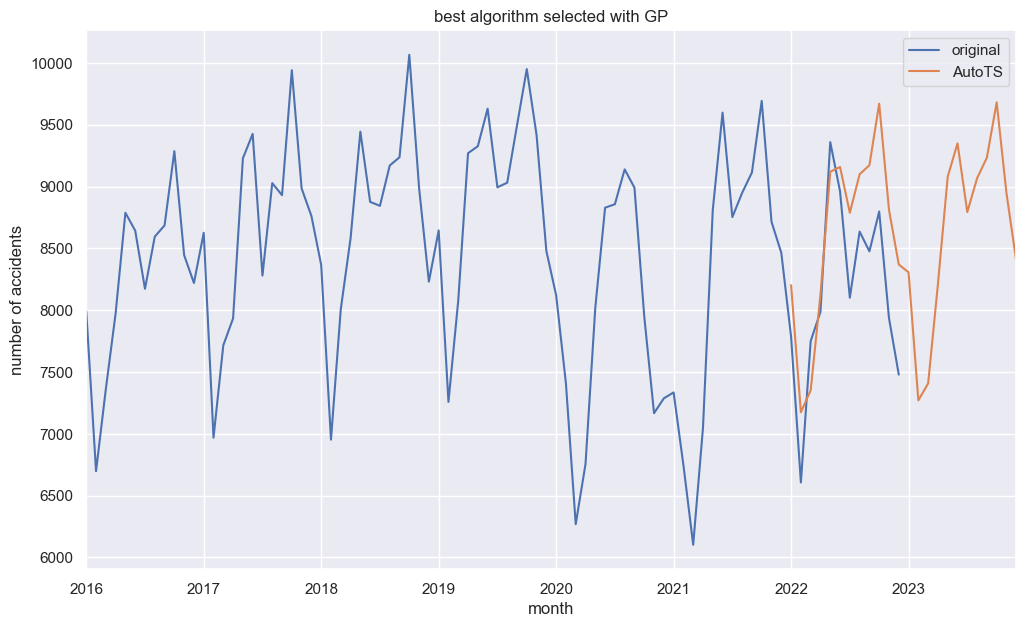

In [322]:
# add results to monthly_predict_df
monthly_predict_df['AutoTS'] = [np.nan] * len(monthly_count_train) + list(forecast['predicted'])

# plot the results
monthly_predict_df[['original', 'AutoTS']].plot()
plt.title("best algorithm selected with GP")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [323]:
model_monthly.results()

ID               Model  \
0     a5011ac9e6732f42c9dc1acd56af4863               ARIMA   
1     5e75ed52611fa9266c855f5876eb8720   AverageValueNaive   
2     8de2cf9b1bd66e9926258f9c3f304652   AverageValueNaive   
3     d8bd60351c03557d2b76a1f72be762ff   AverageValueNaive   
4     09bde45742341c9d5dca1ebfd50861a1  DatepartRegression   
...                                ...                 ...   
1875  6bdfc0e7c84caed2a850b01be9217bf7            Ensemble   
1876  41b65be2271dbea22e1926e590b9a7d7            Ensemble   
1877  41b65be2271dbea22e1926e590b9a7d7            Ensemble   
1878  3c18b60c287313ef53cae8f8e2c1347b            Ensemble   
1879  db23968bb80eaa9caa92fa7387c146a6            Ensemble   

                                        ModelParameters  \
0     {"p": 4, "d": 0, "q": 12, "regression_type": n...   
1                    {"method": "Mean", "window": null}   
2                    {"method": "Mean", "window": null}   
3                    {"method": "Mean", "window": null}   
4     {"regression_model": {"model": "DecisionTree",...   
...                                                 ...   
1875  {"model_name": "BestN", "model_count": 5, "mod...   
1876  {"model_name": "Dist", "model_count": 2, "mode...   
1877  {"model_name": "Dist", "model_count": 2, "mode...   
1878  {"model_name": "BestN", "model_count": 3, "mod...   
1879  {"model_name": "BestN", "model_count": 3, "mod...   

                               TransformationParameters  \
0     {"fillna": "cubic", "transformations": {"0": "...   
1     {"fillna": "fake_date", "transformations": {"0...   
2     {"fillna": "mean", "transformations": {"0": "C...   
3     {"fillna": "rolling_mean_24", "transformations...   
4     {"fillna": "mean", "transformations": {"0": "C...   
...                                                 ...   
1875                                                 {}   
1876                                                 {}   
1877                                                 {}   
1878                                                 {}   
1879                                                 {}   

      TransformationRuntime             FitRuntime         PredictRuntime  \
0    0 days 00:00:00.012965        0 days 00:00:00 0 days 00:00:03.775973   
1    0 days 00:00:00.036013 0 days 00:00:00.000998 0 days 00:00:00.001995   
2    0 days 00:00:00.047978 0 days 00:00:00.000997 0 days 00:00:00.001996   
3    0 days 00:00:00.029021 0 days 00:00:00.000998 0 days 00:00:00.001994   
4    0 days 00:00:00.026532        0 days 00:00:00 0 days 00:00:00.065961   
...                     ...                    ...                    ...   
1875        0 days 00:00:00 0 days 00:00:01.630804 0 days 00:00:00.001994   
1876        0 days 00:00:00 0 days 00:00:00.868814        0 days 00:00:00   
1877        0 days 00:00:00 0 days 00:00:00.843877        0 days 00:00:00   
1878        0 days 00:00:00 0 days 00:00:00.782056 0 days 00:00:00.003990   
1879        0 days 00:00:00 0 days 00:00:00.742136 0 days 00:00:00.004988   

               TotalRuntime  Ensemble Exceptions  ...  contour_weighted  \
0    0 days 00:00:03.807962         0        NaN  ...          0.583333   
1    0 days 00:00:00.054988         0        NaN  ...          0.583333   
2    0 days 00:00:00.065006         0        NaN  ...          0.416667   
3    0 days 00:00:00.047970         0        NaN  ...          0.583333   
4    0 days 00:00:00.129965         0        NaN  ...          0.833333   
...                     ...       ...        ...  ...               ...   
1875 0 days 00:00:01.676808         1        NaN  ...          0.833333   
1876 0 days 00:00:00.900729         1        NaN  ...          0.916667   
1877 0 days 00:00:00.863825         1        NaN  ...          0.916667   
1878 0 days 00:00:00.814969         1        NaN  ...          0.833333   
1879 0 days 00:00:00.771063         1        NaN  ...          0.833333   

      maxe_weighted  oda_weighted dwae_weighted

In [123]:
model_daily = AutoTS(forecast_length=30)
model_daily = model_daily.fit(daily_count_train, date_col='ds', value_col='y', id_col=None)

Inferred frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
68/68 [==============================] - 9s 8ms/step - loss: 0.3625
Epoch 2/50
68/68 [==============================] - 1s 8ms/step - loss: 0.2985
Epoch 3/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2850
Epoch 4/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2700
Epoch 5/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2588
Epoch 6/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2598
Epoch 7/50
68/68 [==============================] - 1s 8ms/step - loss: 0.2560
Epoch 8/50
68/68 [==============================] - 1s 9ms/step - loss: 0.2552
Epoch 9/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2528
Epoch 10/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2482
Epoch 11/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2443
Epoch 12/50
68/68 [==============================] - 1s 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 36 with model FBProphet in generation 0 of 10


02:54:26 - cmdstanpy - INFO - Chain [1] start processing
02:54:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

02:54:37 - cmdstanpy - INFO - Chain [1] start processing
02:54:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Model Number: 61 with model ARCH in generation 0 of 10
Model Number: 62 with model ConstantNaive in generation 0 of 10
Model Number: 63 with model LastValueNaive in generation 0 of 10
Model Number: 64 with model AverageValueNaive in generation 0 of 10
Model Number: 65 with model GLS in generation 0 of 10
Model Number: 66 with model SeasonalNaive in generation 0 of 10
Model Number: 67 with model GLM in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 68 with model ETS in generation 0 of 10
Model Number: 69 with model FBProphet in generation 0 of 10


02:54:43 - cmdstanpy - INFO - Chain [1] start processing
02:54:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 74 in generation 0: ARIMA
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 106 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'cffilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: ETS
Model Number: 107 with model UnobservedComponents in generation 0 of 10
Model Number: 108 with model NVAR in generation 0 of 10
Model Number: 109 with model Gluo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 113 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 113 in generation 0: VAR
Model Number: 114 with model ETS in generation 0 of 10
Model Number: 115 with model ETS in generation 0 of 10
Model Number: 116 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 116 in generation 0: UnobservedComponents
Model Number: 117 with model ETS in generation 0 of 10
Model Number: 118 with model SeasonalNaive in generation 0 of 10
Model Number: 119 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 119 in generation 0: ARIMA
Model Number: 120 with model SeasonalNaive in generation 0 of 10
Model Number: 121 with model GLS in generation 0 of 10
Model Number: 122 with model UnivariateMotif in generation 0 of 10
Model Number: 123 with model V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+01, tolerance: 3.846e-03
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: ETS
Model Number: 140 with model ConstantNaive in generation 0 of 10
Model Number: 141 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 141 in generation 0: MultivariateRegression
Model Number: 142 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 142 in generation 0: VAR
Model Number: 143 with model NVAR in generation 0 of 10
Model Number: 144 with model SeasonalNaive in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 144 in generation 0: SeasonalNaive
Model Number: 145 with model LastValueNaive in generation 0 of 10
Model Number: 146 with model LastValueNaive in generation 0 of 10
Model Number: 147 with model FBProphet in generation 0 of 10


02:55:13 - cmdstanpy - INFO - Chain [1] start processing
02:55:13 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 148 with model LastValueNaive in generation 0 of 10
Model Number: 149 with model SeasonalNaive in generation 0 of 10
Model Number: 150 with model NVAR in generation 0 of 10
Model Number: 151 with model MultivariateRegression in generation 0 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 151 in generation 0: MultivariateRegression
Model Number: 152 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 152 in generation 0: VECM
Model Number: 153 with model NVAR in generation 0 of 10
Model Number: 154 with model AverageValueNaive in generation 0 of 10
Model Number: 155 with model ARCH in generation 0 of 10
M

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 173 with model MultivariateMotif in generation 0 of 10
Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model ARDL in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 175 in generation 0: ARDL
Model Number: 176 with model DatepartRegression in generation 0 of 10
Model Number: 177 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 177 in generation 0: UnobservedComponents
Model Number: 178 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 178 in generation 0: UnobservedComponents
Model Number: 179 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 179 in gen

02:55:27 - cmdstanpy - INFO - Chain [1] start processing
02:55:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 192 with model GLM in generation 1 of 10
Model Number: 193 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 194 with model DatepartRegression in generation 1 of 10
Epoch 1/50
68/68 [==============================] - 8s 7ms/step - loss: 0.0472
Epoch 2/50
68/68 [==============================] - 1s 8ms/step - loss: 0.0336
Epoch 3/50
68/68 [==============================] - 1s 8ms/step - loss: 0.0320
Epoch 4/50
68/68 [==============================] - 1s 9ms/step - loss: 0.0314
Epoch 5/50
68/68 [==============================] - 1s 10ms/step - loss: 0.0311
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 7/50
68/68 [==============================] - 1s 11ms/step - loss: 0.0302
Epoch 8/50
68/68 [==============

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 200 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 200 in generation 1: DatepartRegression
Model Number: 201 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 201 in generation 1: ETS
Model Number: 202 with model AverageValueNaive in generation 1 of 10
Model Number: 203 with model SectionalMotif in generation 1 of 10
Model Number: 204 with model MultivariateMotif in generation 1 of 10
Model Number: 205 with model UnobservedComponents in generation 1 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 205 in generation 1: Unobserv

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 221 with model DatepartRegression in generation 1 of 10
Model Number: 222 with model ARDL in generation 1 of 10
Model Number: 223 with model MultivariateMotif in generation 1 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 223 in generation 1: MultivariateMotif
Model Number: 224 with model ETS in generation 1 of 10
Model Number: 225 with model MetricMotif in generation 1 of 10
Model Number: 226 with model UnivariateMotif in generation 1 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 226 in generation 1: UnivariateMotif
Model Number: 227 with model SectionalMotif in generation 1 of 10
Model Number: 228 with model DatepartRegression in generation 1 of 10
Model Number: 229 with model GLS in generation 1 of 10
Model Number: 230 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 231 with model AverageValueNaive in generation 1 of 10
Model Number: 232 with model SectionalMotif in generation 1 of 10
Model Number: 233 with model GLS in generation 1 of 10
Model Number: 234 with model ARIMA in generation 1 of 10
Model Number: 235 with model AverageValueNaive in generation 1 of 10
Model Number: 236 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 236 in generation 1: DatepartRegression
Model Number: 237 with model MultivariateMotif in generation 1 of 10
Model Number: 238 with model MultivariateMotif in generation 1 of 10
Model Number: 239 with model Theta in generation 1 of 10
Model Number: 240 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 240 in generation 1: DatepartRegression
Model Number: 241 with model AverageValueNaive in generation 1 of 10
Mode

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.06952e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 252 with model MultivariateRegression in generation 1 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[tweedie]: at least one target label is negative') in model 252 in generation 1: MultivariateRegression
Model Number: 253 with model UnobservedComponents in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 253 in generation 1: UnobservedComponents
Model Number: 254 with model GLM in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 255 with model ConstantNaive in generation 1 of 10
Model Number: 256 with model ARCH in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.472e+00, tolerance: 2.961e-03
  model = cd_fast.enet_coordinate_descent(


Model Number: 257 with model FBProphet in generation 1 of 10


02:58:22 - cmdstanpy - INFO - Chain [1] start processing
02:58:23 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 258 with model LastValueNaive in generation 1 of 10
Model Number: 259 with model AverageValueNaive in generation 1 of 10
Model Number: 260 with model UnivariateMotif in generation 1 of 10
Model Number: 261 with model MultivariateMotif in generation 1 of 10
Model Number: 262 with model UnivariateMotif in generation 1 of 10
Model Number: 263 with model ETS in generation 1 of 10
Model Number: 264 with model SectionalMotif in generation 1 of 10
Model Number: 265 with model MultivariateRegression in generation 1 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 265 in generation 1: MultivariateRegression
Model Number: 266 with model GLS in generation 1 of 10
Model Number: 267 with model LastValueNaive in generation 1 of 10
Model Number: 268 with model LastValueNaive in generation 1 of 10
Model Number: 269 with model GLM in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 270 with model AverageValueNaive in generation 1 of 10
Model Number: 271 with model DatepartRegression in generation 1 of 10
Epoch 1/100
68/68 [==============================] - 16s 125ms/step - loss: 25.9923
Epoch 2/100
68/68 [==============================] - 8s 111ms/step - loss: 25.8725
Epoch 3/100
68/68 [==============================] - 6s 94ms/step - loss: 25.8527
Epoch 4/100
68/68 [==============================] - 6s 93ms/step - loss: 25.8544
Epoch 5/100
68/68 [==============================] - 6s 93ms/step - loss: 25.8525
Epoch 6/100
68/68 [==============================] - 6s 94ms/step - loss: 25.8614
Epoch 7/100
68/68 [==============================] - 6s 93ms/step - loss: 25.8508
Epoch 8/100
68/68 [==============================] - 7s 96ms/step - loss: 25.8591
Epoch 9/100
68/68 [==============================] - 6s 93ms/step - loss: 25.8619
Epoch 10/100
68/68 [==============================] - 6s 94ms/step - loss: 25.8557
Epoch 11/100
68/68 [=================

68/68 [==============================] - 6s 94ms/step - loss: 25.8162
Epoch 99/100
68/68 [==============================] - 6s 93ms/step - loss: 25.8169
Epoch 100/100
1/1 [==============================] - 3s 3s/step
Model Number: 272 with model GLS in generation 1 of 10
Model Number: 273 with model UnivariateMotif in generation 1 of 10
Model Number: 274 with model DatepartRegression in generation 1 of 10
Model Number: 275 with model ARDL in generation 1 of 10
Model Number: 276 with model DatepartRegression in generation 1 of 10
Model Number: 277 with model UnivariateMotif in generation 1 of 10
Model Number: 278 with model MetricMotif in generation 1 of 10
Model Number: 279 with model UnobservedComponents in generation 1 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 279 in generation 1: UnobservedComponents
Model Number: 280 with model ETS in generation 1 of 10
Model Number: 281 with model GLM in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 282 with model SeasonalNaive in generation 1 of 10
Model Number: 283 with model GLS in generation 1 of 10
Model Number: 284 with model NVAR in generation 1 of 10
Model Number: 285 with model SeasonalNaive in generation 1 of 10
Model Number: 286 with model GLM in generation 1 of 10
Model Number: 287 with model MultivariateRegression in generation 1 of 10
Model Number: 288 with model FBProphet in generation 1 of 10
No anomalies detected.


03:09:53 - cmdstanpy - INFO - Chain [1] start processing
03:09:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 289 with model UnivariateMotif in generation 1 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 289 in generation 1: UnivariateMotif
Model Number: 290 with model GLS in generation 1 of 10
Model Number: 291 with model SeasonalNaive in generation 1 of 10
Model Number: 292 with model GLS in generation 1 of 10
Model Number: 293 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 294 with model Theta in generation 1 of 10
Model Number: 295 with model MetricMotif in generation 1 of 10
Model Number: 296 with model SeasonalNaive in generation 1 of 10
Model Number: 297 with model UnobservedComponents in generation 1 of 10
Model Number: 298 with model ETS in generation 1 of 10
Model Number: 299 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 300 with model ARCH in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 301 with model DatepartRegression in generation 1 of 10
Model Number: 302 with model SeasonalNaive in generation 1 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 302 in generation 1: SeasonalNaive
Model Number: 303 with model SectionalMotif in generation 1 of 10
Model Number: 304 with model FBProphet in generation 1 of 10


03:10:04 - cmdstanpy - INFO - Chain [1] start processing
03:10:04 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 305 with model ARDL in generation 1 of 10
Model Number: 306 with model UnobservedComponents in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 306 in generation 1: UnobservedComponents
Model Number: 307 with model LastValueNaive in generation 1 of 10
Model Number: 308 with model Theta in generation 1 of 10
Model Number: 309 with model SeasonalNaive in generation 1 of 10
Model Number: 310 with model SectionalMotif in generation 1 of 10
Model Number: 311 with model MultivariateMotif in generation 1 of 10
New Generation: 2 of 10
Model Number: 312 with model GLM in generation 2 of 10
Model Number: 313 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 313 in generation 2: DatepartRegression
Model Number: 314 with model SeasonalNaive in generation 2 of 10
Model Number: 315 with model UnivariateRegression in generation 2 of 10
Model Num

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 321 with model UnivariateMotif in generation 2 of 10
Model Number: 322 with model UnivariateRegression in generation 2 of 10
Model Number: 323 with model ConstantNaive in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.45341e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 324 with model SeasonalNaive in generation 2 of 10
Model Number: 325 with model DatepartRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Epoch 1/50
68/68 [==============================] - 8s 7ms/step - loss: 0.4139
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 0.3073
Epoch 3/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2900
Epoch 4/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2771
Epoch 5/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2615
Epoch 6/50
68/68 [==============================] - 1s 7ms/step - loss: 0.2546
Epoch 7/50
68/68 [==============================] - 1s 7ms/step - loss: 0.2514
Epoch 8/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2531
Epoch 9/50
68/68 [==============================] - 1s 8ms/step - loss: 0.2495
Epoch 10/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2416
Epoch 11/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2385
Epoch 12/50
68/68 [==============================] - 1s 7ms/step - loss: 0.2381
Epoch 13/50
68/68 [==============================

03:11:18 - cmdstanpy - INFO - Chain [1] start processing
03:11:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 327 with model GLS in generation 2 of 10
Model Number: 328 with model AverageValueNaive in generation 2 of 10
Model Number: 329 with model MultivariateRegression in generation 2 of 10
Model Number: 330 with model WindowRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 331 with model SeasonalNaive in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 332 with model ARDL in generation 2 of 10
Model Number: 333 with model ConstantNaive in generation 2 of 10
Model Number: 334 with model MetricMotif in generation 2 of 10
Model Number: 335 with model MultivariateRegression in generation 2 of 10
Model Number: 336 with model AverageValueNaive in generation 2 of 10
Model Number: 337 with model WindowRegression in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 337 in generation 2: WindowRegression
Model Number: 338 with model ETS in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 339 with model FBProphet in generation 2 of 10


03:12:12 - cmdstanpy - INFO - Chain [1] start processing
03:12:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 340 with model MultivariateRegression in generation 2 of 10
Model Number: 341 with model NVAR in generation 2 of 10
Model Number: 342 with model ARCH in generation 2 of 10
Model Number: 343 with model MultivariateMotif in generation 2 of 10
Model Number: 344 with model FBProphet in generation 2 of 10


03:12:17 - cmdstanpy - INFO - Chain [1] start processing
03:12:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 345 with model ETS in generation 2 of 10
Model Number: 346 with model UnobservedComponents in generation 2 of 10
Model Number: 347 with model ARDL in generation 2 of 10
Model Number: 348 with model MultivariateMotif in generation 2 of 10
Model Number: 349 with model ARCH in generation 2 of 10
Model Number: 350 with model MetricMotif in generation 2 of 10
Model Number: 351 with model ARDL in generation 2 of 10
Model Number: 352 with model WindowRegression in generation 2 of 10
Model Number: 353 with model MetricMotif in generation 2 of 10
Model Number: 354 with model MetricMotif in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 355 with model ARDL in generation 2 of 10
Model Number: 356 with model ETS in generation 2 of 10
Model Number: 357 with model MultivariateMotif in generation 2 of 10
Model Number: 358 with model FBProphet in generation 2 of 10


03:12:32 - cmdstanpy - INFO - Chain [1] start processing
03:12:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 359 with model DatepartRegression in generation 2 of 10
Model Number: 360 with model SectionalMotif in generation 2 of 10
Model Number: 361 with model MultivariateMotif in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 361 in generation 2: MultivariateMotif
Model Number: 362 with model DatepartRegression in generation 2 of 10
Model Number: 363 with model ARDL in generation 2 of 10
Model Number: 364 with model GLS in generation 2 of 10
Model Number: 365 with model AverageValueNaive in generation 2 of 10
Model Number: 366 with model GLM in generation 2 of 10
Model Number: 367 with model Theta in generation 2 of 10
Model Number: 368 with model SectionalMotif in generation 2 of 10
Model Number: 369 with model WindowRegression in generation 2 of 10
Model Number: 370 with model AverageValueNaive in generation 2 of 10
Model Number: 371 with model MultivariateRegression in generation 2 of 10
[LightGBM] [Warning] Auto-choosing

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:89: RuntimeWarning: invalid value encountered in divide
  w1 /= np.sqrt((w1**2).sum())
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 380 with model MultivariateMotif in generation 2 of 10
Model Number: 381 with model LastValueNaive in generation 2 of 10
Model Number: 382 with model FBProphet in generation 2 of 10


03:13:22 - cmdstanpy - INFO - Chain [1] start processing
03:13:24 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 383 with model GLM in generation 2 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 383 in generation 2: GLM
Model Number: 384 with model AverageValueNaive in generation 2 of 10
Model Number: 385 with model UnobservedComponents in generation 2 of 10
Model Number: 386 with model MetricMotif in generation 2 of 10
Model Number: 387 with model MetricMotif in generation 2 of 10
Model Number: 388 with model FBProphet in generation 2 of 10


03:13:27 - cmdstanpy - INFO - Chain [1] start processing
03:13:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 389 with model LastValueNaive in generation 2 of 10
Model Number: 390 with model UnivariateMotif in generation 2 of 10
Model Number: 391 with model ETS in generation 2 of 10
Model Number: 392 with model ETS in generation 2 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 393 with model DatepartRegression in generation 2 of 10
Model Number: 394 with model Theta in generation 2 of 10
Model Number: 395 with model WindowRegression in generation 2 of 10
Model Number: 396 with model SectionalMotif in generation 2 of 10
Model Number: 397 with model UnivariateMotif in generation 2 of 10
Model Number: 398 with model MultivariateMotif in generation 2 of 10
Model Number: 399 with model DatepartRegression in generation 2 of 10
Epoch 1/50
68/68 [==============================] - 7s 7ms/step - loss: 14989.0977
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 3935

03:14:34 - cmdstanpy - INFO - Chain [1] start processing
03:14:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 405 with model LastValueNaive in generation 2 of 10
Model Number: 406 with model AverageValueNaive in generation 2 of 10
Model Number: 407 with model ARDL in generation 2 of 10
Model Number: 408 with model SectionalMotif in generation 2 of 10
Model Number: 409 with model SectionalMotif in generation 2 of 10
Model Number: 410 with model DatepartRegression in generation 2 of 10
Model Number: 411 with model ARIMA in generation 2 of 10
Model Number: 412 with model GLS in generation 2 of 10
Model Number: 413 with model SectionalMotif in generation 2 of 10
Model Number: 414 with model UnivariateRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.22968e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 415 with model ETS in generation 2 of 10
Model Number: 416 with model UnivariateMotif in generation 2 of 10
Model Number: 417 with model UnivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 417 in generation 2: UnivariateRegression
Model Number: 418 with model AverageValueNaive in generation 2 of 10
Model Number: 419 with model MultivariateMotif in generation 2 of 10
Model Number: 420 with model ARCH in generation 2 of 10
Model Number: 421 with model FBProphet in generation 2 of 10


03:14:56 - cmdstanpy - INFO - Chain [1] start processing
03:14:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 422 with model GLS in generation 2 of 10
Model Number: 423 with model UnobservedComponents in generation 2 of 10
Model Number: 424 with model ARIMA in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 424 in generation 2: ARIMA
Model Number: 425 with model MultivariateRegression in generation 2 of 10
Model Number: 426 with model UnobservedComponents in generation 2 of 10
Model Number: 427 with model ETS in generation 2 of 10
Model Number: 428 with model NVAR in generation 2 of 10
Model Number: 429 with model DatepartRegression in generation 2 of 10
Epoch 1/50
68/68 [==============================] - 9s 6ms/step - loss: 0.1706
Epoch 2/50
68/68 [==============================] - 1s 9ms/step - loss: 0.1430
Epoch 3/50
68/68 [==============================] - 1s 8ms/step - loss: 0.1364
Epoch 4/50
68/68 [==============================] - 1s 8ms/step - loss: 0.1301
Epoch 5/50
68/68 [===========================

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 453 with model ETS in generation 3 of 10
Model Number: 454 with model DatepartRegression in generation 3 of 10
Model Number: 455 with model SectionalMotif in generation 3 of 10
Model Number: 456 with model NVAR in generation 3 of 10
Model Number: 457 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 457 in generation 3: MultivariateRegression
Model Number: 458 with model WindowRegression in generation 3 of 10
Model Number: 459 with model ARDL in generation 3 of 10
Model Number: 460 with model ARDL in generation 3 of 10
Model Number: 461 with model MetricMotif in generation 3 of 10
Model Number: 462 with model SeasonalNaive in generation 3 of 10
Model Number: 463 with model MultivariateMotif in generation 3 of 10
Model Number: 464 with model MultivariateMotif in generation 3 of 10
Model Number: 465 with model MultivariateRegression in generation 3 of 10
Model Number: 466 with model Multivari

03:17:10 - cmdstanpy - INFO - Chain [1] start processing
03:17:11 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 469 with model ARDL in generation 3 of 10
Model Number: 470 with model ARCH in generation 3 of 10
Model Number: 471 with model DatepartRegression in generation 3 of 10
Model Number: 472 with model GLS in generation 3 of 10
Model Number: 473 with model UnobservedComponents in generation 3 of 10
Model Number: 474 with model ARIMA in generation 3 of 10
Model Number: 475 with model UnivariateMotif in generation 3 of 10
Model Number: 476 with model FBProphet in generation 3 of 10


03:17:15 - cmdstanpy - INFO - Chain [1] start processing
03:17:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 477 with model LastValueNaive in generation 3 of 10
Model Number: 478 with model SectionalMotif in generation 3 of 10
Model Number: 479 with model MetricMotif in generation 3 of 10
Model Number: 480 with model DatepartRegression in generation 3 of 10
Epoch 1/50
68/68 [==============================] - 5s 5ms/step - loss: 2153.4131
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 4055.5708
Epoch 3/50
68/68 [==============================] - 0s 7ms/step - loss: 3732.5920
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 3405.1001
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 5412.7803
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 1423.2285
Epoch 7/50
68/68 [==============================] - 0s 7ms/step - loss: 9039.4746
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 1573.0814
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 3483.23

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 483 with model ARDL in generation 3 of 10
Model Number: 484 with model UnobservedComponents in generation 3 of 10
HolidayTransformer: no anomalies detected.
Model Number: 485 with model DatepartRegression in generation 3 of 10
Model Number: 486 with model UnivariateMotif in generation 3 of 10
Model Number: 487 with model ARIMA in generation 3 of 10
Model Number: 488 with model MultivariateMotif in generation 3 of 10
Model Number: 489 with model LastValueNaive in generation 3 of 10
Model Number: 490 with model DatepartRegression in generation 3 of 10
Model Number: 491 with model Theta in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.932e+01, tolerance: 1.803e-02
  model = cd_fast.enet_coordinate_descent(


Model Number: 492 with model UnivariateMotif in generation 3 of 10
Model Number: 493 with model LastValueNaive in generation 3 of 10
Model Number: 494 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 495 with model GLM in generation 3 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 495 in generation 3: GLM
Model Number: 496 with model UnobservedComponents in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 497 with model SectionalMotif in generation 3 of 10
Model Number: 498 with model ETS in generation 3 of 10
Model Number: 499 with model SectionalMotif in generation 3 of 10
Model Number: 500 with model SectionalMotif in generation 3 of 10
Model Number: 501 with model UnobservedComponents in generation 3 of 10
Model Number: 502 with model MetricMotif in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
C:\Users\katka\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Model Number: 503 with model UnobservedComponents in generation 3 of 10
Model Number: 504 with model ConstantNaive in generation 3 of 10
Model Number: 505 with model FBProphet in generation 3 of 10


03:18:20 - cmdstanpy - INFO - Chain [1] start processing
03:18:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 506 with model UnivariateMotif in generation 3 of 10
Model Number: 507 with model MultivariateRegression in generation 3 of 10
Model Number: 508 with model SeasonalNaive in generation 3 of 10
Model Number: 509 with model Theta in generation 3 of 10
Model Number: 510 with model DatepartRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 510 in generation 3: DatepartRegression
Model Number: 511 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 512 with model DatepartRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 512 in generation 3: DatepartRegression
Model Number: 513 with model UnivariateMotif in generation 3 of 10
Model Number: 514 with model MetricMotif in generation 3 of 10
Model Number: 515 with model AverageValueNaive in generation 3 of 10
Model Number: 516 with model WindowRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 517 with model GLS in generation 3 of 10
Model Number: 518 with model MultivariateMotif in generation 3 of 10
Model Number: 519 with model ARDL in generation 3 of 10
Model Number: 520 with model MultivariateMotif in generation 3 of 10
Model Number: 521 with model SeasonalNaive in generation 3 of 10
Model Number: 522 with model ARDL in generation 3 of 10
Model Number: 523 with model SectionalMotif in generation 3 of 10
Model Number: 524 with model MultivariateRegression in generation 3 of 10
Model Number: 525 with model FBProphet in generation 3 of 10


03:18:42 - cmdstanpy - INFO - Chain [1] start processing
03:18:43 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 526 with model NVAR in generation 3 of 10
Model Number: 527 with model FBProphet in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 527 in generation 3: FBProphet
Model Number: 528 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 529 with model UnivariateRegression in generation 3 of 10
Model Number: 530 with model ARDL in generation 3 of 10
Model Number: 531 with model NVAR in generation 3 of 10
Model Number: 532 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 532 in generation 3: MultivariateRegression
Model Number: 533 with model UnobservedComponents in generation 3 of 10
Model Number: 534 with model FBProphet in generation 3 of 10


03:18:48 - cmdstanpy - INFO - Chain [1] start processing
03:18:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 535 with model GLM in generation 3 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 536 with model FBProphet in generation 3 of 10


03:18:51 - cmdstanpy - INFO - Chain [1] start processing
03:18:52 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 537 with model UnivariateRegression in generation 3 of 10
Model Number: 538 with model UnivariateMotif in generation 3 of 10
Model Number: 539 with model ARDL in generation 3 of 10
Model Number: 540 with model DatepartRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 541 with model LastValueNaive in generation 3 of 10
Model Number: 542 with model ARDL in generation 3 of 10
Model Number: 543 with model FBProphet in generation 3 of 10


03:19:04 - cmdstanpy - INFO - Chain [1] start processing
03:19:05 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 544 with model GLS in generation 3 of 10
HolidayTransformer: no anomalies detected.
Model Number: 545 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\stats

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 545 in generation 3: GLM
Model Number: 546 with model GLM in generation 3 of 10
Model Number: 547 with model MetricMotif in generation 3 of 10
Model Number: 548 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 548 in generation 3: GLM
Model Number: 549 with model ETS in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: divide by zero encountered in divide
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 550 with model ConstantNaive in generation 3 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 550 in generation 3: ConstantNaive
Model Number: 551 with model DatepartRegression in generation 3 of 10
Model Number: 552 with model Theta in generation 3 of 10
Model Number: 553 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 553 in generation 3: MultivariateRegression
Model Number: 554 with model MultivariateRegression in generation 3 of 10
Model Number: 555 with model FBProphet in generation 3 of 10


03:19:28 - cmdstanpy - INFO - Chain [1] start processing
03:19:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 556 with model LastValueNaive in generation 3 of 10
Model Number: 557 with model MetricMotif in generation 3 of 10
Model Number: 558 with model AverageValueNaive in generation 3 of 10
Model Number: 559 with model GLM in generation 3 of 10
Model Number: 560 with model MultivariateMotif in generation 3 of 10
Model Number: 561 with model GLS in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


New Generation: 4 of 10
Model Number: 562 with model MultivariateRegression in generation 4 of 10
Model Number: 563 with model MultivariateMotif in generation 4 of 10
Model Number: 564 with model MultivariateRegression in generation 4 of 10
Model Number: 565 with model GLS in generation 4 of 10
Model Number: 566 with model NVAR in generation 4 of 10
Model Number: 567 with model UnivariateMotif in generation 4 of 10
Model Number: 568 with model MetricMotif in generation 4 of 10
Model Number: 569 with model MultivariateMotif in generation 4 of 10
Model Number: 570 with model SectionalMotif in generation 4 of 10
Model Number: 571 with model FBProphet in generation 4 of 10


03:19:58 - cmdstanpy - INFO - Chain [1] start processing
03:19:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 572 with model MultivariateMotif in generation 4 of 10
Model Number: 573 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 573 in generation 4: DatepartRegression
Model Number: 574 with model UnobservedComponents in generation 4 of 10
HolidayTransformer: no anomalies detected.
Model Number: 575 with model ARDL in generation 4 of 10
Model Number: 576 with model WindowRegression in generation 4 of 10
Model Number: 577 with model ARDL in generation 4 of 10
Model Number: 578 with model Theta in generation 4 of 10
Model Number: 579 with model ARDL in generation 4 of 10
Model Number: 580 with model MultivariateRegression in generation 4 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 581 with model LastValueNaive in generation 4 of 10
Model Numb

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 586 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 587 with model NVAR in generation 4 of 10
Model Number: 588 with model GLS in generation 4 of 10
HolidayTransformer: no anomalies detected.
Model Number: 589 with model GLS in generation 4 of 10
Model Number: 590 with model GLM in generation 4 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 590 in generation 4: GLM
Model Number: 591 with model ETS in generation 4 of 10
Model Number: 592 with model DatepartRegression in generation 4 of 10
Model Number: 593 with model ARDL in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 594 with model MultivariateMotif in generation 4 of 10
Model Number: 595 with model MetricMotif in generation 4 of 10
Model Number: 596 with model UnivariateRegression in generation 4 of 10
Model Number: 597 with model SeasonalNaive in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 598 with model UnobservedComponents in generation 4 of 10
Model Number: 599 with model FBProphet in generation 4 of 10


03:20:19 - cmdstanpy - INFO - Chain [1] start processing
03:20:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 600 with model SeasonalNaive in generation 4 of 10
Model Number: 601 with model SectionalMotif in generation 4 of 10
Model Number: 602 with model GLM in generation 4 of 10
Model Number: 603 with model UnivariateMotif in generation 4 of 10
Model Number: 604 with model AverageValueNaive in generation 4 of 10
Model Number: 605 with model Theta in generation 4 of 10
Model Number: 606 with model WindowRegression in generation 4 of 10
Model Number: 607 with model MetricMotif in generation 4 of 10
Model Number: 608 with model Theta in generation 4 of 10
Model Number: 609 with model ARCH in generation 4 of 10
Model Number: 610 with model MultivariateMotif in generation 4 of 10
Model Number: 611 with model MultivariateMotif in generation 4 of 10
Model Number: 612 with model UnivariateMotif in generation 4 of 10
Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 612 in generation 4: UnivariateMotif
Model 

C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
03:20:27 - cmdstanpy - INFO - Chain [1] start processing
03:20:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 614 with model SeasonalNaive in generation 4 of 10
Model Number: 615 with model LastValueNaive in generation 4 of 10
Model Number: 616 with model DatepartRegression in generation 4 of 10
Epoch 1/50
68/68 [==============================] - 10s 16ms/step - loss: 24.1017
Epoch 2/50
68/68 [==============================] - 1s 20ms/step - loss: 24.0988
Epoch 3/50
68/68 [==============================] - 1s 17ms/step - loss: 24.0962
Epoch 4/50
68/68 [==============================] - 1s 13ms/step - loss: 24.0976
Epoch 5/50
68/68 [==============================] - 1s 17ms/step - loss: 24.0959
Epoch 6/50
68/68 [==============================] - 1s 18ms/step - loss: 24.0969
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 24.0957
Epoch 8/50
68/68 [==============================] - 1s 15ms/step - loss: 24.0970
Epoch 9/50
68/68 [==============================] - 1s 17ms/step - loss: 24.0967
Epoch 10/50
68/68 [==============================] - 1s 17ms/step - l

03:21:55 - cmdstanpy - INFO - Chain [1] start processing
03:21:56 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 624 with model MultivariateMotif in generation 4 of 10
Model Number: 625 with model MetricMotif in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 625 in generation 4: MetricMotif
Model Number: 626 with model MetricMotif in generation 4 of 10
Model Number: 627 with model ETS in generation 4 of 10
Model Number: 628 with model WindowRegression in generation 4 of 10
Model Number: 629 with model MultivariateMotif in generation 4 of 10
Model Number: 630 with model SectionalMotif in generation 4 of 10
Model Number: 631 with model FBProphet in generation 4 of 10


03:21:59 - cmdstanpy - INFO - Chain [1] start processing
03:22:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 632 with model Theta in generation 4 of 10
Model Number: 633 with model ETS in generation 4 of 10
Model Number: 634 with model ConstantNaive in generation 4 of 10
Model Number: 635 with model ARIMA in generation 4 of 10
Model Number: 636 with model WindowRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 637 with model FBProphet in generation 4 of 10


03:25:45 - cmdstanpy - INFO - Chain [1] start processing
03:25:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 638 with model GLS in generation 4 of 10
Model Number: 639 with model GLS in generation 4 of 10
Model Number: 640 with model DatepartRegression in generation 4 of 10
Model Number: 641 with model FBProphet in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
03:25:49 - cmdstanpy - INFO - Chain [1] start processing
03:25:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 642 with model ARIMA in generation 4 of 10
Model Number: 643 with model SeasonalNaive in generation 4 of 10
Model Number: 644 with model SeasonalNaive in generation 4 of 10
Model Number: 645 with model LastValueNaive in generation 4 of 10
Model Number: 646 with model DatepartRegression in generation 4 of 10
Model Number: 647 with model LastValueNaive in generation 4 of 10
Model Number: 648 with model SectionalMotif in generation 4 of 10
Model Number: 649 with model FBProphet in generation 4 of 10


03:25:57 - cmdstanpy - INFO - Chain [1] start processing
03:25:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 650 with model FBProphet in generation 4 of 10


03:25:59 - cmdstanpy - INFO - Chain [1] start processing
03:25:59 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 651 with model ARDL in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 651 in generation 4: ARDL
Model Number: 652 with model ARDL in generation 4 of 10
Model Number: 653 with model MetricMotif in generation 4 of 10
Model Number: 654 with model SectionalMotif in generation 4 of 10
Model Number: 655 with model GLM in generation 4 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 655 in generation 4: GLM
Model Number: 656 with model UnivariateMotif in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:318: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:740: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.v

Model Number: 657 with model NVAR in generation 4 of 10
Model Number: 658 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 659 with model LastValueNaive in generation 4 of 10
Model Number: 660 with model UnivariateRegression in generation 4 of 10
Model Number: 661 with model ARDL in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.90006e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 662 with model MultivariateRegression in generation 4 of 10
Model Number: 663 with model SectionalMotif in generation 4 of 10
Model Number: 664 with model MetricMotif in generation 4 of 10
Model Number: 665 with model FBProphet in generation 4 of 10


03:26:07 - cmdstanpy - INFO - Chain [1] start processing
03:26:08 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 666 with model MultivariateRegression in generation 4 of 10
Model Number: 667 with model AverageValueNaive in generation 4 of 10
Model Number: 668 with model AverageValueNaive in generation 4 of 10
Model Number: 669 with model MultivariateRegression in generation 4 of 10
Model Number: 670 with model ConstantNaive in generation 4 of 10
Model Number: 671 with model UnivariateMotif in generation 4 of 10
Model Number: 672 with model SeasonalNaive in generation 4 of 10
Model Number: 673 with model ARCH in generation 4 of 10
Model Number: 674 with model ConstantNaive in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 674 in generation 4: ConstantNaive
Model Number: 675 with model MetricMotif in generation 4 of 10
Model Number: 676 with model WindowRegression in generation 4 of 10
Model Number: 677 with model NVAR in generation 4 of 10
Model Number: 678 with model ARCH in generation 4 of 10
Model Number: 679 with model A

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Model Number: 680 with model ARCH in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 680 in generation 4: ARCH
Model Number: 681 with model AverageValueNaive in generation 4 of 10
Model Number: 682 with model UnivariateMotif in generation 4 of 10
Model Number: 683 with model SectionalMotif in generation 4 of 10
Model Number: 684 with model LastValueNaive in generation 4 of 10
Model Number: 685 with model UnivariateMotif in generation 4 of 10
Model Number: 686 with model GLS in generation 4 of 10
New Generation: 5 of 10
Model Number: 687 with model ARIMA in generation 5 of 10
Model Number: 688 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 688 in generation 5: WindowRegression
Model Number: 689 with model DatepartRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 6

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.93959e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 697 with model NVAR in generation 5 of 10
Model Number: 698 with model UnivariateMotif in generation 5 of 10
Model Number: 699 with model UnobservedComponents in generation 5 of 10
Model Number: 700 with model SectionalMotif in generation 5 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 700 in generation 5: SectionalMotif
Model Number: 701 with model LastValueNaive in generation 5 of 10
Model Number: 702 with model MetricMotif in generation 5 of 10
Model Number: 703 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 704 with model MultivariateRegression in generation 5 of 10
Model Number: 705 with model MetricMotif in generation 5 of 10
Model Number: 706 with model SeasonalNaive in generation 5 of 10
Model Number: 707 with model LastValueNaive in generation 5 of 10
Model Number: 708 with model MultivariateMotif in generation 5 of 10
Model Number: 709 with model MetricMotif in generation 5 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 709 in generation 5: MetricMotif
Model Number: 710 with model UnivariateMotif in generation 5 of 10
Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 710 in generation 5: UnivariateMotif
Model Number: 711 with model UnobservedComponents in generation 5 of 10
Model Number: 712 with model AverageValueNaive in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:583: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")
C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Model Number: 713 with model ARDL in generation 5 of 10
Model Number: 714 with model FBProphet in generation 5 of 10


03:30:08 - cmdstanpy - INFO - Chain [1] start processing
03:30:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 715 with model FBProphet in generation 5 of 10


03:30:11 - cmdstanpy - INFO - Chain [1] start processing
03:30:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 716 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 717 with model GLM in generation 5 of 10
Model Number: 718 with model MultivariateMotif in generation 5 of 10
Model Number: 719 with model MetricMotif in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 720 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 720 in generation 5: WindowRegression
Model Number: 721 with model ARDL in generation 5 of 10
Model Number: 722 with model UnivariateRegression in generation 5 of 10
Model Number: 723 with model AverageValueNaive in generation 5 of 10
Model Number: 724 with model ARDL in generation 5 of 10
Model Number: 725 with model LastValueNaive in generation 5 of 10
Model Number: 726 with model DatepartRegression in generation 5 of 10
Model Number: 727 with model FBProphet in generation 5 of 10


03:30:25 - cmdstanpy - INFO - Chain [1] start processing
03:30:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 728 with model DatepartRegression in generation 5 of 10
Model Number: 729 with model UnivariateMotif in generation 5 of 10
Model Number: 730 with model DatepartRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 731 with model GLS in generation 5 of 10
Model Number: 732 with model MultivariateMotif in generation 5 of 10
Model Number: 733 with model FBProphet in generation 5 of 10


03:30:34 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 734 with model MultivariateRegression in generation 5 of 10
Model Number: 735 with model ARDL in generation 5 of 10
Model Number: 736 with model FBProphet in generation 5 of 10


03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:40 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 737 with model UnivariateRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 737 in generation 5: UnivariateRegression
Model Number: 738 with model ETS in generation 5 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 739 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 740 with model SectionalMotif in generation 5 of 10
Model Number: 741 with model UnobservedComponents in generation 5 of 10
Model Number: 742 with model MetricMotif in generation 5 of 10
Model Number: 743 with model UnivariateMotif in generation 5 of 10
Model Number: 744 with model MultivariateRegression in generation 5 of 10
Model Number: 745 with model Theta in generation 5 of 10
Model Number: 746 with model MetricMotif in generation 5 of 10
Model Number: 747 with model DatepartRegression in generation 5 of 10
Model Number: 748 with model MultivariateMotif in generation 5 of 10
Model Number: 749 with model FBProphet in generation 5 of 10


03:30:47 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 750 with model GLS in generation 5 of 10
Model Number: 751 with model GLS in generation 5 of 10
Model Number: 752 with model MultivariateMotif in generation 5 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 752 in generation 5: MultivariateMotif
Model Number: 753 with model FBProphet in generation 5 of 10


03:30:51 - cmdstanpy - INFO - Chain [1] start processing
03:30:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 754 with model SectionalMotif in generation 5 of 10
Model Number: 755 with model MultivariateMotif in generation 5 of 10
Model Number: 756 with model ETS in generation 5 of 10
Model Number: 757 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 758 with model SectionalMotif in generation 5 of 10
Model Number: 759 with model LastValueNaive in generation 5 of 10
Model Number: 760 with model WindowRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 761 with model ARCH in generation 5 of 10
Model Number: 762 with model SeasonalNaive in generation 5 of 10
HolidayTransformer: no anomalies detected.
Model Number: 763 with model MultivariateRegression in generation 5 of 10
Model Number: 764 with model MultivariateMotif in generation 5 of 10
Model Number: 765 with model MetricMotif in generation 5 of 10
Template Eval Error: IndexError('index 1525 is out of bounds for axis 0 with size 432') in model 765 in generation 5: MetricMotif
Model Number: 766 with model ARCH in generation 5 of 10
Template Eval Error: ValueError('shapes (1000,0) and (1,) not aligned: 0 (dim 1) != 1 (dim 0)') in model 766 in generation 5: ARCH
Model Number: 767 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 768 with model MultivariateMotif in generation 5 of 10
Model Number: 769 with model GLM in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 770 with model ARDL in generation 5 of 10
Model Number: 771 with model GLS in generation 5 of 10
Model Number: 772 with model UnivariateMotif in generation 5 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 772 in generation 5: UnivariateMotif
Model Number: 773 with model MultivariateRegression in generation 5 of 10
Model Number: 774 with model ARCH in generation 5 of 10
Model Number: 775 with model NVAR in generation 5 of 10
Model Number: 776 with model DatepartRegression in generation 5 of 10
Model Number: 777 with model GLM in generation 5 of 10
Model Number: 778 with model MetricMotif in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 779 with model MetricMotif in generation 5 of 10
Model Number: 780 with model ConstantNaive in generation 5 of 10
Model Number: 781 with model Theta in generation 5 of 10
Model Number: 782 with model SeasonalNaive in generation 5 of 10
Model Number: 783 with model LastValueNaive in generation 5 of 10
Model Number: 784 with model FBProphet in generation 5 of 10


03:31:31 - cmdstanpy - INFO - Chain [1] start processing
03:31:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 785 with model UnivariateMotif in generation 5 of 10
Model Number: 786 with model MetricMotif in generation 5 of 10
New Generation: 6 of 10
Model Number: 787 with model MultivariateRegression in generation 6 of 10
Model Number: 788 with model LastValueNaive in generation 6 of 10
Model Number: 789 with model MultivariateMotif in generation 6 of 10
Model Number: 790 with model LastValueNaive in generation 6 of 10
Model Number: 791 with model MetricMotif in generation 6 of 10
Model Number: 792 with model GLS in generation 6 of 10
Model Number: 793 with model DatepartRegression in generation 6 of 10
Model Number: 794 with model MultivariateMotif in generation 6 of 10
Model Number: 795 with model SectionalMotif in generation 6 of 10
Model Number: 796 with model AverageValueNaive in generation 6 of 10
Model Number: 797 with model FBProphet in generation 6 of 10
HolidayTransformer: no anomalies detected.


03:32:08 - cmdstanpy - INFO - Chain [1] start processing
03:32:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 798 with model GLS in generation 6 of 10
Model Number: 799 with model ARDL in generation 6 of 10
Model Number: 800 with model FBProphet in generation 6 of 10


03:32:12 - cmdstanpy - INFO - Chain [1] start processing
03:32:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 801 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 801 in generation 6: DatepartRegression
Model Number: 802 with model UnivariateMotif in generation 6 of 10
Model Number: 803 with model ARIMA in generation 6 of 10
Model Number: 804 with model NVAR in generation 6 of 10
Model Number: 805 with model MultivariateRegression in generation 6 of 10
Model Number: 806 with model DatepartRegression in generation 6 of 10
Model Number: 807 with model MetricMotif in generation 6 of 10
Model Number: 808 with model MetricMotif in generation 6 of 10
Model Number: 809 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 810 with model AverageValueNaive in generation 6 of 10
Model Number: 811 with model MultivariateRegression in generation 6 of 10
Model Number: 812 with model UnobservedComponents in generation 6 of 10
HolidayTransformer: no anomalies detected.
Model Number: 813 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 813 in generation 6: ETS
Model Number: 814 with model SeasonalNaive in generation 6 of 10
Model Number: 815 with model ARDL in generation 6 of 10
Model Number: 816 with model NVAR in generation 6 of 10
Model Number: 817 with model MultivariateMotif in generation 6 of 10
Model Number: 818 with model MultivariateMotif in generation 6 of 10
Template Eval Error: Excep

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 826 with model FBProphet in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
03:34:31 - cmdstanpy - INFO - Chain [1] start processing
03:34:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 827 with model MultivariateMotif in generation 6 of 10
Model Number: 828 with model UnivariateMotif in generation 6 of 10
Model Number: 829 with model GLS in generation 6 of 10
Model Number: 830 with model UnivariateMotif in generation 6 of 10
Model Number: 831 with model FBProphet in generation 6 of 10


03:34:35 - cmdstanpy - INFO - Chain [1] start processing
03:34:36 - cmdstanpy - INFO - Chain [1] done processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 831 in generation 6: FBProphet
Model Number: 832 with model MultivariateRegression in generation 6 of 10
Model Number: 833 with model SeasonalNaive in generation 6 of 10
Model Number: 834 with model MultivariateMotif in generation 6 of 10
Model Number: 835 with model MultivariateRegression in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 835 in generation 6: MultivariateRegression
Model Number: 836 with model GLS in generation 6 of 10
Model Number: 837 with model UnivariateMotif in generation 6 of 10
Model Number: 838 with model ARDL in generation 6 of 10
Model Number: 839 with model LastValueNaive in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 839 in generation 6: LastValueNaive
Model Number: 840 with model GLM in generation 6 of 10
Template Eval Error: Exception('Transformer Regre

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 849 with model FBProphet in generation 6 of 10


03:35:48 - cmdstanpy - INFO - Chain [1] start processing
03:35:49 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 850 with model MultivariateRegression in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 850 in generation 6: MultivariateRegression
Model Number: 851 with model UnivariateMotif in generation 6 of 10
Model Number: 852 with model WindowRegression in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 852 in generation 6: WindowRegression
Model Number: 853 with model MetricMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 854 with model GLM in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 855 with model GLS in generation 6 of 10
Model Number: 856 with model MultivariateRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 857 with model GLM in generation 6 of 10
Model Number: 858 with model MultivariateMotif in generation 6 of 10
Model Number: 859 with model MultivariateRegression in generation 6 of 10
Model Number: 860 with model GLM in generation 6 of 10
Model Number: 861 with model MultivariateMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 862 with model LastValueNaive in generation 6 of 10
Model Number: 863 with model GLM in generation 6 of 10
Model Number: 864 with model DatepartRegression in generation 6 of 10
Model Number: 865 with model LastValueNaive in generation 6 of 10
Model Number: 866 with model DatepartRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 866 in generation 6: DatepartRegression
Model Number: 867 with model GLS in generation 6 of 10
Model Number: 868 with model ARDL in generation 6 of 10
Model Number: 869 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 870 with model DatepartRegression in generation 6 of 10
Epoch 1/50
68/68 [==============================] - 11s 20ms/step 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 878 with model AverageValueNaive in generation 6 of 10
Model Number: 879 with model MetricMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 880 with model FBProphet in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
03:38:13 - cmdstanpy - INFO - Chain [1] start processing
03:38:15 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 881 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 881 in generation 6: WindowRegression
Model Number: 882 with model SectionalMotif in generation 6 of 10
Model Number: 883 with model LastValueNaive in generation 6 of 10
Model Number: 884 with model ETS in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 884 in generation 6: ETS
Model Number: 885 with model FBProphet in generation 6 of 10


03:38:18 - cmdstanpy - INFO - Chain [1] start processing
03:38:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 886 with model AverageValueNaive in generation 6 of 10
New Generation: 7 of 10
Model Number: 887 with model MetricMotif in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 887 in generation 7: MetricMotif
Model Number: 888 with model MultivariateMotif in generation 7 of 10
Model Number: 889 with model Theta in generation 7 of 10
Model Number: 890 with model UnivariateMotif in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 891 with model LastValueNaive in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 892 with model NVAR in generation 7 of 10
Model Number: 893 with model UnivariateMotif in generation 7 of 10
Model Number: 894 with model MetricMotif in generation 7 of 10
Model Number: 895 with model GLS in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 896 with model UnobservedComponents in generation 7 of 10
Model Number: 897 with

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 908 with model MultivariateRegression in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Model Number: 909 with model MultivariateMotif in generation 7 of 10
Model Number: 910 with model ARCH in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 910 in generation 7: ARCH
Model Number: 911 with model MetricMotif in generation 7 of 10
Model Number: 912 with model UnobservedComponents in generation 7 of 10
Model Number: 913 with model UnobservedComponents in generation 7 of 10
Model Number: 914 with model LastValueNaive in generation 7 of 10
Model Number: 915 with model ARDL in generation 7 of 10
Model Number: 916 with model NVAR in generation 7 of 10
Model Number: 917 with model UnivariateMotif in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 918 with model LastValueNaive in generation 7 of 10
Model Number: 919 with model LastValueNaive in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 920 with model SeasonalNaive in generation 7 of 10
Model Number: 921 with model AR

03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 926 with model LastValueNaive in generation 7 of 10
Model Number: 927 with model MultivariateMotif in generation 7 of 10
Model Number: 928 with model MultivariateMotif in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 928 in generation 7: MultivariateMotif
Model Number: 929 with model SeasonalNaive in generation 7 of 10
Model Number: 930 with model FBProphet in generation 7 of 10


03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 931 with model FBProphet in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 932 with model UnobservedComponents in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 932 in generation 7: UnobservedComponents
Model Number: 933 with model UnobservedComponents in generation 7 of 10
Model Number: 934 with model MultivariateMotif in generation 7 of 10
Model Number: 935 with model MultivariateMotif in generation 7 of 10
Model Number: 936 with model WindowRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 936 in generation 7: WindowRegression
Model Number: 937 with model AverageValueNaive in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 938 with model AverageValueNaive in generation 7 of 10
Model Number: 939 with model FBProphet in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 939 in generation 7: FBProphet
Model Number: 940 with model GLS in generation 7 of 10
Model Number: 941 with model ARIMA in generation 7 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 941 in generation 7: ARIMA
Model Number: 942 with model DatepartRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 942 in generation 7: DatepartRegression
Model Number: 943 with model Theta in generation 7 of 10
Model Number: 944 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueE

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 949 with model MultivariateMotif in generation 7 of 10
Model Number: 950 with model MultivariateRegression in generation 7 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 950 in generation 7: MultivariateRegression
Model Number: 951 with model SectionalMotif in generation 7 of 10
Model Number: 952 with model ARIMA in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 953 with model SectionalMotif in generation 7 of 10
Model Number: 954 with model SectionalMotif in generation 7 of 10
Model Number: 955 with model UnobservedComponents in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 956 with model GLS in generation 7 of 10
Model Number: 957 with model MultivariateRegression in generation 7 of 10
Model Number: 958 

03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 961 with model UnivariateMotif in generation 7 of 10
Model Number: 962 with model MetricMotif in generation 7 of 10
Model Number: 963 with model ARDL in generation 7 of 10
Model Number: 964 with model MetricMotif in generation 7 of 10
Model Number: 965 with model UnivariateRegression in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.80964e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 966 with model SeasonalNaive in generation 7 of 10
Model Number: 967 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 968 with model AverageValueNaive in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 968 in generation 7: AverageValueNaive
Model Number: 969 with model MultivariateMotif in generation 7 of 10
Model Number: 970 with model UnivariateMotif in generation 7 of 10
Model Number: 971 with model FBProphet in generation 7 of 10


03:42:25 - cmdstanpy - INFO - Chain [1] start processing
03:42:26 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 972 with model UnivariateMotif in generation 7 of 10
Model Number: 973 with model UnivariateMotif in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 974 with model DatepartRegression in generation 7 of 10
Model Number: 975 with model UnivariateRegression in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 976 with model GLS in generation 7 of 10
Model Number: 977 with model MultivariateRegression in generation 7 of 10
Model Number: 978 with model GLM in generation 7 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in endog, estimation infeasible.') in model 978 in generation 7: GLM
Model Number: 979 with model Theta in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:804: RuntimeWarning: overflow encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:341: RuntimeWarning: overflow encountered in power
  return self.power * np.power(p, self.power - 1)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1211: RuntimeWarning: overflow encountered in multiply
  wlsendog = (l

Model Number: 980 with model NVAR in generation 7 of 10
Model Number: 981 with model GLS in generation 7 of 10
Model Number: 982 with model SeasonalNaive in generation 7 of 10
Model Number: 983 with model FBProphet in generation 7 of 10


03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:55 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 984 with model FBProphet in generation 7 of 10


03:42:56 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 985 with model UnobservedComponents in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 986 with model GLM in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 986 in generation 7: GLM
New Generation: 8 of 10
Model Number: 987 with model MultivariateMotif in generation 8 of 10
Model Number: 988 with model MultivariateMotif in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 989 with model NVAR in generation 8 of 10
Model Number: 990 with model MultivariateMotif in generation 8 of 10
Model Number: 991 with model MultivariateMotif in generation 8 of 10
Model Number: 992 with model Theta in generation 8 of 10
Model Number: 993 with model MetricMotif in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 994 with model MultivariateMotif in generation 8 of 10
Model Number: 995 with model ARIMA in generation 8 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 995 in generation 8: ARIMA
Mo

03:43:29 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1000 with model GLS in generation 8 of 10
Model Number: 1001 with model LastValueNaive in generation 8 of 10
Model Number: 1002 with model UnobservedComponents in generation 8 of 10
Model Number: 1003 with model DatepartRegression in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1004 with model SectionalMotif in generation 8 of 10
Model Number: 1005 with model ETS in generation 8 of 10
Model Number: 1006 with model GLS in generation 8 of 10
Model Number: 1007 with model AverageValueNaive in generation 8 of 10
Model Number: 1008 with model FBProphet in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1008 in generation 8: FBProphet
Model Number: 1009 with model LastValueNaive in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1010 with model UnivariateMotif in generation 8 of 10
Model Number: 1011 with model MultivariateRegression in generation 8 of 10
Model Number: 1012 with model GLS in generation 8 of 10
Model Number: 1013 with model ARIMA in generation 8 of 10
Model Number: 1014 with model ARIMA in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1015 with model WindowRegression in generation 8 of 10
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 1015 in generation 8: WindowRegression
Model Number: 1016 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1017 with model FBProphet in generation 8 of 10


03:44:35 - cmdstanpy - INFO - Chain [1] start processing
03:44:36 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1018 with model MultivariateRegression in generation 8 of 10
Model Number: 1019 with model ARDL in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1020 with model ARDL in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1021 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1022 with model ARDL in generation 8 of 10
Model Number: 1023 with model SectionalMotif in generation 8 of 10
Model Number: 1024 with model MultivariateRegression in generation 8 of 10
Model Number: 1025 with model UnivariateMotif in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1026 with model GLS in generation 8 of 10
Model Number: 1027 with model UnivariateRegression in generation 8 of 

03:46:18 - cmdstanpy - INFO - Chain [1] start processing
03:46:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1029 with model GLM in generation 8 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 1029 in generation 8: GLM
Model Number: 1030 with model UnivariateMotif in generation 8 of 10
Model Number: 1031 with model DatepartRegression in generation 8 of 10
Model Number: 1032 with model MetricMotif in generation 8 of 10
Model Number: 1033 with model MultivariateMotif in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1034 with model ARIMA in generation 8 of 10
Model Number: 1035 with model ARIMA in generation 8 of 10
Model Number: 1036 with model GLS in generation 8 of 10
Model Number: 1037 with model LastValueNaive in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1038 with model UnivariateMotif in generation 8 of 10
Model Number: 1039 with model GLS in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1040 with model UnivariateMotif in generation 8 of 10
Model Number: 1041 with model UnivariateMotif in generation 8 of 10
Model Number: 1042 with model ARDL in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1043 with model SeasonalNaive in generation 8 of 10
Model Number: 1044 with model MetricMotif in generation 8 of 10
Model Number: 1045 with model FBProphet in generation 8 of 10
HolidayTransformer: no anomalies detected.


03:47:05 - cmdstanpy - INFO - Chain [1] start processing
03:47:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1046 with model FBProphet in generation 8 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1046 in generation 8: FBProphet
Model Number: 1047 with model MultivariateRegression in generation 8 of 10
Model Number: 1048 with model GLS in generation 8 of 10
Model Number: 1049 with model SeasonalNaive in generation 8 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 1049 in generation 8: SeasonalNaive
Model Number: 1050 with model SeasonalNaive in generation 8 of 10
Model Number: 1051 with model MultivariateRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1051 in generation 8: MultivariateRegression
Model Number: 1052 with model SeasonalNaive in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1053 with model WindowRegression in generati

03:47:50 - cmdstanpy - INFO - Chain [1] start processing
03:47:50 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1055 with model UnivariateRegression in generation 8 of 10
Model Number: 1056 with model ETS in generation 8 of 10
Model Number: 1057 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1058 with model MultivariateMotif in generation 8 of 10
Model Number: 1059 with model NVAR in generation 8 of 10
Model Number: 1060 with model ARDL in generation 8 of 10
Model Number: 1061 with model ARIMA in generation 8 of 10
Model Number: 1062 with model NVAR in generation 8 of 10
Model Number: 1063 with model FBProphet in generation 8 of 10


03:48:23 - cmdstanpy - INFO - Chain [1] start processing
03:48:23 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1064 with model ARIMA in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1065 with model MetricMotif in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1066 with model UnivariateMotif in generation 8 of 10
Model Number: 1067 with model UnobservedComponents in generation 8 of 10
Model Number: 1068 with model MultivariateRegression in generation 8 of 10
Model Number: 1069 with model SeasonalNaive in generation 8 of 10
Model Number: 1070 with model UnobservedComponents in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1071 with model NVAR in generation 8 of 10
Model Number: 1072 with model GLS in generation 8 of 10
Model Number: 1073 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1074 with model MultivariateMotif in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1075 with model MetricMotif in generation 8 of 10
Model Number: 1076 with model MultivariateMotif in generation 8 of 10
Model Number: 1077 with model FBProphet in generation 8 of 10


03:49:32 - cmdstanpy - INFO - Chain [1] start processing
03:49:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1078 with model UnivariateRegression in generation 8 of 10
Model Number: 1079 with model GLM in generation 8 of 10
Model Number: 1080 with model GLM in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1081 with model ARDL in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1081 in generation 8: ARDL
Model Number: 1082 with model AverageValueNaive in generation 8 of 10
Model Number: 1083 with model FBProphet in generation 8 of 10


03:49:35 - cmdstanpy - INFO - Chain [1] start processing
03:49:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1084 with model NVAR in generation 8 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1085 with model UnivariateMotif in generation 8 of 10
Model Number: 1086 with model ARDL in generation 8 of 10
New Generation: 9 of 10
Model Number: 1087 with model MultivariateMotif in generation 9 of 10
Model Number: 1088 with model UnobservedComponents in generation 9 of 10
Model Number: 1089 with model UnivariateMotif in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


HolidayTransformer: no anomalies detected.
Model Number: 1090 with model MultivariateMotif in generation 9 of 10
Model Number: 1091 with model DatepartRegression in generation 9 of 10
Model Number: 1092 with model AverageValueNaive in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1093 with model DatepartRegression in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1093 in generation 9: DatepartRegression
Model Number: 1094 with model MultivariateMotif in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1095 with model ARDL in generation 9 of 10
Model Number: 1096 with model ARIMA in generation 9 of 10
Model Number: 1097 with model GLS in generation 9 of 10
Model Number: 1098 with model UnivariateRegression in generation 9 of 10
Model Number: 1099 with model UnobservedComponents in generation 9 of 10
Model Number: 1100 with model UnivariateRegression in generation 9 of 10
Model Number: 

03:51:39 - cmdstanpy - INFO - Chain [1] start processing
03:51:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1116 with model UnivariateRegression in generation 9 of 10
Model Number: 1117 with model ARIMA in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1117 in generation 9: ARIMA
Model Number: 1118 with model SeasonalNaive in generation 9 of 10
Model Number: 1119 with model ARIMA in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1119 in generation 9: ARIMA
Model Number: 1120 with model LastValueNaive in generation 9 of 10
Model Number: 1121 with model FBProphet in generation 9 of 10


03:52:24 - cmdstanpy - INFO - Chain [1] start processing
03:52:24 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1122 with model GLS in generation 9 of 10
Model Number: 1123 with model GLS in generation 9 of 10
Model Number: 1124 with model GLM in generation 9 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 1124 in generation 9: GLM
Model Number: 1125 with model DatepartRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1125 in generation 9: DatepartRegression
Model Number: 1126 with model MultivariateRegression in generation 9 of 10
Model Number: 1127 with model MetricMotif in generation 9 of 10
Model Number: 1128 with model AverageValueNaive in generation 9 of 10
Model Number: 1129 with model NVAR in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1130 with model ConstantNaive in generation 9 of 10
Model Number: 1131 with model FBProphet in generation 9 of 10


03:52:34 - cmdstanpy - INFO - Chain [1] start processing
03:52:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1132 with model MultivariateRegression in generation 9 of 10
Model Number: 1133 with model LastValueNaive in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1134 with model SeasonalNaive in generation 9 of 10
Model Number: 1135 with model GLM in generation 9 of 10
Model Number: 1136 with model ARCH in generation 9 of 10
Model Number: 1137 with model FBProphet in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1137 in generation 9: FBProphet
Model Number: 1138 with model ETS in generation 9 of 10
Model Number: 1139 with model UnivariateMotif in generation 9 of 10
Model Number: 1140 with model FBProphet in generation 9 of 10


03:53:16 - cmdstanpy - INFO - Chain [1] start processing
03:53:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1141 with model MultivariateRegression in generation 9 of 10
Model Number: 1142 with model MultivariateMotif in generation 9 of 10
Model Number: 1143 with model WindowRegression in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1144 with model ARIMA in generation 9 of 10
Model Number: 1145 with model MetricMotif in generation 9 of 10
Model Number: 1146 with model MultivariateRegression in generation 9 of 10
Model Number: 1147 with model UnobservedComponents in generation 9 of 10
Model Number: 1148 with model SeasonalNaive in generation 9 of 10
Model Number: 1149 with model ARIMA in generation 9 of 10
Model Number: 1150 with model UnivariateMotif in generation 9 of 10
Model Number: 1151 with model MetricMotif in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1152 with model LastValueNaive in generation 9 of 10
Model Number: 1153 with model MultivariateMotif in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 1154 with model UnivariateMotif in generation 9 of 10
Model Number: 1155 with model UnivariateMotif in generation 9 of 10
Model Number: 1156 with model FBProphet in generation 9 of 10


03:56:16 - cmdstanpy - INFO - Chain [1] start processing
03:56:17 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1157 with model LastValueNaive in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1158 with model UnivariateMotif in generation 9 of 10
Model Number: 1159 with model GLS in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1159 in generation 9: GLS
Model Number: 1160 with model UnobservedComponents in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1161 with model UnobservedComponents in generation 9 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: LinAlgError('Singular matrix') in model 1161 in generation 9: UnobservedComponents
Model Number: 1162 with model ARIMA in generation 9 of 10
Model Number: 1163 with model AverageValueNaive in generation 9 of 10
Model Number: 1164 with model ARIMA in generation 9 of 10
Model Number: 1165 with model UnivariateMotif in generation 9 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1166 with model ARI

03:59:09 - cmdstanpy - INFO - Chain [1] start processing
03:59:10 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1173 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1174 with model MultivariateRegression in generation 9 of 10
Model Number: 1175 with model MultivariateRegression in generation 9 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 1176 with model FBProphet in generation 9 of 10


03:59:20 - cmdstanpy - INFO - Chain [1] start processing
03:59:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1177 with model NVAR in generation 9 of 10
Model Number: 1178 with model SeasonalNaive in generation 9 of 10
Model Number: 1179 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 1179 in generation 9: GLM
Model Number: 1180 with model ARDL in generation 9 of 10
Model Number: 1181 with model FBProphet in generation 9 of 10
HolidayTransformer: no anomalies detected.


03:59:31 - cmdstanpy - INFO - Chain [1] start processing
03:59:31 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1182 with model SeasonalNaive in generation 9 of 10
Model Number: 1183 with model GLM in generation 9 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 1183 in generation 9: GLM
Model Number: 1184 with model MultivariateMotif in generation 9 of 10
Model Number: 1185 with model MultivariateRegression in generation 9 of 10
Model Number: 1186 with model UnobservedComponents in generation 9 of 10
New Generation: 10 of 10
Model Number: 1187 with model ARIMA in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1188 with model GLM in generation 10 of 10
Model Number: 1189 with model MultivariateRegression in generation 10 of 10
Model Number: 1190 with model MetricMotif in generation 10 of 10
Model Number: 1191 with model GLM in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1192 with model GLM in generation 10 of 10
Model Number: 1193 with model FBProphet in generation 10 of 10


04:02:41 - cmdstanpy - INFO - Chain [1] start processing
04:02:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1194 with model MultivariateMotif in generation 10 of 10
Model Number: 1195 with model MultivariateRegression in generation 10 of 10
Model Number: 1196 with model MultivariateRegression in generation 10 of 10
Model Number: 1197 with model UnivariateMotif in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1198 with model MultivariateRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1198 in generation 10: MultivariateRegression
Model Number: 1199 with model ARIMA in generation 10 of 10
Model Number: 1200 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1200 in generation 10: DatepartRegression
Model Number: 1201 with model LastValueNaive in generation 10 of 10
Model Number: 1202 with model SeasonalNaive in generation 10 of 10
Model Number: 1203 with model Univa

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 1217 with model UnivariateMotif in generation 10 of 10
Model Number: 1218 with model ARDL in generation 10 of 10
Model Number: 1219 with model GLM in generation 10 of 10
Model Number: 1220 with model SeasonalNaive in generation 10 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1221 with model FBProphet in generation 10 of 10


04:04:39 - cmdstanpy - INFO - Chain [1] start processing
04:04:40 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1222 with model MultivariateRegression in generation 10 of 10
Model Number: 1223 with model GLM in generation 10 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 1223 in generation 10: GLM
Model Number: 1224 with model ARDL in generation 10 of 10
Model Number: 1225 with model ARDL in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1226 with model MultivariateMotif in generation 10 of 10
Model Number: 1227 with model SeasonalNaive in generation 10 of 10
Model Number: 1228 with model UnivariateMotif in generation 10 of 10
Model Number: 1229 with model GLS in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1229 in generation 10: GLS
Model Number: 1230 with model DatepartRegression in generation 10 of 10
Model Number: 1231 with model MultivariateRegression in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 1232 with model SeasonalNaive in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1233 with model ARIMA in generation 10 of 10
Model Number: 1234 with model AverageValueNaive in generation 10 of 10
Model Number: 1235 with model MetricMotif in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1235 in generation 10: MetricMotif
Model Number: 1236 with model UnivariateRegression in generation 10 of 10
Model Number: 1237 with model ETS in generation 10 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1238 with model SeasonalNaive in generation 10 of 10
Model Number: 1239 with model FBProphet in generation 10 of 10


04:05:04 - cmdstanpy - INFO - Chain [1] start processing
04:05:04 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1240 with model ARIMA in generation 10 of 10
Model Number: 1241 with model SeasonalNaive in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1242 with model GLM in generation 10 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1243 with model UnivariateMotif in generation 10 of 10
Model Number: 1244 with model FBProphet in generation 10 of 10


04:05:13 - cmdstanpy - INFO - Chain [1] start processing
04:05:13 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1245 with model AverageValueNaive in generation 10 of 10
Model Number: 1246 with model MultivariateMotif in generation 10 of 10
Model Number: 1247 with model SectionalMotif in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1248 with model MultivariateMotif in generation 10 of 10
Model Number: 1249 with model MultivariateMotif in generation 10 of 10
Model Number: 1250 with model GLM in generation 10 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 1250 in generation 10: GLM
Model Number: 1251 with model SeasonalNaive in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1252 with model FBProphet in generation 10 of 10


04:05:17 - cmdstanpy - INFO - Chain [1] start processing
04:05:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1253 with model AverageValueNaive in generation 10 of 10
Model Number: 1254 with model SeasonalNaive in generation 10 of 10
Model Number: 1255 with model ARIMA in generation 10 of 10
Model Number: 1256 with model AverageValueNaive in generation 10 of 10
Model Number: 1257 with model UnivariateMotif in generation 10 of 10
Model Number: 1258 with model GLS in generation 10 of 10
Model Number: 1259 with model UnobservedComponents in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1259 in generation 10: UnobservedComponents
Model Number: 1260 with model MultivariateMotif in generation 10 of 10
Model Number: 1261 with model MetricMotif in generation 10 of 10
HolidayTransformer: no anomalies detected.
Model Number: 1262 with model Ensemble in generation 11 of Ensembles


04:06:28 - cmdstanpy - INFO - Chain [1] start processing
04:06:28 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:06:30 - cmdstanpy - INFO - Chain [1] start processing
04:06:31 - cmdstanpy - INFO - Chain [1] done processing
04:06:32 - cmdstanpy - INFO - Chain [1] start processing
04:06:33 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1263 with model Ensemble in generation 11 of Ensembles


04:06:34 - cmdstanpy - INFO - Chain [1] start processing
04:06:35 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:06:36 - cmdstanpy - INFO - Chain [1] start processing
04:06:37 - cmdstanpy - INFO - Chain [1] done processing
04:06:38 - cmdstanpy - INFO - Chain [1] start processing
04:06:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1264 with model Ensemble in generation 11 of Ensembles


04:06:42 - cmdstanpy - INFO - Chain [1] start processing
04:06:42 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:06:44 - cmdstanpy - INFO - Chain [1] start processing
04:06:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1265 with model Ensemble in generation 11 of Ensembles


04:06:46 - cmdstanpy - INFO - Chain [1] start processing
04:06:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:06:49 - cmdstanpy - INFO - Chain [1] start processing
04:06:49 - cmdstanpy - INFO - Chain [1] done processing
04:06:51 - cmdstanpy - INFO - Chain [1] start processing
04:06:51 - cmdstanpy - INFO - Chain [1] done processing
04:06:53 - cmdstanpy - INFO - Chain [1] start processing
04:06:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1266 with model Ensemble in generation 11 of Ensembles


04:06:56 - cmdstanpy - INFO - Chain [1] start processing
04:06:56 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1267 with model Ensemble in generation 11 of Ensembles


04:06:59 - cmdstanpy - INFO - Chain [1] start processing
04:06:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1268 with model Ensemble in generation 11 of Ensembles
Model Number: 1269 with model Ensemble in generation 11 of Ensembles
Model Number: 1270 with model Ensemble in generation 11 of Ensembles


04:07:31 - cmdstanpy - INFO - Chain [1] start processing
04:07:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1271 with model Ensemble in generation 11 of Ensembles


04:08:23 - cmdstanpy - INFO - Chain [1] start processing
04:08:23 - cmdstanpy - INFO - Chain [1] done processing


Validation Round: 1
Model Number: 1 of 190 with model Ensemble for Validation 1


04:08:25 - cmdstanpy - INFO - Chain [1] start processing
04:08:25 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:08:27 - cmdstanpy - INFO - Chain [1] start processing
04:08:27 - cmdstanpy - INFO - Chain [1] done processing
04:08:29 - cmdstanpy - INFO - Chain [1] start processing
04:08:29 - cmdstanpy - INFO - Chain [1] done processing
04:08:31 - cmdstanpy - INFO - Chain [1] start processing
04:08:32 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 9.5: 
Model Number: 2 of 190 with model Ensemble for Validation 1


04:08:33 - cmdstanpy - INFO - Chain [1] start processing
04:08:34 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:08:36 - cmdstanpy - INFO - Chain [1] start processing
04:08:37 - cmdstanpy - INFO - Chain [1] done processing


2 - Ensemble with avg smape 10.49: 
Model Number: 3 of 190 with model FBProphet for Validation 1


04:08:39 - cmdstanpy - INFO - Chain [1] start processing
04:08:39 - cmdstanpy - INFO - Chain [1] done processing


3 - FBProphet with avg smape 11.18: 
Model Number: 4 of 190 with model Ensemble for Validation 1


04:08:41 - cmdstanpy - INFO - Chain [1] start processing
04:08:41 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 10.59: 
Model Number: 5 of 190 with model Ensemble for Validation 1


04:08:44 - cmdstanpy - INFO - Chain [1] start processing
04:08:45 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:08:47 - cmdstanpy - INFO - Chain [1] start processing
04:08:48 - cmdstanpy - INFO - Chain [1] done processing
04:08:49 - cmdstanpy - INFO - Chain [1] start processing
04:08:50 - cmdstanpy - INFO - Chain [1] done processing


5 - Ensemble with avg smape 10.46: 
Model Number: 6 of 190 with model Ensemble for Validation 1


04:08:51 - cmdstanpy - INFO - Chain [1] start processing
04:08:52 - cmdstanpy - INFO - Chain [1] done processing


6 - Ensemble with avg smape 9.84: 
Model Number: 7 of 190 with model Ensemble for Validation 1


04:09:44 - cmdstanpy - INFO - Chain [1] start processing
04:09:44 - cmdstanpy - INFO - Chain [1] done processing


7 - Ensemble with avg smape 9.79: 
Model Number: 8 of 190 with model Ensemble for Validation 1


04:09:46 - cmdstanpy - INFO - Chain [1] start processing
04:09:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:09:49 - cmdstanpy - INFO - Chain [1] start processing
04:09:49 - cmdstanpy - INFO - Chain [1] done processing
04:09:51 - cmdstanpy - INFO - Chain [1] start processing
04:09:51 - cmdstanpy - INFO - Chain [1] done processing


8 - Ensemble with avg smape 10.31: 
Model Number: 9 of 190 with model FBProphet for Validation 1
HolidayTransformer: no anomalies detected.


04:09:54 - cmdstanpy - INFO - Chain [1] start processing
04:09:54 - cmdstanpy - INFO - Chain [1] done processing


9 - FBProphet with avg smape 10.34: 
Model Number: 10 of 190 with model FBProphet for Validation 1


04:09:56 - cmdstanpy - INFO - Chain [1] start processing
04:09:56 - cmdstanpy - INFO - Chain [1] done processing


10 - FBProphet with avg smape 9.94: 
Model Number: 11 of 190 with model MultivariateMotif for Validation 1
11 - MultivariateMotif with avg smape 10.04: 
Model Number: 12 of 190 with model MultivariateMotif for Validation 1
12 - MultivariateMotif with avg smape 10.04: 
Model Number: 13 of 190 with model Ensemble for Validation 1


04:10:00 - cmdstanpy - INFO - Chain [1] start processing
04:10:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


13 - Ensemble with avg smape 10.43: 
Model Number: 14 of 190 with model MultivariateMotif for Validation 1
📈 14 - MultivariateMotif with avg smape 9.01: 
Model Number: 15 of 190 with model MultivariateMotif for Validation 1
15 - MultivariateMotif with avg smape 9.01: 
Model Number: 16 of 190 with model Ensemble for Validation 1
16 - Ensemble with avg smape 9.04: 
Model Number: 17 of 190 with model FBProphet for Validation 1


04:10:28 - cmdstanpy - INFO - Chain [1] start processing
04:10:29 - cmdstanpy - INFO - Chain [1] done processing


📈 17 - FBProphet with avg smape 8.96: 
Model Number: 18 of 190 with model FBProphet for Validation 1


04:10:31 - cmdstanpy - INFO - Chain [1] start processing
04:10:32 - cmdstanpy - INFO - Chain [1] done processing


18 - FBProphet with avg smape 10.34: 
Model Number: 19 of 190 with model FBProphet for Validation 1


04:10:33 - cmdstanpy - INFO - Chain [1] start processing
04:10:34 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 10.37: 
Model Number: 20 of 190 with model SeasonalNaive for Validation 1
20 - SeasonalNaive with avg smape 10.81: 
Model Number: 21 of 190 with model SeasonalNaive for Validation 1
21 - SeasonalNaive with avg smape 10.74: 
Model Number: 22 of 190 with model MultivariateRegression for Validation 1
📈 22 - MultivariateRegression with avg smape 8.51: 
Model Number: 23 of 190 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


23 - GLM with avg smape 10.99: 
Model Number: 24 of 190 with model UnivariateMotif for Validation 1
24 - UnivariateMotif with avg smape 8.65: 
Model Number: 25 of 190 with model GLS for Validation 1
25 - GLS with avg smape 11.12: 
Model Number: 26 of 190 with model GLS for Validation 1
26 - GLS with avg smape 11.12: 
Model Number: 27 of 190 with model ARDL for Validation 1
HolidayTransformer: no anomalies detected.
27 - ARDL with avg smape 10.39: 
Model Number: 28 of 190 with model UnivariateRegression for Validation 1
28 - UnivariateRegression with avg smape 10.36: 
Model Number: 29 of 190 with model MultivariateMotif for Validation 1
29 - MultivariateMotif with avg smape 9.33: 
Model Number: 30 of 190 with model FBProphet for Validation 1
HolidayTransformer: no anomalies detected.


04:11:04 - cmdstanpy - INFO - Chain [1] start processing
04:11:05 - cmdstanpy - INFO - Chain [1] done processing


📈 30 - FBProphet with avg smape 8.27: 
Model Number: 31 of 190 with model ARDL for Validation 1
HolidayTransformer: no anomalies detected.
31 - ARDL with avg smape 9.66: 
Model Number: 32 of 190 with model MultivariateRegression for Validation 1
32 - MultivariateRegression with avg smape 9.66: 
Model Number: 33 of 190 with model MultivariateRegression for Validation 1
33 - MultivariateRegression with avg smape 8.98: 
Model Number: 34 of 190 with model MultivariateMotif for Validation 1
34 - MultivariateMotif with avg smape 8.76: 
Model Number: 35 of 190 with model MultivariateMotif for Validation 1
35 - MultivariateMotif with avg smape 8.92: 
Model Number: 36 of 190 with model MultivariateMotif for Validation 1
36 - MultivariateMotif with avg smape 8.97: 
Model Number: 37 of 190 with model MultivariateRegression for Validation 1
37 - MultivariateRegression with avg smape 9.95: 
Model Number: 38 of 190 with model SeasonalNaive for Validation 1
38 - SeasonalNaive with avg smape 10.35: 
M

04:11:55 - cmdstanpy - INFO - Chain [1] start processing
04:11:55 - cmdstanpy - INFO - Chain [1] done processing


39 - FBProphet with avg smape 10.29: 
Model Number: 40 of 190 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
40 - UnivariateMotif with avg smape 9.75: 
Model Number: 41 of 190 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
41 - UnivariateMotif with avg smape 9.75: 
Model Number: 42 of 190 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
42 - UnivariateMotif with avg smape 9.75: 
Model Number: 43 of 190 with model MetricMotif for Validation 1
43 - MetricMotif with avg smape 9.53: 
Model Number: 44 of 190 with model MetricMotif for Validation 1
HolidayTransformer: no anomalies detected.
44 - MetricMotif with avg smape 10.02: 
Model Number: 45 of 190 with model MultivariateMotif for Validation 1
45 - MultivariateMotif with avg smape 8.58: 
Model Number: 46 of 190 with model GLM for Validation 1
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 46 in generation 0: GLM
Model Number: 47 of 190 with model GLS for Validation 1
HolidayTransformer: no anomalies detected.
47 - GLS with avg smape 9.36: 
Model Number: 48 of 190 with model GLS for Validation 1
HolidayTransformer: no anomalies detected.
48 - GLS with avg smape 9.36: 
Model Number: 49 of 190 with model FBProphet for Validation 1
HolidayTransformer: no anomalies detected.


04:12:03 - cmdstanpy - INFO - Chain [1] start processing
04:12:04 - cmdstanpy - INFO - Chain [1] done processing


49 - FBProphet with avg smape 9.75: 
Model Number: 50 of 190 with model ARIMA for Validation 1
HolidayTransformer: no anomalies detected.
50 - ARIMA with avg smape 9.38: 
Model Number: 51 of 190 with model SeasonalNaive for Validation 1
51 - SeasonalNaive with avg smape 9.86: 
Model Number: 52 of 190 with model UnivariateRegression for Validation 1
52 - UnivariateRegression with avg smape 9.31: 
Model Number: 53 of 190 with model UnivariateMotif for Validation 1
53 - UnivariateMotif with avg smape 10.39: 
Model Number: 54 of 190 with model MetricMotif for Validation 1
HolidayTransformer: no anomalies detected.
54 - MetricMotif with avg smape 10.89: 
Model Number: 55 of 190 with model ARIMA for Validation 1
HolidayTransformer: no anomalies detected.
55 - ARIMA with avg smape 10.07: 
Model Number: 56 of 190 with model SeasonalNaive for Validation 1
HolidayTransformer: no anomalies detected.
56 - SeasonalNaive with avg smape 10.48: 
Model Number: 57 of 190 with model ARIMA for Validation 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


69 - GLM with avg smape 9.92: 
Model Number: 70 of 190 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
70 - UnivariateMotif with avg smape 9.06: 
Model Number: 71 of 190 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
71 - UnivariateMotif with avg smape 9.33: 
Model Number: 72 of 190 with model SeasonalNaive for Validation 1
72 - SeasonalNaive with avg smape 11.46: 
Model Number: 73 of 190 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


73 - GLM with avg smape 8.91: 
Model Number: 74 of 190 with model ARIMA for Validation 1
74 - ARIMA with avg smape 18.55: 
Model Number: 75 of 190 with model SeasonalNaive for Validation 1
75 - SeasonalNaive with avg smape 10.24: 
Model Number: 76 of 190 with model SeasonalNaive for Validation 1
76 - SeasonalNaive with avg smape 10.09: 
Model Number: 77 of 190 with model UnivariateMotif for Validation 1
77 - UnivariateMotif with avg smape 9.6: 
Model Number: 78 of 190 with model AverageValueNaive for Validation 1
HolidayTransformer: no anomalies detected.
78 - AverageValueNaive with avg smape 9.16: 
Model Number: 79 of 190 with model UnobservedComponents for Validation 1
79 - UnobservedComponents with avg smape 9.92: 
Model Number: 80 of 190 with model AverageValueNaive for Validation 1
80 - AverageValueNaive with avg smape 9.94: 
Model Number: 81 of 190 with model ETS for Validation 1
HolidayTransformer: no anomalies detected.
81 - ETS with avg smape 10.2: 
Model Number: 82 of 190 wit

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 8.59: 
Model Number: 83 of 190 with model ARDL for Validation 1
HolidayTransformer: no anomalies detected.
83 - ARDL with avg smape 8.66: 
Model Number: 84 of 190 with model GLM for Validation 1
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


84 - GLM with avg smape 8.61: 
Model Number: 85 of 190 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


85 - GLM with avg smape 8.58: 
Model Number: 86 of 190 with model MetricMotif for Validation 1
86 - MetricMotif with avg smape 8.91: 
Model Number: 87 of 190 with model MetricMotif for Validation 1
87 - MetricMotif with avg smape 9.71: 
Model Number: 88 of 190 with model UnobservedComponents for Validation 1
88 - UnobservedComponents with avg smape 9.51: 
Model Number: 89 of 190 with model ARDL for Validation 1
89 - ARDL with avg smape 9.11: 
Model Number: 90 of 190 with model MultivariateRegression for Validation 1
90 - MultivariateRegression with avg smape 19.16: 
Model Number: 91 of 190 with model MetricMotif for Validation 1
HolidayTransformer: no anomalies detected.
91 - MetricMotif with avg smape 9.76: 
Model Number: 92 of 190 with model ARCH for Validation 1
92 - ARCH with avg smape 8.48: 
Model Number: 93 of 190 with model AverageValueNaive for Validation 1
93 - AverageValueNaive with avg smape 9.17: 
Model Number: 94 of 190 with model DatepartRegression for Validation 1
94 - D

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


96 - GLM with avg smape 9.32: 
Model Number: 97 of 190 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


97 - GLM with avg smape 9.32: 
Model Number: 98 of 190 with model GLS for Validation 1
98 - GLS with avg smape 8.51: 
Model Number: 99 of 190 with model GLS for Validation 1
99 - GLS with avg smape 9.02: 
Model Number: 100 of 190 with model MultivariateRegression for Validation 1
100 - MultivariateRegression with avg smape 10.89: 
Model Number: 101 of 190 with model GLS for Validation 1
HolidayTransformer: no anomalies detected.
101 - GLS with avg smape 8.57: 
Model Number: 102 of 190 with model MultivariateRegression for Validation 1
102 - MultivariateRegression with avg smape 14.8: 
Model Number: 103 of 190 with model MetricMotif for Validation 1
103 - MetricMotif with avg smape 8.79: 
Model Number: 104 of 190 with model UnivariateRegression for Validation 1
HolidayTransformer: no anomalies detected.
104 - UnivariateRegression with avg smape 9.11: 
Model Number: 105 of 190 with model UnobservedComponents for Validation 1
105 - UnobservedComponents with avg smape 11.02: 
Model Number:

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


112 - WindowRegression with avg smape 10.21: 
Model Number: 113 of 190 with model SectionalMotif for Validation 1
113 - SectionalMotif with avg smape 8.78: 
Model Number: 114 of 190 with model DatepartRegression for Validation 1
114 - DatepartRegression with avg smape 9.02: 
Model Number: 115 of 190 with model UnobservedComponents for Validation 1
HolidayTransformer: no anomalies detected.
115 - UnobservedComponents with avg smape 8.65: 
Model Number: 116 of 190 with model AverageValueNaive for Validation 1
116 - AverageValueNaive with avg smape 8.93: 
Model Number: 117 of 190 with model LastValueNaive for Validation 1
HolidayTransformer: no anomalies detected.
117 - LastValueNaive with avg smape 11.15: 
Model Number: 118 of 190 with model DatepartRegression for Validation 1
118 - DatepartRegression with avg smape 43.42: 
Model Number: 119 of 190 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.'

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


168 - AverageValueNaive with avg smape 8.27: 
Model Number: 169 of 190 with model UnivariateRegression for Validation 1
169 - UnivariateRegression with avg smape 10.46: 
Model Number: 170 of 190 with model ETS for Validation 1
170 - ETS with avg smape 18.05: 
Model Number: 171 of 190 with model ETS for Validation 1
171 - ETS with avg smape 18.05: 
Model Number: 172 of 190 with model UnivariateRegression for Validation 1
172 - UnivariateRegression with avg smape 11.22: 
Model Number: 173 of 190 with model ETS for Validation 1
173 - ETS with avg smape 17.75: 
Model Number: 174 of 190 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
174 - ETS with avg smape 9.34: 
Model Number: 175 of 190 with model ARIMA for Validation 1
175 - ARIMA with avg smape 18.86: 
Model Number: 176 of

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


182 - WindowRegression with avg smape 15.69: 
Model Number: 183 of 190 with model WindowRegression for Validation 1
183 - WindowRegression with avg smape 20.87: 
Model Number: 184 of 190 with model UnivariateRegression for Validation 1
184 - UnivariateRegression with avg smape 15.23: 
Model Number: 185 of 190 with model UnivariateRegression for Validation 1
185 - UnivariateRegression with avg smape 16.05: 
Model Number: 186 of 190 with model UnivariateRegression for Validation 1
186 - UnivariateRegression with avg smape 16.05: 
Model Number: 187 of 190 with model UnivariateRegression for Validation 1
187 - UnivariateRegression with avg smape 9.52: 
Model Number: 188 of 190 with model WindowRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


188 - WindowRegression with avg smape 12.98: 
Model Number: 189 of 190 with model Theta for Validation 1
189 - Theta with avg smape 19.31: 
Model Number: 190 of 190 with model Theta for Validation 1
190 - Theta with avg smape 12.77: 
Validation Round: 2
Model Number: 1 of 190 with model Ensemble for Validation 2


04:25:45 - cmdstanpy - INFO - Chain [1] start processing
04:25:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:25:47 - cmdstanpy - INFO - Chain [1] start processing
04:25:48 - cmdstanpy - INFO - Chain [1] done processing
04:25:49 - cmdstanpy - INFO - Chain [1] start processing
04:25:50 - cmdstanpy - INFO - Chain [1] done processing
04:25:51 - cmdstanpy - INFO - Chain [1] start processing
04:25:52 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 11.08: 
Model Number: 2 of 190 with model Ensemble for Validation 2


04:25:53 - cmdstanpy - INFO - Chain [1] start processing
04:25:54 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:25:56 - cmdstanpy - INFO - Chain [1] start processing
04:25:56 - cmdstanpy - INFO - Chain [1] done processing


📈 2 - Ensemble with avg smape 10.96: 
Model Number: 3 of 190 with model FBProphet for Validation 2


04:25:58 - cmdstanpy - INFO - Chain [1] start processing
04:25:58 - cmdstanpy - INFO - Chain [1] done processing


📈 3 - FBProphet with avg smape 10.39: 
Model Number: 4 of 190 with model Ensemble for Validation 2


04:26:00 - cmdstanpy - INFO - Chain [1] start processing
04:26:01 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 11.25: 
Model Number: 5 of 190 with model Ensemble for Validation 2


04:26:03 - cmdstanpy - INFO - Chain [1] start processing
04:26:04 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:26:06 - cmdstanpy - INFO - Chain [1] start processing
04:26:06 - cmdstanpy - INFO - Chain [1] done processing
04:26:08 - cmdstanpy - INFO - Chain [1] start processing
04:26:08 - cmdstanpy - INFO - Chain [1] done processing


5 - Ensemble with avg smape 11.36: 
Model Number: 6 of 190 with model Ensemble for Validation 2


04:26:10 - cmdstanpy - INFO - Chain [1] start processing
04:26:11 - cmdstanpy - INFO - Chain [1] done processing


6 - Ensemble with avg smape 11.35: 
Model Number: 7 of 190 with model Ensemble for Validation 2


04:26:57 - cmdstanpy - INFO - Chain [1] start processing
04:26:58 - cmdstanpy - INFO - Chain [1] done processing


7 - Ensemble with avg smape 11.4: 
Model Number: 8 of 190 with model Ensemble for Validation 2


04:27:00 - cmdstanpy - INFO - Chain [1] start processing
04:27:00 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:27:02 - cmdstanpy - INFO - Chain [1] start processing
04:27:03 - cmdstanpy - INFO - Chain [1] done processing
04:27:05 - cmdstanpy - INFO - Chain [1] start processing
04:27:05 - cmdstanpy - INFO - Chain [1] done processing


8 - Ensemble with avg smape 11.21: 
Model Number: 9 of 190 with model FBProphet for Validation 2
HolidayTransformer: no anomalies detected.


04:27:07 - cmdstanpy - INFO - Chain [1] start processing
04:27:08 - cmdstanpy - INFO - Chain [1] done processing


9 - FBProphet with avg smape 11.39: 
Model Number: 10 of 190 with model FBProphet for Validation 2


04:27:09 - cmdstanpy - INFO - Chain [1] start processing
04:27:10 - cmdstanpy - INFO - Chain [1] done processing


10 - FBProphet with avg smape 13.42: 
Model Number: 11 of 190 with model MultivariateMotif for Validation 2
11 - MultivariateMotif with avg smape 11.22: 
Model Number: 12 of 190 with model MultivariateMotif for Validation 2
12 - MultivariateMotif with avg smape 11.22: 
Model Number: 13 of 190 with model Ensemble for Validation 2


04:27:13 - cmdstanpy - INFO - Chain [1] start processing
04:27:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


13 - Ensemble with avg smape 11.41: 
Model Number: 14 of 190 with model MultivariateMotif for Validation 2
14 - MultivariateMotif with avg smape 13.37: 
Model Number: 15 of 190 with model MultivariateMotif for Validation 2
15 - MultivariateMotif with avg smape 13.37: 
Model Number: 16 of 190 with model Ensemble for Validation 2
16 - Ensemble with avg smape 12.68: 
Model Number: 17 of 190 with model FBProphet for Validation 2


04:27:45 - cmdstanpy - INFO - Chain [1] start processing
04:27:45 - cmdstanpy - INFO - Chain [1] done processing


17 - FBProphet with avg smape 14.06: 
Model Number: 18 of 190 with model FBProphet for Validation 2


04:27:47 - cmdstanpy - INFO - Chain [1] start processing
04:27:47 - cmdstanpy - INFO - Chain [1] done processing


18 - FBProphet with avg smape 13.96: 
Model Number: 19 of 190 with model FBProphet for Validation 2


04:27:49 - cmdstanpy - INFO - Chain [1] start processing
04:27:50 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 13.97: 
Model Number: 20 of 190 with model SeasonalNaive for Validation 2
20 - SeasonalNaive with avg smape 12.15: 
Model Number: 21 of 190 with model SeasonalNaive for Validation 2
21 - SeasonalNaive with avg smape 11.73: 
Model Number: 22 of 190 with model MultivariateRegression for Validation 2
22 - MultivariateRegression with avg smape 13.78: 
Model Number: 23 of 190 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


23 - GLM with avg smape 10.88: 
Model Number: 24 of 190 with model UnivariateMotif for Validation 2
24 - UnivariateMotif with avg smape 12.87: 
Model Number: 25 of 190 with model GLS for Validation 2
25 - GLS with avg smape 11.19: 
Model Number: 26 of 190 with model GLS for Validation 2
26 - GLS with avg smape 11.19: 
Model Number: 27 of 190 with model ARDL for Validation 2
HolidayTransformer: no anomalies detected.
27 - ARDL with avg smape 11.43: 
Model Number: 28 of 190 with model UnivariateRegression for Validation 2
28 - UnivariateRegression with avg smape 11.69: 
Model Number: 29 of 190 with model MultivariateMotif for Validation 2
29 - MultivariateMotif with avg smape 12.95: 
Model Number: 30 of 190 with model FBProphet for Validation 2
HolidayTransformer: no anomalies detected.


04:28:22 - cmdstanpy - INFO - Chain [1] start processing
04:28:22 - cmdstanpy - INFO - Chain [1] done processing


30 - FBProphet with avg smape 11.85: 
Model Number: 31 of 190 with model ARDL for Validation 2
HolidayTransformer: no anomalies detected.
31 - ARDL with avg smape 13.5: 
Model Number: 32 of 190 with model MultivariateRegression for Validation 2
32 - MultivariateRegression with avg smape 12.86: 
Model Number: 33 of 190 with model MultivariateRegression for Validation 2
33 - MultivariateRegression with avg smape 13.14: 
Model Number: 34 of 190 with model MultivariateMotif for Validation 2
34 - MultivariateMotif with avg smape 12.15: 
Model Number: 35 of 190 with model MultivariateMotif for Validation 2
35 - MultivariateMotif with avg smape 11.25: 
Model Number: 36 of 190 with model MultivariateMotif for Validation 2
36 - MultivariateMotif with avg smape 12.68: 
Model Number: 37 of 190 with model MultivariateRegression for Validation 2
37 - MultivariateRegression with avg smape 13.5: 
Model Number: 38 of 190 with model SeasonalNaive for Validation 2
38 - SeasonalNaive with avg smape 12.18

04:29:11 - cmdstanpy - INFO - Chain [1] start processing
04:29:12 - cmdstanpy - INFO - Chain [1] done processing


39 - FBProphet with avg smape 11.14: 
Model Number: 40 of 190 with model UnivariateMotif for Validation 2
HolidayTransformer: no anomalies detected.
40 - UnivariateMotif with avg smape 10.8: 
Model Number: 41 of 190 with model UnivariateMotif for Validation 2
HolidayTransformer: no anomalies detected.
41 - UnivariateMotif with avg smape 10.8: 
Model Number: 42 of 190 with model UnivariateMotif for Validation 2
HolidayTransformer: no anomalies detected.
42 - UnivariateMotif with avg smape 10.8: 
Model Number: 43 of 190 with model MetricMotif for Validation 2
43 - MetricMotif with avg smape 11.43: 
Model Number: 44 of 190 with model MetricMotif for Validation 2
HolidayTransformer: no anomalies detected.
44 - MetricMotif with avg smape 10.8: 
Model Number: 45 of 190 with model MultivariateMotif for Validation 2
45 - MultivariateMotif with avg smape 13.09: 
Model Number: 46 of 190 with model GLM for Validation 2
HolidayTransformer: no anomalies detected.
46 - GLM with avg smape 13.81: 
Mod

04:29:18 - cmdstanpy - INFO - Chain [1] start processing
04:29:20 - cmdstanpy - INFO - Chain [1] done processing


49 - FBProphet with avg smape 17.02: 
Model Number: 50 of 190 with model ARIMA for Validation 2
HolidayTransformer: no anomalies detected.
50 - ARIMA with avg smape 13.73: 
Model Number: 51 of 190 with model SeasonalNaive for Validation 2
51 - SeasonalNaive with avg smape 14.11: 
Model Number: 52 of 190 with model UnivariateRegression for Validation 2
52 - UnivariateRegression with avg smape 13.96: 
Model Number: 53 of 190 with model UnivariateMotif for Validation 2
53 - UnivariateMotif with avg smape 10.88: 
Model Number: 54 of 190 with model MetricMotif for Validation 2
HolidayTransformer: no anomalies detected.
54 - MetricMotif with avg smape 11.29: 
Model Number: 55 of 190 with model ARIMA for Validation 2
HolidayTransformer: no anomalies detected.
55 - ARIMA with avg smape 10.85: 
Model Number: 56 of 190 with model SeasonalNaive for Validation 2
HolidayTransformer: no anomalies detected.
56 - SeasonalNaive with avg smape 11.23: 
Model Number: 57 of 190 with model ARIMA for Validat

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


69 - GLM with avg smape 14.14: 
Model Number: 70 of 190 with model UnivariateMotif for Validation 2
HolidayTransformer: no anomalies detected.
70 - UnivariateMotif with avg smape 13.73: 
Model Number: 71 of 190 with model UnivariateMotif for Validation 2
HolidayTransformer: no anomalies detected.
71 - UnivariateMotif with avg smape 10.85: 
Model Number: 72 of 190 with model SeasonalNaive for Validation 2
72 - SeasonalNaive with avg smape 15.07: 
Model Number: 73 of 190 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


73 - GLM with avg smape 14.15: 
Model Number: 74 of 190 with model ARIMA for Validation 2
74 - ARIMA with avg smape 30.0: 
Model Number: 75 of 190 with model SeasonalNaive for Validation 2
75 - SeasonalNaive with avg smape 14.55: 
Model Number: 76 of 190 with model SeasonalNaive for Validation 2
76 - SeasonalNaive with avg smape 13.66: 
Model Number: 77 of 190 with model UnivariateMotif for Validation 2
77 - UnivariateMotif with avg smape 14.09: 
Model Number: 78 of 190 with model AverageValueNaive for Validation 2
HolidayTransformer: no anomalies detected.
78 - AverageValueNaive with avg smape 10.84: 
Model Number: 79 of 190 with model UnobservedComponents for Validation 2
79 - UnobservedComponents with avg smape 14.13: 
Model Number: 80 of 190 with model AverageValueNaive for Validation 2
80 - AverageValueNaive with avg smape 11.7: 
Model Number: 81 of 190 with model ETS for Validation 2
HolidayTransformer: no anomalies detected.
81 - ETS with avg smape 11.38: 
Model Number: 82 of 19

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 12.42: 
Model Number: 83 of 190 with model ARDL for Validation 2
HolidayTransformer: no anomalies detected.
83 - ARDL with avg smape 12.33: 
Model Number: 84 of 190 with model GLM for Validation 2
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


84 - GLM with avg smape 13.3: 
Model Number: 85 of 190 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


85 - GLM with avg smape 13.64: 
Model Number: 86 of 190 with model MetricMotif for Validation 2
86 - MetricMotif with avg smape 14.19: 
Model Number: 87 of 190 with model MetricMotif for Validation 2
87 - MetricMotif with avg smape 13.54: 
Model Number: 88 of 190 with model UnobservedComponents for Validation 2
88 - UnobservedComponents with avg smape 13.7: 
Model Number: 89 of 190 with model ARDL for Validation 2
89 - ARDL with avg smape 13.55: 
Model Number: 90 of 190 with model MultivariateRegression for Validation 2
📈 90 - MultivariateRegression with avg smape 8.89: 
Model Number: 91 of 190 with model MetricMotif for Validation 2
HolidayTransformer: no anomalies detected.
91 - MetricMotif with avg smape 11.32: 
Model Number: 92 of 190 with model ARCH for Validation 2
92 - ARCH with avg smape 14.12: 
Model Number: 93 of 190 with model AverageValueNaive for Validation 2
93 - AverageValueNaive with avg smape 12.78: 
Model Number: 94 of 190 with model DatepartRegression for Validation 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


96 - GLM with avg smape 13.5: 
Model Number: 97 of 190 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


97 - GLM with avg smape 13.5: 
Model Number: 98 of 190 with model GLS for Validation 2
98 - GLS with avg smape 14.37: 
Model Number: 99 of 190 with model GLS for Validation 2
99 - GLS with avg smape 14.37: 
Model Number: 100 of 190 with model MultivariateRegression for Validation 2
📈 100 - MultivariateRegression with avg smape 8.67: 
Model Number: 101 of 190 with model GLS for Validation 2
HolidayTransformer: no anomalies detected.
101 - GLS with avg smape 13.84: 
Model Number: 102 of 190 with model MultivariateRegression for Validation 2
102 - MultivariateRegression with avg smape 11.73: 
Model Number: 103 of 190 with model MetricMotif for Validation 2
103 - MetricMotif with avg smape 12.92: 
Model Number: 104 of 190 with model UnivariateRegression for Validation 2
HolidayTransformer: no anomalies detected.
104 - UnivariateRegression with avg smape 13.81: 
Model Number: 105 of 190 with model UnobservedComponents for Validation 2
105 - UnobservedComponents with avg smape 14.58: 
Model 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


112 - WindowRegression with avg smape 16.02: 
Model Number: 113 of 190 with model SectionalMotif for Validation 2
113 - SectionalMotif with avg smape 11.97: 
Model Number: 114 of 190 with model DatepartRegression for Validation 2
114 - DatepartRegression with avg smape 12.87: 
Model Number: 115 of 190 with model UnobservedComponents for Validation 2
HolidayTransformer: no anomalies detected.
115 - UnobservedComponents with avg smape 13.84: 
Model Number: 116 of 190 with model AverageValueNaive for Validation 2
116 - AverageValueNaive with avg smape 15.22: 
Model Number: 117 of 190 with model LastValueNaive for Validation 2
HolidayTransformer: no anomalies detected.
117 - LastValueNaive with avg smape 12.3: 
Model Number: 118 of 190 with model DatepartRegression for Validation 2
118 - DatepartRegression with avg smape 29.26: 
Model Number: 119 of 190 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal component

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


168 - AverageValueNaive with avg smape 14.34: 
Model Number: 169 of 190 with model UnivariateRegression for Validation 2
169 - UnivariateRegression with avg smape 12.2: 
Model Number: 170 of 190 with model ETS for Validation 2
170 - ETS with avg smape 14.38: 
Model Number: 171 of 190 with model ETS for Validation 2
171 - ETS with avg smape 14.38: 
Model Number: 172 of 190 with model UnivariateRegression for Validation 2
172 - UnivariateRegression with avg smape 13.83: 
Model Number: 173 of 190 with model ETS for Validation 2
173 - ETS with avg smape 14.19: 
Model Number: 174 of 190 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
📈 174 - ETS with avg smape 7.65: 
Model Number: 175 of 190 with model ARIMA for Validation 2
175 - ARIMA with avg smape 13.78: 
Model Number: 176 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


182 - WindowRegression with avg smape 10.92: 
Model Number: 183 of 190 with model WindowRegression for Validation 2
183 - WindowRegression with avg smape 11.64: 
Model Number: 184 of 190 with model UnivariateRegression for Validation 2
184 - UnivariateRegression with avg smape 15.76: 
Model Number: 185 of 190 with model UnivariateRegression for Validation 2
185 - UnivariateRegression with avg smape 16.35: 
Model Number: 186 of 190 with model UnivariateRegression for Validation 2
186 - UnivariateRegression with avg smape 16.35: 
Model Number: 187 of 190 with model UnivariateRegression for Validation 2
187 - UnivariateRegression with avg smape 12.53: 
Model Number: 188 of 190 with model WindowRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


188 - WindowRegression with avg smape 17.6: 
Model Number: 189 of 190 with model Theta for Validation 2
189 - Theta with avg smape 28.92: 
Model Number: 190 of 190 with model Theta for Validation 2
190 - Theta with avg smape 7.95: 
Validation Round: 3
Model Number: 1 of 190 with model Ensemble for Validation 3


04:42:24 - cmdstanpy - INFO - Chain [1] start processing
04:42:24 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:42:26 - cmdstanpy - INFO - Chain [1] start processing
04:42:26 - cmdstanpy - INFO - Chain [1] done processing
04:42:28 - cmdstanpy - INFO - Chain [1] start processing
04:42:28 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 7.78: 
Model Number: 2 of 190 with model Ensemble for Validation 3


04:42:32 - cmdstanpy - INFO - Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:35 - cmdstanpy - INFO - Chain [1] done processing


2 - Ensemble with avg smape 7.86: 
Model Number: 3 of 190 with model FBProphet for Validation 3


04:42:37 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1] done processing


📈 3 - FBProphet with avg smape 7.74: 
Model Number: 4 of 190 with model Ensemble for Validation 3


04:42:39 - cmdstanpy - INFO - Chain [1] start processing
04:42:39 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 7.93: 
Model Number: 5 of 190 with model Ensemble for Validation 3


04:42:42 - cmdstanpy - INFO - Chain [1] start processing
04:42:42 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:46 - cmdstanpy - INFO - Chain [1] start processing
04:42:46 - cmdstanpy - INFO - Chain [1] done processing


5 - Ensemble with avg smape 8.02: 
Model Number: 6 of 190 with model Ensemble for Validation 3


04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:49 - cmdstanpy - INFO - Chain [1] done processing


6 - Ensemble with avg smape 8.04: 
Model Number: 7 of 190 with model Ensemble for Validation 3


04:43:40 - cmdstanpy - INFO - Chain [1] start processing
04:43:40 - cmdstanpy - INFO - Chain [1] done processing


7 - Ensemble with avg smape 8.06: 
Model Number: 8 of 190 with model Ensemble for Validation 3


04:43:42 - cmdstanpy - INFO - Chain [1] start processing
04:43:42 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:46 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing


8 - Ensemble with avg smape 7.96: 
Model Number: 9 of 190 with model FBProphet for Validation 3
HolidayTransformer: no anomalies detected.


04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1] done processing


9 - FBProphet with avg smape 7.78: 
Model Number: 10 of 190 with model FBProphet for Validation 3


04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing


10 - FBProphet with avg smape 8.91: 
Model Number: 11 of 190 with model MultivariateMotif for Validation 3
11 - MultivariateMotif with avg smape 8.12: 
Model Number: 12 of 190 with model MultivariateMotif for Validation 3
12 - MultivariateMotif with avg smape 8.12: 
Model Number: 13 of 190 with model Ensemble for Validation 3


04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


13 - Ensemble with avg smape 7.9: 
Model Number: 14 of 190 with model MultivariateMotif for Validation 3
14 - MultivariateMotif with avg smape 8.66: 
Model Number: 15 of 190 with model MultivariateMotif for Validation 3
15 - MultivariateMotif with avg smape 8.66: 
Model Number: 16 of 190 with model Ensemble for Validation 3
16 - Ensemble with avg smape 9.69: 
Model Number: 17 of 190 with model FBProphet for Validation 3


04:44:23 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing


17 - FBProphet with avg smape 9.46: 
Model Number: 18 of 190 with model FBProphet for Validation 3


04:44:25 - cmdstanpy - INFO - Chain [1] start processing
04:44:26 - cmdstanpy - INFO - Chain [1] done processing


18 - FBProphet with avg smape 9.28: 
Model Number: 19 of 190 with model FBProphet for Validation 3


04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:29 - cmdstanpy - INFO - Chain [1] done processing


19 - FBProphet with avg smape 9.21: 
Model Number: 20 of 190 with model SeasonalNaive for Validation 3
20 - SeasonalNaive with avg smape 8.08: 
Model Number: 21 of 190 with model SeasonalNaive for Validation 3
21 - SeasonalNaive with avg smape 7.91: 
Model Number: 22 of 190 with model MultivariateRegression for Validation 3
22 - MultivariateRegression with avg smape 9.08: 
Model Number: 23 of 190 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


23 - GLM with avg smape 8.0: 
Model Number: 24 of 190 with model UnivariateMotif for Validation 3
24 - UnivariateMotif with avg smape 9.22: 
Model Number: 25 of 190 with model GLS for Validation 3
25 - GLS with avg smape 7.97: 
Model Number: 26 of 190 with model GLS for Validation 3
26 - GLS with avg smape 7.97: 
Model Number: 27 of 190 with model ARDL for Validation 3
HolidayTransformer: no anomalies detected.
27 - ARDL with avg smape 7.81: 
Model Number: 28 of 190 with model UnivariateRegression for Validation 3
28 - UnivariateRegression with avg smape 8.14: 
Model Number: 29 of 190 with model MultivariateMotif for Validation 3
29 - MultivariateMotif with avg smape 8.63: 
Model Number: 30 of 190 with model FBProphet for Validation 3
HolidayTransformer: no anomalies detected.


04:44:59 - cmdstanpy - INFO - Chain [1] start processing
04:45:00 - cmdstanpy - INFO - Chain [1] done processing


30 - FBProphet with avg smape 7.91: 
Model Number: 31 of 190 with model ARDL for Validation 3
HolidayTransformer: no anomalies detected.
31 - ARDL with avg smape 8.68: 
Model Number: 32 of 190 with model MultivariateRegression for Validation 3
32 - MultivariateRegression with avg smape 9.08: 
Model Number: 33 of 190 with model MultivariateRegression for Validation 3
33 - MultivariateRegression with avg smape 8.64: 
Model Number: 34 of 190 with model MultivariateMotif for Validation 3
34 - MultivariateMotif with avg smape 9.13: 
Model Number: 35 of 190 with model MultivariateMotif for Validation 3
35 - MultivariateMotif with avg smape 8.56: 
Model Number: 36 of 190 with model MultivariateMotif for Validation 3
36 - MultivariateMotif with avg smape 8.43: 
Model Number: 37 of 190 with model MultivariateRegression for Validation 3
37 - MultivariateRegression with avg smape 8.77: 
Model Number: 38 of 190 with model SeasonalNaive for Validation 3
38 - SeasonalNaive with avg smape 8.4: 
Model

04:45:51 - cmdstanpy - INFO - Chain [1] start processing
04:45:52 - cmdstanpy - INFO - Chain [1] done processing


39 - FBProphet with avg smape 8.0: 
Model Number: 40 of 190 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
40 - UnivariateMotif with avg smape 7.86: 
Model Number: 41 of 190 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
41 - UnivariateMotif with avg smape 7.86: 
Model Number: 42 of 190 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
42 - UnivariateMotif with avg smape 7.86: 
Model Number: 43 of 190 with model MetricMotif for Validation 3
43 - MetricMotif with avg smape 8.27: 
Model Number: 44 of 190 with model MetricMotif for Validation 3
HolidayTransformer: no anomalies detected.
44 - MetricMotif with avg smape 8.21: 
Model Number: 45 of 190 with model MultivariateMotif for Validation 3
45 - MultivariateMotif with avg smape 8.58: 
Model Number: 46 of 190 with model GLM for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 46 in generation 0: GLM
Model Number: 47 of 190 with model GLS for Validation 3
HolidayTransformer: no anomalies detected.
47 - GLS with avg smape 8.94: 
Model Number: 48 of 190 with model GLS for Validation 3
HolidayTransformer: no anomalies detected.
48 - GLS with avg smape 8.94: 
Model Number: 49 of 190 with model FBProphet for Validation 3
HolidayTransformer: no anomalies detected.


04:45:58 - cmdstanpy - INFO - Chain [1] start processing
04:45:59 - cmdstanpy - INFO - Chain [1] done processing


49 - FBProphet with avg smape 9.49: 
Model Number: 50 of 190 with model ARIMA for Validation 3
HolidayTransformer: no anomalies detected.
50 - ARIMA with avg smape 8.9: 
Model Number: 51 of 190 with model SeasonalNaive for Validation 3
51 - SeasonalNaive with avg smape 9.39: 
Model Number: 52 of 190 with model UnivariateRegression for Validation 3
52 - UnivariateRegression with avg smape 9.27: 
Model Number: 53 of 190 with model UnivariateMotif for Validation 3
53 - UnivariateMotif with avg smape 7.93: 
Model Number: 54 of 190 with model MetricMotif for Validation 3
HolidayTransformer: no anomalies detected.
54 - MetricMotif with avg smape 8.13: 
Model Number: 55 of 190 with model ARIMA for Validation 3
HolidayTransformer: no anomalies detected.
55 - ARIMA with avg smape 8.14: 
Model Number: 56 of 190 with model SeasonalNaive for Validation 3
HolidayTransformer: no anomalies detected.
56 - SeasonalNaive with avg smape 8.11: 
Model Number: 57 of 190 with model ARIMA for Validation 3
57 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


69 - GLM with avg smape 9.42: 
Model Number: 70 of 190 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
70 - UnivariateMotif with avg smape 9.19: 
Model Number: 71 of 190 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
71 - UnivariateMotif with avg smape 8.37: 
Model Number: 72 of 190 with model SeasonalNaive for Validation 3
72 - SeasonalNaive with avg smape 9.7: 
Model Number: 73 of 190 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


73 - GLM with avg smape 9.43: 
Model Number: 74 of 190 with model ARIMA for Validation 3
74 - ARIMA with avg smape 9.84: 
Model Number: 75 of 190 with model SeasonalNaive for Validation 3
75 - SeasonalNaive with avg smape 9.2: 
Model Number: 76 of 190 with model SeasonalNaive for Validation 3
76 - SeasonalNaive with avg smape 8.76: 
Model Number: 77 of 190 with model UnivariateMotif for Validation 3
77 - UnivariateMotif with avg smape 8.88: 
Model Number: 78 of 190 with model AverageValueNaive for Validation 3
HolidayTransformer: no anomalies detected.
78 - AverageValueNaive with avg smape 7.96: 
Model Number: 79 of 190 with model UnobservedComponents for Validation 3
79 - UnobservedComponents with avg smape 9.42: 
Model Number: 80 of 190 with model AverageValueNaive for Validation 3
80 - AverageValueNaive with avg smape 8.32: 
Model Number: 81 of 190 with model ETS for Validation 3
HolidayTransformer: no anomalies detected.
81 - ETS with avg smape 7.92: 
Model Number: 82 of 190 with m

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


82 - GLM with avg smape 9.02: 
Model Number: 83 of 190 with model ARDL for Validation 3
HolidayTransformer: no anomalies detected.
83 - ARDL with avg smape 8.63: 
Model Number: 84 of 190 with model GLM for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


84 - GLM with avg smape 9.13: 
Model Number: 85 of 190 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


85 - GLM with avg smape 9.65: 
Model Number: 86 of 190 with model MetricMotif for Validation 3
86 - MetricMotif with avg smape 9.24: 
Model Number: 87 of 190 with model MetricMotif for Validation 3
87 - MetricMotif with avg smape 9.15: 
Model Number: 88 of 190 with model UnobservedComponents for Validation 3
88 - UnobservedComponents with avg smape 9.4: 
Model Number: 89 of 190 with model ARDL for Validation 3
89 - ARDL with avg smape 9.09: 
Model Number: 90 of 190 with model MultivariateRegression for Validation 3
90 - MultivariateRegression with avg smape 15.31: 
Model Number: 91 of 190 with model MetricMotif for Validation 3
HolidayTransformer: no anomalies detected.
91 - MetricMotif with avg smape 8.03: 
Model Number: 92 of 190 with model ARCH for Validation 3
92 - ARCH with avg smape 9.25: 
Model Number: 93 of 190 with model AverageValueNaive for Validation 3
93 - AverageValueNaive with avg smape 8.78: 
Model Number: 94 of 190 with model DatepartRegression for Validation 3
94 - Da

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


96 - GLM with avg smape 9.34: 
Model Number: 97 of 190 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


97 - GLM with avg smape 9.34: 
Model Number: 98 of 190 with model GLS for Validation 3
98 - GLS with avg smape 9.39: 
Model Number: 99 of 190 with model GLS for Validation 3
99 - GLS with avg smape 9.37: 
Model Number: 100 of 190 with model MultivariateRegression for Validation 3
100 - MultivariateRegression with avg smape 10.23: 
Model Number: 101 of 190 with model GLS for Validation 3
HolidayTransformer: no anomalies detected.
101 - GLS with avg smape 9.3: 
Model Number: 102 of 190 with model MultivariateRegression for Validation 3
102 - MultivariateRegression with avg smape 9.55: 
Model Number: 103 of 190 with model MetricMotif for Validation 3
103 - MetricMotif with avg smape 9.06: 
Model Number: 104 of 190 with model UnivariateRegression for Validation 3
HolidayTransformer: no anomalies detected.
104 - UnivariateRegression with avg smape 9.18: 
Model Number: 105 of 190 with model UnobservedComponents for Validation 3
105 - UnobservedComponents with avg smape 9.81: 
Model Number: 1

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


112 - WindowRegression with avg smape 10.11: 
Model Number: 113 of 190 with model SectionalMotif for Validation 3
113 - SectionalMotif with avg smape 7.76: 
Model Number: 114 of 190 with model DatepartRegression for Validation 3
114 - DatepartRegression with avg smape 8.13: 
Model Number: 115 of 190 with model UnobservedComponents for Validation 3
HolidayTransformer: no anomalies detected.
115 - UnobservedComponents with avg smape 9.88: 
Model Number: 116 of 190 with model AverageValueNaive for Validation 3
116 - AverageValueNaive with avg smape 10.75: 
Model Number: 117 of 190 with model LastValueNaive for Validation 3
HolidayTransformer: no anomalies detected.
117 - LastValueNaive with avg smape 8.04: 
Model Number: 118 of 190 with model DatepartRegression for Validation 3
118 - DatepartRegression with avg smape 12.92: 
Model Number: 119 of 190 with model ETS for Validation 3
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.'

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


168 - AverageValueNaive with avg smape 12.79: 
Model Number: 169 of 190 with model UnivariateRegression for Validation 3
169 - UnivariateRegression with avg smape 8.73: 
Model Number: 170 of 190 with model ETS for Validation 3
170 - ETS with avg smape 8.94: 
Model Number: 171 of 190 with model ETS for Validation 3
171 - ETS with avg smape 8.94: 
Model Number: 172 of 190 with model UnivariateRegression for Validation 3
172 - UnivariateRegression with avg smape 9.88: 
Model Number: 173 of 190 with model ETS for Validation 3
173 - ETS with avg smape 8.12: 
Model Number: 174 of 190 with model ETS for Validation 3
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
174 - ETS with avg smape 8.78: 
Model Number: 175 of 190 with model ARIMA for Validation 3
175 - ARIMA with avg smape 8.12: 
Model Number: 176 of 190 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


182 - WindowRegression with avg smape 8.33: 
Model Number: 183 of 190 with model WindowRegression for Validation 3
183 - WindowRegression with avg smape 8.64: 
Model Number: 184 of 190 with model UnivariateRegression for Validation 3
184 - UnivariateRegression with avg smape 13.18: 
Model Number: 185 of 190 with model UnivariateRegression for Validation 3
185 - UnivariateRegression with avg smape 14.49: 
Model Number: 186 of 190 with model UnivariateRegression for Validation 3
186 - UnivariateRegression with avg smape 14.49: 
Model Number: 187 of 190 with model UnivariateRegression for Validation 3
187 - UnivariateRegression with avg smape 17.19: 
Model Number: 188 of 190 with model WindowRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


188 - WindowRegression with avg smape 8.05: 
Model Number: 189 of 190 with model Theta for Validation 3
189 - Theta with avg smape 7.8: 
Model Number: 190 of 190 with model Theta for Validation 3
190 - Theta with avg smape 8.09: 
Model Number: 1842 with model Ensemble in generation 12 of Ensembles


04:58:59 - cmdstanpy - INFO - Chain [1] start processing
04:58:59 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:02 - cmdstanpy - INFO - Chain [1] start processing
04:59:02 - cmdstanpy - INFO - Chain [1] done processing
04:59:03 - cmdstanpy - INFO - Chain [1] start processing
04:59:04 - cmdstanpy - INFO - Chain [1] done processing
04:59:06 - cmdstanpy - INFO - Chain [1] start processing
04:59:07 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:08 - cmdstanpy - INFO - Chain [1] start processing
04:59:09 - cmdstanpy - INFO - Chain [1] done processing
04:59:11 - cmdstanpy - INFO - Chain [1] start processing
04:59:12 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:14 - cmdstanpy - INFO - Chain [1] start processing
04:59:15 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1843 with model Ensemble in generation 12 of Ensembles


04:59:16 - cmdstanpy - INFO - Chain [1] start processing
04:59:17 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:19 - cmdstanpy - INFO - Chain [1] start processing
04:59:19 - cmdstanpy - INFO - Chain [1] done processing
04:59:21 - cmdstanpy - INFO - Chain [1] start processing
04:59:21 - cmdstanpy - INFO - Chain [1] done processing
04:59:23 - cmdstanpy - INFO - Chain [1] start processing
04:59:24 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:26 - cmdstanpy - INFO - Chain [1] start processing
04:59:28 - cmdstanpy - INFO - Chain [1] done processing
04:59:29 - cmdstanpy - INFO - Chain [1] start processing
04:59:30 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:32 - cmdstanpy - INFO - Chain [1] start processing
04:59:33 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
Model Number: 1844 with model Ensemble in generation 12 of Ensembles


04:59:35 - cmdstanpy - INFO - Chain [1] start processing
04:59:36 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:38 - cmdstanpy - INFO - Chain [1] start processing
04:59:38 - cmdstanpy - INFO - Chain [1] done processing
04:59:40 - cmdstanpy - INFO - Chain [1] start processing
04:59:40 - cmdstanpy - INFO - Chain [1] done processing
04:59:42 - cmdstanpy - INFO - Chain [1] start processing
04:59:43 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:45 - cmdstanpy - INFO - Chain [1] start processing
04:59:45 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:47 - cmdstanpy - INFO - Chain [1] start processing
04:59:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1845 with model Ensemble in generation 12 of Ensembles


04:59:49 - cmdstanpy - INFO - Chain [1] start processing
04:59:49 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:52 - cmdstanpy - INFO - Chain [1] start processing
04:59:52 - cmdstanpy - INFO - Chain [1] done processing
04:59:54 - cmdstanpy - INFO - Chain [1] start processing
04:59:54 - cmdstanpy - INFO - Chain [1] done processing
04:59:55 - cmdstanpy - INFO - Chain [1] start processing
04:59:56 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


04:59:59 - cmdstanpy - INFO - Chain [1] start processing
04:59:59 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:00:02 - cmdstanpy - INFO - Chain [1] start processing
05:00:02 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.


05:00:05 - cmdstanpy - INFO - Chain [1] start processing
05:00:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1846 with model Ensemble in generation 12 of Ensembles


05:00:07 - cmdstanpy - INFO - Chain [1] start processing
05:00:08 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:00:11 - cmdstanpy - INFO - Chain [1] start processing
05:00:11 - cmdstanpy - INFO - Chain [1] done processing
05:00:13 - cmdstanpy - INFO - Chain [1] start processing
05:00:13 - cmdstanpy - INFO - Chain [1] done processing
05:00:15 - cmdstanpy - INFO - Chain [1] start processing
05:00:16 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:00:17 - cmdstanpy - INFO - Chain [1] start processing
05:00:18 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
Model Number: 1847 with model Ensemble in generation 12 of Ensembles


05:00:21 - cmdstanpy - INFO - Chain [1] start processing
05:00:21 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:00:24 - cmdstanpy - INFO - Chain [1] start processing
05:00:25 - cmdstanpy - INFO - Chain [1] done processing
05:00:26 - cmdstanpy - INFO - Chain [1] start processing
05:00:27 - cmdstanpy - INFO - Chain [1] done processing
05:00:28 - cmdstanpy - INFO - Chain [1] start processing
05:00:29 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:00:31 - cmdstanpy - INFO - Chain [1] start processing
05:00:32 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
Model Number: 1848 with model Ensemble in generation 12 of Ensembles
HolidayTransformer: no anomalies detected.


05:01:15 - cmdstanpy - INFO - Chain [1] start processing
05:01:16 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1849 with model Ensemble in generation 12 of Ensembles
HolidayTransformer: no anomalies detected.


05:01:18 - cmdstanpy - INFO - Chain [1] start processing
05:01:19 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1850 with model Ensemble in generation 12 of Ensembles


05:01:21 - cmdstanpy - INFO - Chain [1] start processing
05:01:21 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:24 - cmdstanpy - INFO - Chain [1] start processing
05:01:24 - cmdstanpy - INFO - Chain [1] done processing
05:01:26 - cmdstanpy - INFO - Chain [1] start processing
05:01:26 - cmdstanpy - INFO - Chain [1] done processing
05:01:28 - cmdstanpy - INFO - Chain [1] start processing
05:01:29 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:30 - cmdstanpy - INFO - Chain [1] start processing
05:01:31 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1851 with model Ensemble in generation 12 of Ensembles


05:01:34 - cmdstanpy - INFO - Chain [1] start processing
05:01:34 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:36 - cmdstanpy - INFO - Chain [1] start processing
05:01:36 - cmdstanpy - INFO - Chain [1] done processing
05:01:38 - cmdstanpy - INFO - Chain [1] start processing
05:01:38 - cmdstanpy - INFO - Chain [1] done processing
05:01:40 - cmdstanpy - INFO - Chain [1] start processing
05:01:41 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:43 - cmdstanpy - INFO - Chain [1] start processing
05:01:44 - cmdstanpy - INFO - Chain [1] done processing


Validation Round: 1
Model Number: 1 of 10 with model Ensemble for Validation 1


05:01:45 - cmdstanpy - INFO - Chain [1] start processing
05:01:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:47 - cmdstanpy - INFO - Chain [1] start processing
05:01:48 - cmdstanpy - INFO - Chain [1] done processing
05:01:49 - cmdstanpy - INFO - Chain [1] start processing
05:01:50 - cmdstanpy - INFO - Chain [1] done processing
05:01:51 - cmdstanpy - INFO - Chain [1] start processing
05:01:52 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:54 - cmdstanpy - INFO - Chain [1] start processing
05:01:54 - cmdstanpy - INFO - Chain [1] done processing
05:01:56 - cmdstanpy - INFO - Chain [1] start processing
05:01:57 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:01:59 - cmdstanpy - INFO - Chain [1] start processing
05:01:59 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 8.99: 
Model Number: 2 of 10 with model Ensemble for Validation 1


05:02:01 - cmdstanpy - INFO - Chain [1] start processing
05:02:01 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:03 - cmdstanpy - INFO - Chain [1] start processing
05:02:03 - cmdstanpy - INFO - Chain [1] done processing
05:02:05 - cmdstanpy - INFO - Chain [1] start processing
05:02:05 - cmdstanpy - INFO - Chain [1] done processing
05:02:06 - cmdstanpy - INFO - Chain [1] start processing
05:02:07 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:08 - cmdstanpy - INFO - Chain [1] start processing
05:02:09 - cmdstanpy - INFO - Chain [1] done processing
05:02:10 - cmdstanpy - INFO - Chain [1] start processing
05:02:11 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:13 - cmdstanpy - INFO - Chain [1] start processing
05:02:14 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
2 - Ensemble with avg smape 9.72: 
Model Number: 3 of 10 with model Ensemble for Validation 1


05:02:16 - cmdstanpy - INFO - Chain [1] start processing
05:02:17 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:20 - cmdstanpy - INFO - Chain [1] start processing
05:02:20 - cmdstanpy - INFO - Chain [1] done processing
05:02:22 - cmdstanpy - INFO - Chain [1] start processing
05:02:22 - cmdstanpy - INFO - Chain [1] done processing
05:02:24 - cmdstanpy - INFO - Chain [1] start processing
05:02:25 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:27 - cmdstanpy - INFO - Chain [1] start processing
05:02:28 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:30 - cmdstanpy - INFO - Chain [1] start processing
05:02:30 - cmdstanpy - INFO - Chain [1] done processing


3 - Ensemble with avg smape 9.57: 
Model Number: 4 of 10 with model Ensemble for Validation 1


05:02:32 - cmdstanpy - INFO - Chain [1] start processing
05:02:33 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:34 - cmdstanpy - INFO - Chain [1] start processing
05:02:35 - cmdstanpy - INFO - Chain [1] done processing
05:02:36 - cmdstanpy - INFO - Chain [1] start processing
05:02:37 - cmdstanpy - INFO - Chain [1] done processing
05:02:38 - cmdstanpy - INFO - Chain [1] start processing
05:02:39 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:42 - cmdstanpy - INFO - Chain [1] start processing
05:02:42 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:45 - cmdstanpy - INFO - Chain [1] start processing
05:02:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.


05:02:48 - cmdstanpy - INFO - Chain [1] start processing
05:02:49 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 9.38: 
Model Number: 5 of 10 with model Ensemble for Validation 1


05:02:51 - cmdstanpy - INFO - Chain [1] start processing
05:02:51 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:02:54 - cmdstanpy - INFO - Chain [1] start processing
05:02:55 - cmdstanpy - INFO - Chain [1] done processing
05:02:56 - cmdstanpy - INFO - Chain [1] start processing
05:02:57 - cmdstanpy - INFO - Chain [1] done processing
05:02:58 - cmdstanpy - INFO - Chain [1] start processing
05:02:59 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:03:01 - cmdstanpy - INFO - Chain [1] start processing
05:03:02 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
📈 5 - Ensemble with avg smape 8.79: 
Model Number: 6 of 10 with model Ensemble for Validation 1


05:03:04 - cmdstanpy - INFO - Chain [1] start processing
05:03:05 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:03:07 - cmdstanpy - INFO - Chain [1] start processing
05:03:07 - cmdstanpy - INFO - Chain [1] done processing
05:03:09 - cmdstanpy - INFO - Chain [1] start processing
05:03:09 - cmdstanpy - INFO - Chain [1] done processing
05:03:11 - cmdstanpy - INFO - Chain [1] start processing
05:03:12 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:03:13 - cmdstanpy - INFO - Chain [1] start processing
05:03:14 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
6 - Ensemble with avg smape 9.24: 
Model Number: 7 of 10 with model Ensemble for Validation 1
HolidayTransformer: no anomalies detected.


05:03:47 - cmdstanpy - INFO - Chain [1] start processing
05:03:48 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
7 - Ensemble with avg smape 8.91: 
Model Number: 8 of 10 with model Ensemble for Validation 1
HolidayTransformer: no anomalies detected.


05:03:52 - cmdstanpy - INFO - Chain [1] start processing
05:03:52 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
8 - Ensemble with avg smape 8.91: 
Model Number: 9 of 10 with model Ensemble for Validation 1


05:03:54 - cmdstanpy - INFO - Chain [1] start processing
05:03:54 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:03:56 - cmdstanpy - INFO - Chain [1] start processing
05:03:56 - cmdstanpy - INFO - Chain [1] done processing
05:03:58 - cmdstanpy - INFO - Chain [1] start processing
05:03:58 - cmdstanpy - INFO - Chain [1] done processing
05:04:00 - cmdstanpy - INFO - Chain [1] start processing
05:04:01 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:03 - cmdstanpy - INFO - Chain [1] start processing
05:04:03 - cmdstanpy - INFO - Chain [1] done processing


📈 9 - Ensemble with avg smape 8.54: 
Model Number: 10 of 10 with model Ensemble for Validation 1


05:04:07 - cmdstanpy - INFO - Chain [1] start processing
05:04:07 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:09 - cmdstanpy - INFO - Chain [1] start processing
05:04:09 - cmdstanpy - INFO - Chain [1] done processing
05:04:11 - cmdstanpy - INFO - Chain [1] start processing
05:04:11 - cmdstanpy - INFO - Chain [1] done processing
05:04:13 - cmdstanpy - INFO - Chain [1] start processing
05:04:14 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:16 - cmdstanpy - INFO - Chain [1] start processing
05:04:16 - cmdstanpy - INFO - Chain [1] done processing


10 - Ensemble with avg smape 8.54: 
Validation Round: 2
Model Number: 1 of 10 with model Ensemble for Validation 2


05:04:18 - cmdstanpy - INFO - Chain [1] start processing
05:04:18 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:21 - cmdstanpy - INFO - Chain [1] start processing
05:04:21 - cmdstanpy - INFO - Chain [1] done processing
05:04:23 - cmdstanpy - INFO - Chain [1] start processing
05:04:23 - cmdstanpy - INFO - Chain [1] done processing
05:04:25 - cmdstanpy - INFO - Chain [1] start processing
05:04:25 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:27 - cmdstanpy - INFO - Chain [1] start processing
05:04:28 - cmdstanpy - INFO - Chain [1] done processing
05:04:29 - cmdstanpy - INFO - Chain [1] start processing
05:04:30 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:32 - cmdstanpy - INFO - Chain [1] start processing
05:04:32 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 11.05: 
Model Number: 2 of 10 with model Ensemble for Validation 2


05:04:34 - cmdstanpy - INFO - Chain [1] start processing
05:04:35 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:36 - cmdstanpy - INFO - Chain [1] start processing
05:04:37 - cmdstanpy - INFO - Chain [1] done processing
05:04:38 - cmdstanpy - INFO - Chain [1] start processing
05:04:39 - cmdstanpy - INFO - Chain [1] done processing
05:04:41 - cmdstanpy - INFO - Chain [1] start processing
05:04:41 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:43 - cmdstanpy - INFO - Chain [1] start processing
05:04:44 - cmdstanpy - INFO - Chain [1] done processing
05:04:45 - cmdstanpy - INFO - Chain [1] start processing
05:04:45 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:47 - cmdstanpy - INFO - Chain [1] start processing
05:04:47 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
📈 2 - Ensemble with avg smape 10.92: 
Model Number: 3 of 10 with model Ensemble for Validation 2


05:04:50 - cmdstanpy - INFO - Chain [1] start processing
05:04:50 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:52 - cmdstanpy - INFO - Chain [1] start processing
05:04:53 - cmdstanpy - INFO - Chain [1] done processing
05:04:54 - cmdstanpy - INFO - Chain [1] start processing
05:04:55 - cmdstanpy - INFO - Chain [1] done processing
05:04:56 - cmdstanpy - INFO - Chain [1] start processing
05:04:57 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:04:59 - cmdstanpy - INFO - Chain [1] start processing
05:05:00 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:02 - cmdstanpy - INFO - Chain [1] start processing
05:05:03 - cmdstanpy - INFO - Chain [1] done processing


3 - Ensemble with avg smape 10.93: 
Model Number: 4 of 10 with model Ensemble for Validation 2


05:05:05 - cmdstanpy - INFO - Chain [1] start processing
05:05:05 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:07 - cmdstanpy - INFO - Chain [1] start processing
05:05:07 - cmdstanpy - INFO - Chain [1] done processing
05:05:09 - cmdstanpy - INFO - Chain [1] start processing
05:05:09 - cmdstanpy - INFO - Chain [1] done processing
05:05:11 - cmdstanpy - INFO - Chain [1] start processing
05:05:11 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:13 - cmdstanpy - INFO - Chain [1] start processing
05:05:14 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:16 - cmdstanpy - INFO - Chain [1] start processing
05:05:17 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.


05:05:19 - cmdstanpy - INFO - Chain [1] start processing
05:05:19 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 10.98: 
Model Number: 5 of 10 with model Ensemble for Validation 2


05:05:21 - cmdstanpy - INFO - Chain [1] start processing
05:05:21 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:23 - cmdstanpy - INFO - Chain [1] start processing
05:05:23 - cmdstanpy - INFO - Chain [1] done processing
05:05:25 - cmdstanpy - INFO - Chain [1] start processing
05:05:25 - cmdstanpy - INFO - Chain [1] done processing
05:05:27 - cmdstanpy - INFO - Chain [1] start processing
05:05:28 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:29 - cmdstanpy - INFO - Chain [1] start processing
05:05:30 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
5 - Ensemble with avg smape 10.93: 
Model Number: 6 of 10 with model Ensemble for Validation 2


05:05:32 - cmdstanpy - INFO - Chain [1] start processing
05:05:33 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:34 - cmdstanpy - INFO - Chain [1] start processing
05:05:35 - cmdstanpy - INFO - Chain [1] done processing
05:05:36 - cmdstanpy - INFO - Chain [1] start processing
05:05:37 - cmdstanpy - INFO - Chain [1] done processing
05:05:38 - cmdstanpy - INFO - Chain [1] start processing
05:05:39 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:05:41 - cmdstanpy - INFO - Chain [1] start processing
05:05:41 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
6 - Ensemble with avg smape 10.94: 
Model Number: 7 of 10 with model Ensemble for Validation 2
HolidayTransformer: no anomalies detected.


05:06:29 - cmdstanpy - INFO - Chain [1] start processing
05:06:30 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
7 - Ensemble with avg smape 11.06: 
Model Number: 8 of 10 with model Ensemble for Validation 2
HolidayTransformer: no anomalies detected.


05:06:31 - cmdstanpy - INFO - Chain [1] start processing
05:06:32 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
8 - Ensemble with avg smape 11.06: 
Model Number: 9 of 10 with model Ensemble for Validation 2


05:06:33 - cmdstanpy - INFO - Chain [1] start processing
05:06:33 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:06:35 - cmdstanpy - INFO - Chain [1] start processing
05:06:36 - cmdstanpy - INFO - Chain [1] done processing
05:06:37 - cmdstanpy - INFO - Chain [1] start processing
05:06:38 - cmdstanpy - INFO - Chain [1] done processing
05:06:39 - cmdstanpy - INFO - Chain [1] start processing
05:06:40 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:06:41 - cmdstanpy - INFO - Chain [1] start processing
05:06:42 - cmdstanpy - INFO - Chain [1] done processing


9 - Ensemble with avg smape 11.1: 
Model Number: 10 of 10 with model Ensemble for Validation 2


05:06:45 - cmdstanpy - INFO - Chain [1] start processing
05:06:46 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:06:47 - cmdstanpy - INFO - Chain [1] start processing
05:06:48 - cmdstanpy - INFO - Chain [1] done processing
05:06:49 - cmdstanpy - INFO - Chain [1] start processing
05:06:50 - cmdstanpy - INFO - Chain [1] done processing
05:06:51 - cmdstanpy - INFO - Chain [1] start processing
05:06:52 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:06:54 - cmdstanpy - INFO - Chain [1] start processing
05:06:54 - cmdstanpy - INFO - Chain [1] done processing


10 - Ensemble with avg smape 11.1: 
Validation Round: 3
Model Number: 1 of 10 with model Ensemble for Validation 3


05:06:56 - cmdstanpy - INFO - Chain [1] start processing
05:06:57 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:06:59 - cmdstanpy - INFO - Chain [1] start processing
05:07:00 - cmdstanpy - INFO - Chain [1] done processing
05:07:01 - cmdstanpy - INFO - Chain [1] start processing
05:07:01 - cmdstanpy - INFO - Chain [1] done processing
05:07:03 - cmdstanpy - INFO - Chain [1] start processing
05:07:04 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:05 - cmdstanpy - INFO - Chain [1] start processing
05:07:06 - cmdstanpy - INFO - Chain [1] done processing
05:07:08 - cmdstanpy - INFO - Chain [1] start processing
05:07:08 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:10 - cmdstanpy - INFO - Chain [1] start processing
05:07:11 - cmdstanpy - INFO - Chain [1] done processing


📈 1 - Ensemble with avg smape 7.82: 
Model Number: 2 of 10 with model Ensemble for Validation 3


05:07:12 - cmdstanpy - INFO - Chain [1] start processing
05:07:13 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:15 - cmdstanpy - INFO - Chain [1] start processing
05:07:15 - cmdstanpy - INFO - Chain [1] done processing
05:07:16 - cmdstanpy - INFO - Chain [1] start processing
05:07:17 - cmdstanpy - INFO - Chain [1] done processing
05:07:19 - cmdstanpy - INFO - Chain [1] start processing
05:07:19 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:21 - cmdstanpy - INFO - Chain [1] start processing
05:07:22 - cmdstanpy - INFO - Chain [1] done processing
05:07:24 - cmdstanpy - INFO - Chain [1] start processing
05:07:24 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:26 - cmdstanpy - INFO - Chain [1] start processing
05:07:26 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
2 - Ensemble with avg smape 7.88: 
Model Number: 3 of 10 with model Ensemble for Validation 3


05:07:29 - cmdstanpy - INFO - Chain [1] start processing
05:07:30 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:32 - cmdstanpy - INFO - Chain [1] start processing
05:07:32 - cmdstanpy - INFO - Chain [1] done processing
05:07:33 - cmdstanpy - INFO - Chain [1] start processing
05:07:34 - cmdstanpy - INFO - Chain [1] done processing
05:07:35 - cmdstanpy - INFO - Chain [1] start processing
05:07:36 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:38 - cmdstanpy - INFO - Chain [1] start processing
05:07:39 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:41 - cmdstanpy - INFO - Chain [1] start processing
05:07:41 - cmdstanpy - INFO - Chain [1] done processing


3 - Ensemble with avg smape 7.85: 
Model Number: 4 of 10 with model Ensemble for Validation 3


05:07:43 - cmdstanpy - INFO - Chain [1] start processing
05:07:43 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:45 - cmdstanpy - INFO - Chain [1] start processing
05:07:45 - cmdstanpy - INFO - Chain [1] done processing
05:07:47 - cmdstanpy - INFO - Chain [1] start processing
05:07:47 - cmdstanpy - INFO - Chain [1] done processing
05:07:49 - cmdstanpy - INFO - Chain [1] start processing
05:07:50 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:52 - cmdstanpy - INFO - Chain [1] start processing
05:07:53 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:07:54 - cmdstanpy - INFO - Chain [1] start processing
05:07:55 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.


05:07:57 - cmdstanpy - INFO - Chain [1] start processing
05:07:58 - cmdstanpy - INFO - Chain [1] done processing


4 - Ensemble with avg smape 7.88: 
Model Number: 5 of 10 with model Ensemble for Validation 3


05:08:00 - cmdstanpy - INFO - Chain [1] start processing
05:08:00 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:08:03 - cmdstanpy - INFO - Chain [1] start processing
05:08:04 - cmdstanpy - INFO - Chain [1] done processing
05:08:05 - cmdstanpy - INFO - Chain [1] start processing
05:08:05 - cmdstanpy - INFO - Chain [1] done processing
05:08:06 - cmdstanpy - INFO - Chain [1] start processing
05:08:07 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:08:09 - cmdstanpy - INFO - Chain [1] start processing
05:08:10 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
📈 5 - Ensemble with avg smape 7.81: 
Model Number: 6 of 10 with model Ensemble for Validation 3


05:08:13 - cmdstanpy - INFO - Chain [1] start processing
05:08:13 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:08:15 - cmdstanpy - INFO - Chain [1] start processing
05:08:15 - cmdstanpy - INFO - Chain [1] done processing
05:08:17 - cmdstanpy - INFO - Chain [1] start processing
05:08:17 - cmdstanpy - INFO - Chain [1] done processing
05:08:19 - cmdstanpy - INFO - Chain [1] start processing
05:08:20 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:08:21 - cmdstanpy - INFO - Chain [1] start processing
05:08:22 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.
HolidayTransformer: no anomalies detected.
6 - Ensemble with avg smape 8.05: 
Model Number: 7 of 10 with model Ensemble for Validation 3
HolidayTransformer: no anomalies detected.


05:09:02 - cmdstanpy - INFO - Chain [1] start processing
05:09:03 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
7 - Ensemble with avg smape 7.89: 
Model Number: 8 of 10 with model Ensemble for Validation 3
HolidayTransformer: no anomalies detected.


05:09:05 - cmdstanpy - INFO - Chain [1] start processing
05:09:06 - cmdstanpy - INFO - Chain [1] done processing


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
8 - Ensemble with avg smape 7.89: 
Model Number: 9 of 10 with model Ensemble for Validation 3


05:09:07 - cmdstanpy - INFO - Chain [1] start processing
05:09:08 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:09:10 - cmdstanpy - INFO - Chain [1] start processing
05:09:10 - cmdstanpy - INFO - Chain [1] done processing
05:09:12 - cmdstanpy - INFO - Chain [1] start processing
05:09:12 - cmdstanpy - INFO - Chain [1] done processing
05:09:14 - cmdstanpy - INFO - Chain [1] start processing
05:09:14 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:09:16 - cmdstanpy - INFO - Chain [1] start processing
05:09:17 - cmdstanpy - INFO - Chain [1] done processing


9 - Ensemble with avg smape 7.99: 
Model Number: 10 of 10 with model Ensemble for Validation 3


05:09:19 - cmdstanpy - INFO - Chain [1] start processing
05:09:19 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:09:22 - cmdstanpy - INFO - Chain [1] start processing
05:09:23 - cmdstanpy - INFO - Chain [1] done processing
05:09:24 - cmdstanpy - INFO - Chain [1] start processing
05:09:25 - cmdstanpy - INFO - Chain [1] done processing
05:09:26 - cmdstanpy - INFO - Chain [1] start processing
05:09:27 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:09:29 - cmdstanpy - INFO - Chain [1] start processing
05:09:30 - cmdstanpy - INFO - Chain [1] done processing


10 - Ensemble with avg smape 8.0: 


In [124]:
model_daily  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 5, 'model_metric': 'mixed_metric', 'models': {'7e12548f6bca12ca1e9dffa273d4f703': {'Model': 'FBProphet', 'ModelParameters': '{"holiday": {"threshold": 0.7, "splash_threshold": null, "use_dayofmonth_holidays": true, "use_wkdom_holidays": true, "use_wkdeom_holidays": false, "use_lunar_holidays": false, "use_lunar_weekday": true, "use_islamic_holidays": false, "use_hebrew_holidays": false, "anomaly_detector_params": {"method": "EE", "transform_dict": {"transformations": {"0": "DatepartRegression"}, "transformation_params": {"0": {"datepart_method": "simple_3", "regression_model": {"model": "ElasticNet", "model_params": {}}}}}, "forecast_params": null, "method_params": {"contamination": 0.1, "assume_centered": false, "support_fraction": 0.2}}}, "regression_type": null, "growth": "flat", "n_changepoints": 25, "changepoint_prior_scale": 0.05, "seasonality_mode": "additive", "changepoint_range": 0.8, 

In [125]:
prediction = model_daily.predict(forecast_length=365 + days_to_predict)
forecast = prediction.forecast
forecast.columns = ['predicted']
forecast

05:09:32 - cmdstanpy - INFO - Chain [1] start processing
05:09:32 - cmdstanpy - INFO - Chain [1] done processing


HolidayTransformer: no anomalies detected.


05:09:35 - cmdstanpy - INFO - Chain [1] start processing
05:09:36 - cmdstanpy - INFO - Chain [1] done processing
05:09:37 - cmdstanpy - INFO - Chain [1] start processing
05:09:38 - cmdstanpy - INFO - Chain [1] done processing
05:09:39 - cmdstanpy - INFO - Chain [1] start processing
05:09:40 - cmdstanpy - INFO - Chain [1] done processing


predicted
2022-01-01  165.209100
2022-01-02  143.791192
2022-01-03  232.242400
2022-01-04  242.563001
2022-01-05  253.707893
...                ...
2023-12-27  196.090122
2023-12-28  191.980241
2023-12-29  203.659600
2023-12-30  188.383625
2023-12-31  166.211412

[730 rows x 1 columns]

C:\Users\katka\AppData\Local\Temp\ipykernel_3976\1020463209.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  daily_predict_df[['original', 'AutoTS']].plot()


Text(0, 0.5, 'number of accidents')

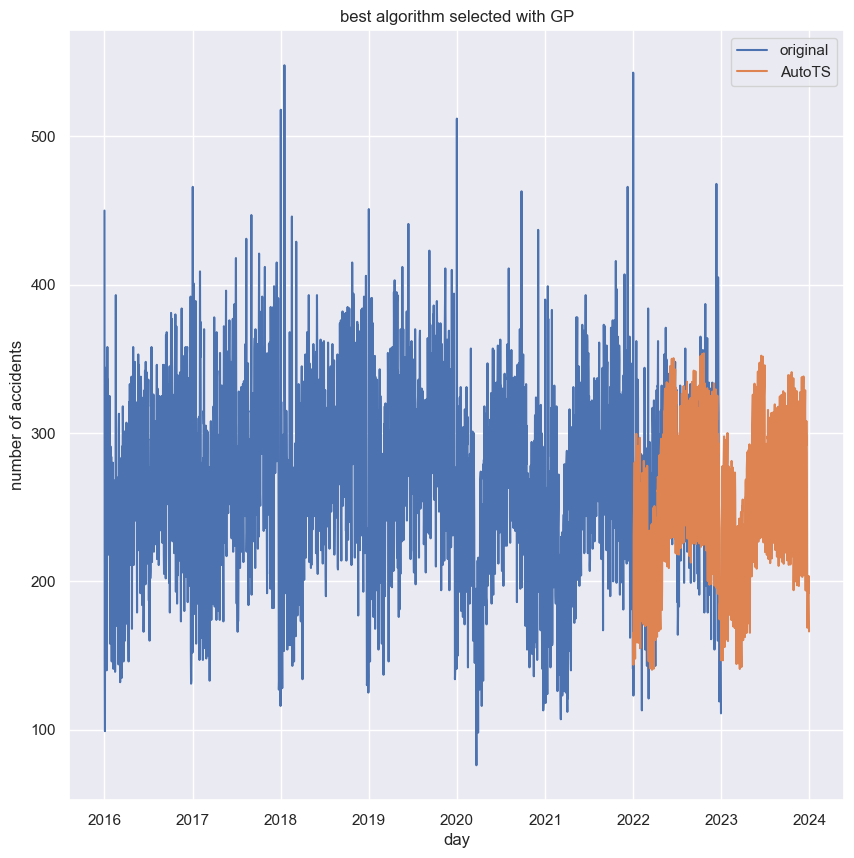

In [126]:
# add results to daily_predict_df
daily_predict_df['AutoTS'] = [np.nan] * len(daily_count_train) + list(forecast['predicted'])

# plot the result
daily_predict_df[['original', 'AutoTS']].plot()
plt.title("best algorithm selected with GP")
plt.xlabel("day")
plt.ylabel("number of accidents")

In [309]:
monthly_predict_df.tail(12 + months_to_predict)  # show results of all algorithms applied on monthly granularity data

original      Prophet        arima          svr      xgboost  \
ds                                                                         
2022-01-01    7786.0  7836.411899  7785.547311  7787.000389  8168.548340   
2022-02-01    6607.0  6646.530231  7449.659953  7598.269273  6989.591797   
2022-03-01    7750.0  6846.582430  6466.735567  7705.767363  7447.875977   
2022-04-01    7987.0  7696.363430  6804.632012  8593.956560  7813.187988   
2022-05-01    9359.0  8468.021480  8001.727477  8770.790714  8981.783203   
2022-06-01    8962.0  8607.446181  9280.877467  8874.999864  9161.391602   
2022-07-01    8101.0  8058.389200  9128.477762  8935.885223  8540.833008   
2022-08-01    8636.0  8322.032839  8726.260720  8948.031802  8897.983398   
2022-09-01    8476.0  8512.148701  8769.950640  8954.668597  8967.149414   
2022-10-01    8798.0  9113.436894  8315.671897  8889.665411  9497.236328   
2022-11-01    7936.0  8265.940863  8840.757801  8715.999849  8475.584961   
2022-12-01    7479.0  7593.229104  8342.894039  8408.677653  8143.119141   
2023-01-01       NaN  7449.575591  8032.274952  7787.000389  8168.548340   
2023-02-01       NaN  6256.150497  7490.529189  7598.269273  6989.591797   
2023-03-01       NaN  6712.341159  6391.263836  7705.767363  7447.875977   
2023-04-01       NaN  7778.479215  8082.234014  8593.956560  7813.187988   
2023-05-01       NaN  8269.166093  8834.269432  8770.790714  8981.783203   
2023-06-01       NaN  8316.818072  9403.563350  8874.999864  9161.391602   
2023-07-01       NaN  7749.418640  8463.843697  8935.885223  8540.833008   
2023-08-01       NaN  7948.404339  8347.768376  8948.031802  8897.983398   
2023-09-01       NaN  8280.045116  8720.182490  8954.668597  8967.149414   
2023-10-01       NaN  9124.274181  8824.095956  8889.665411  9497.236328   
2023-11-01       NaN  8294.161079  8316.773308  8715.999849  8475.584961   
2023-12-01       NaN  7279.427698  8067.838726  8408.677653  8143.119141   

               catboost          rnn         lstm  random forest + GA  \
ds                                                                      
2022-01-01  8098.436552  8899.449265  6969.103243              7561.5   
2022-02-01  6989.528911  8928.488608  6943.648377              7561.5   
2022-03-01  7303.085679  8902.216503  6899.397139              7561.5   
2022-04-01  7948.747170  8760.294884  6843.271287              7561.5   
2022-05-01  8977.357214  8645.969109  6817.007803              8843.0   
2022-06-01  9127.197634  8525.457855  6845.341164              8843.0   
2022-07-01  8606.611362  8391.413001  6903.840782              8843.0   
2022-08-01  8947.191384  8356.057081  6943.169454              8843.0   
2022-09-01  8971.107381  8390.292878  6989.501612              8843.0   
2022-10-01  9354.696706  8557.350653  7039.136857              8843.0   
2022-11-01  8539.760655  8674.909242  7103.604106              8843.0   
2022-12-01  8159.440253  8787.566644  7124.930616              8347.5   
2023-01-01  8098.436552  8899.449502  7126.440609              7561.5   
2023-02-01  6989.528911  8992.113344  7249.585522              7561.5   
2023-03-01  7303.085679  9014.002750  6858.584221              7561.5   
2023-04-01  7948.747170  8879.514052  7401.703639              7561.5   
2023-05-01  8977.357214  8923.042713  7702.788551              8843.0   
2023-06-01  9127.197634  8896.306212  7333.319561              8843.0   
2023-07-01  8606.611362  8895.116643  7102.377215              8843.0   
2023-08-01  8947.191384  8804.869261  7182.074724              8843.0   
2023-09-01  8971.107381  8846.700258  6998.830085              8843.0   
2023-10-01  9354.696706  8773.192361  7004.902772              8843.0   
2023-11-01  8539.760655  8877.902841  7798.322385              8843.0   
2023-12-01  8159.440253  8781.154164  6892.858521              8347.5   

            random forest + randomized  random forest + grid     MLP + GA  \
ds                                                         

In [308]:
from sklearn.metrics import mean_squared_error

target_values = monthly_predict_df.tail(12 + months_to_predict).head(12)['original'].values
rmse_results = {}

for col in monthly_predict_df.columns:
    if col != 'original':
        # Get the predicted values for the current model
        predicted_values = monthly_predict_df.tail(12 + months_to_predict).head(12)[col].values

        # Calculate the mean squared error
        mse = mean_squared_error(target_values, predicted_values)

        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(mse)

        # Store the RMSE value in the dictionary
        rmse_results[col] = rmse
        
# Convert the dictionary to a DataFrame for easier visualization
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.sort_values(by='RMSE')

RMSE
Prophet                      423.024382
xgboost                      439.764379
catboost                     442.825536
AutoTS                       553.096415
random forest + GA           560.173950
svr                          592.392846
GNN                          627.532244
random forest + randomized   637.544190
random forest + grid         653.392482
MLP + randomized             739.299241
arima                        848.847931
MLP + GA                     860.169164
rnn                          989.105137
MLP + grid                  1163.500209
lstm                        1419.349984

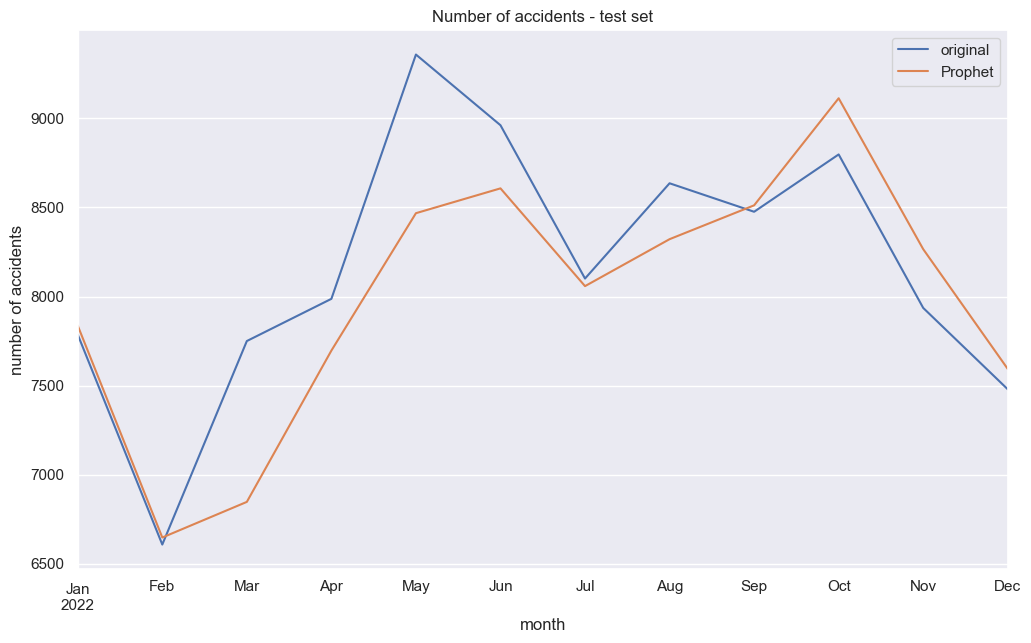

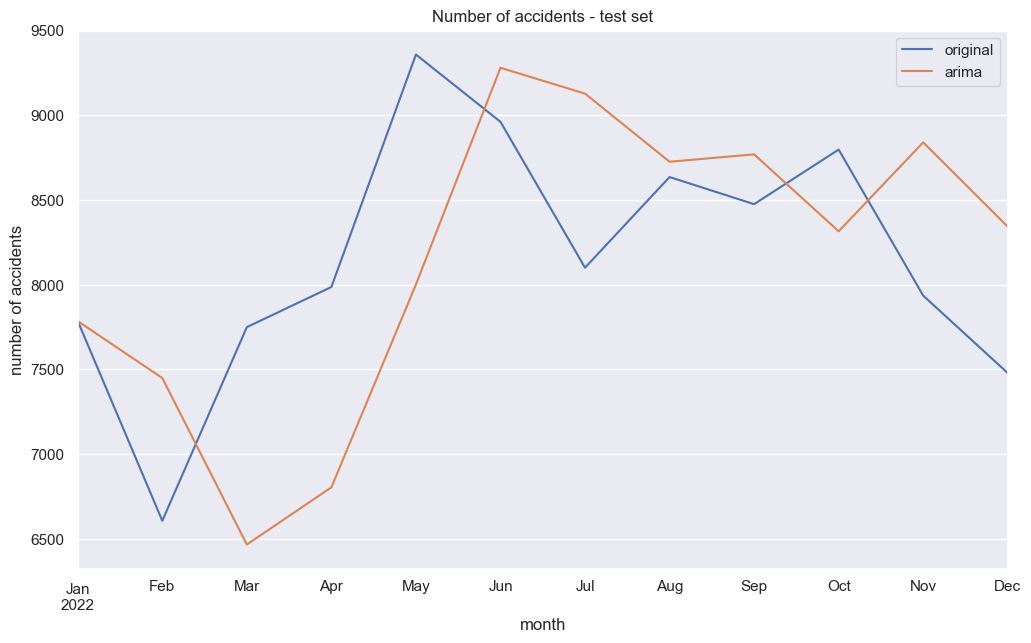

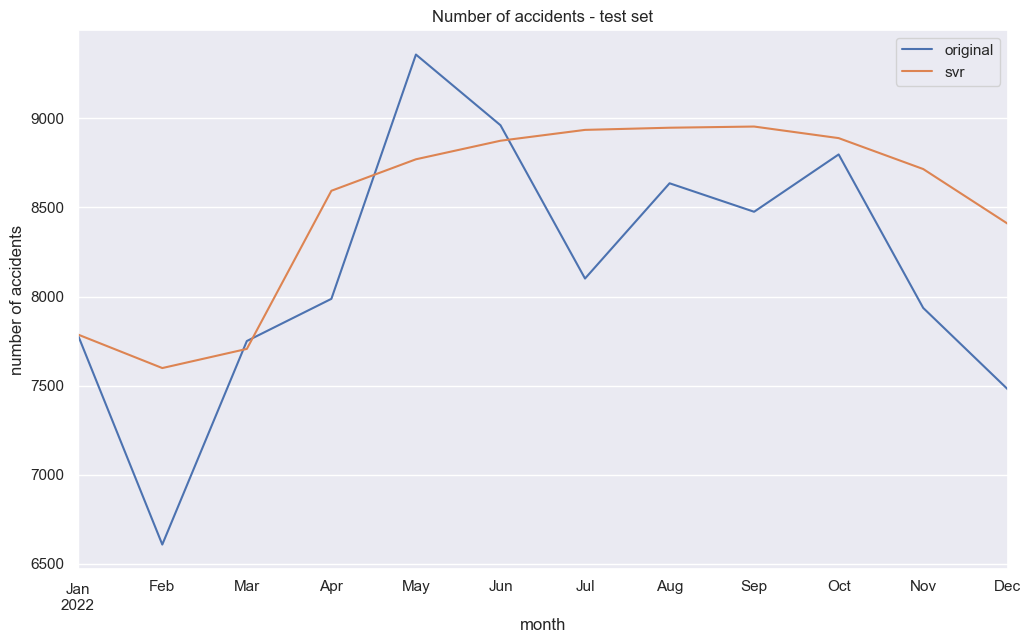

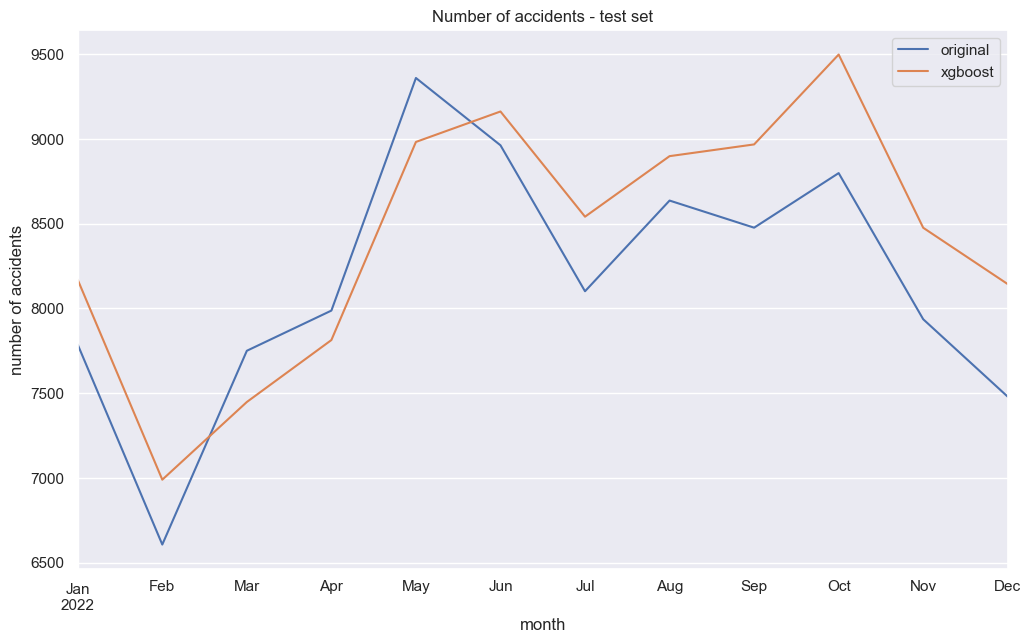

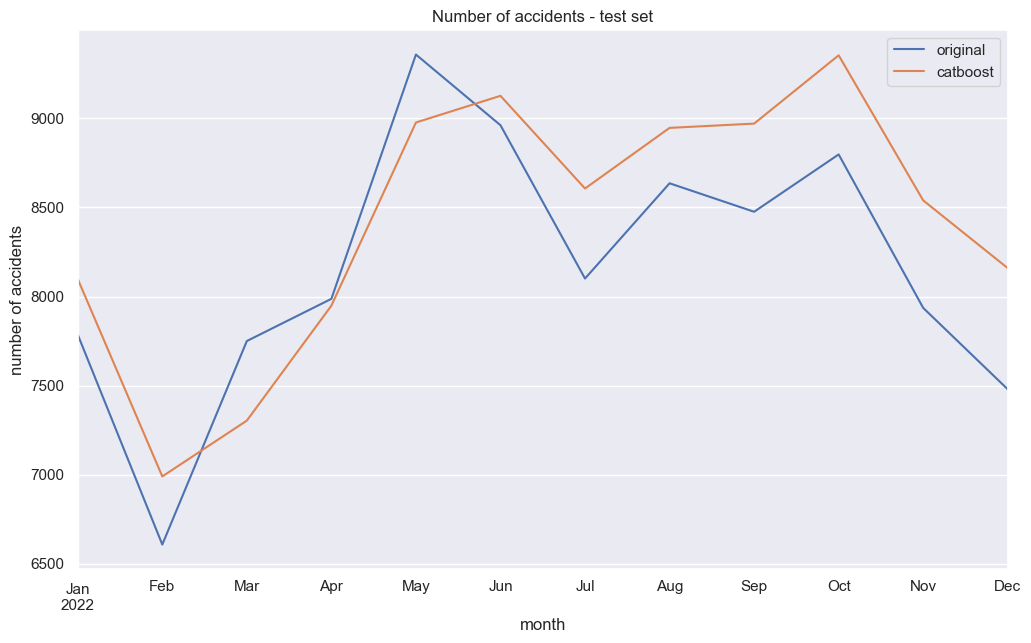

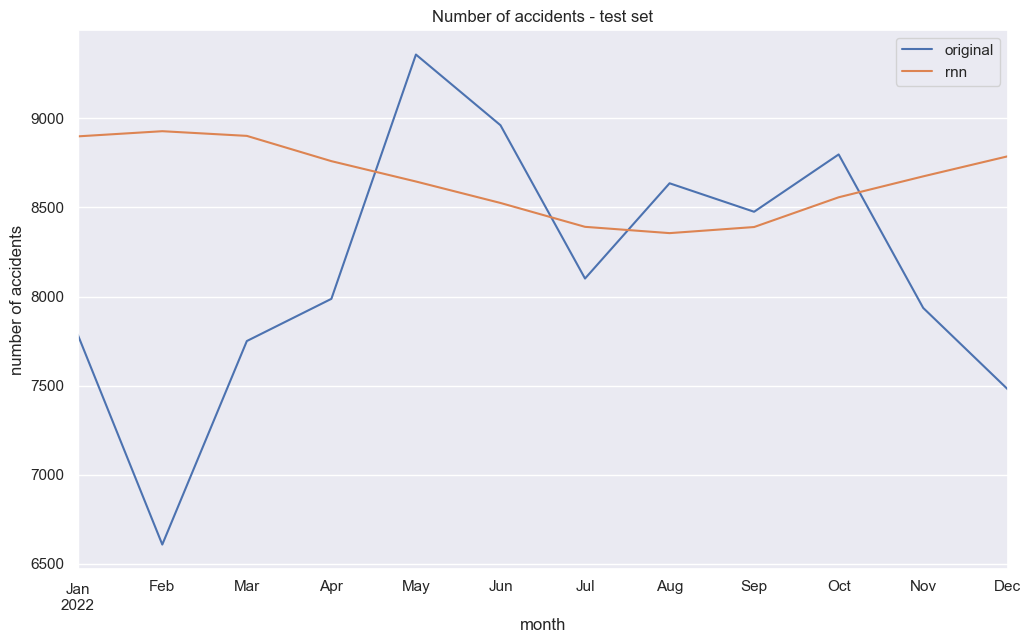

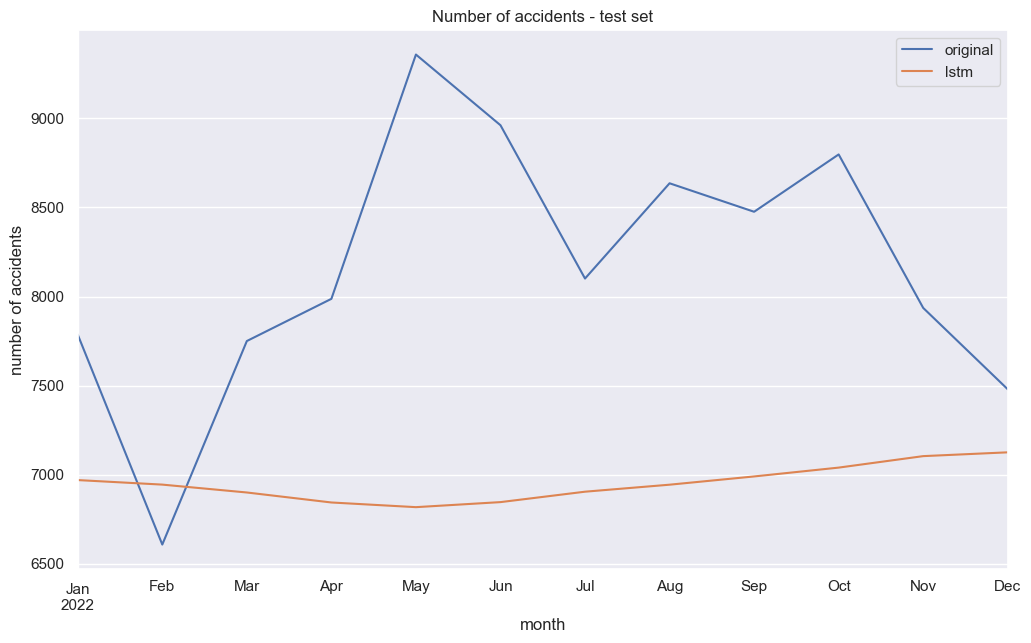

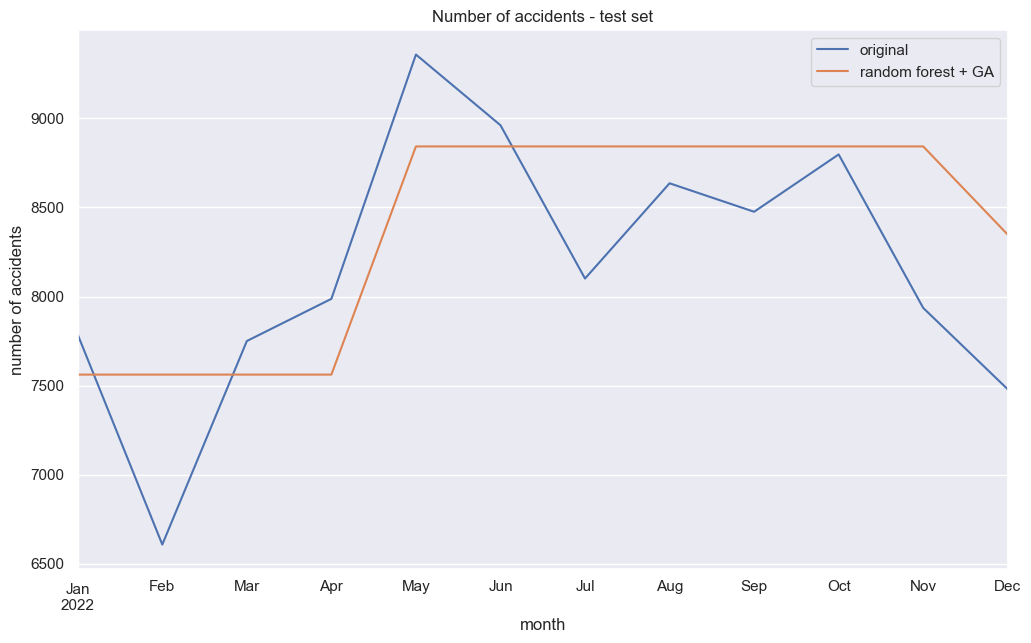

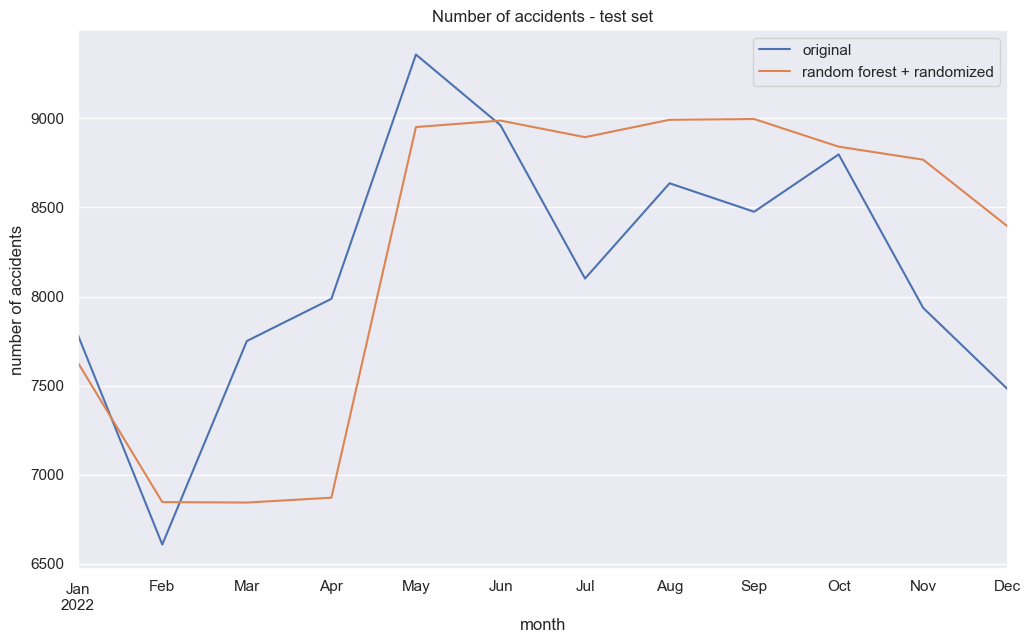

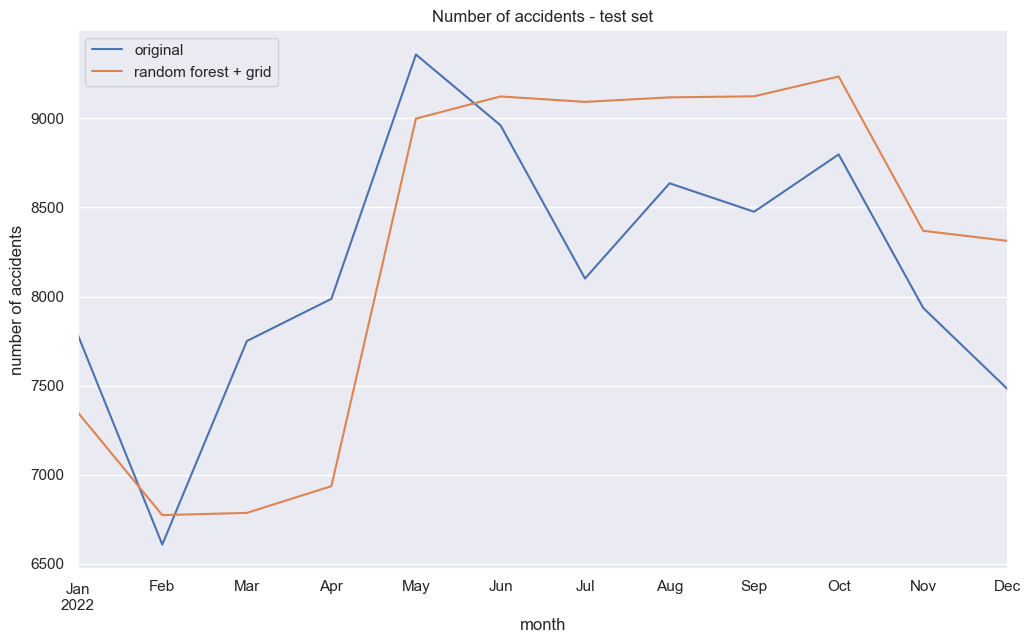

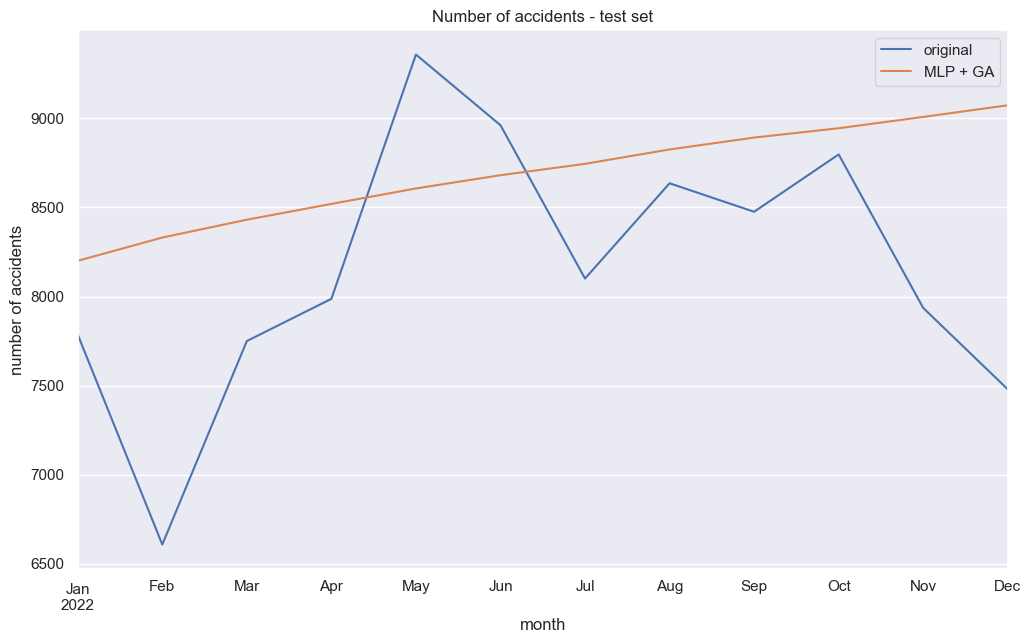

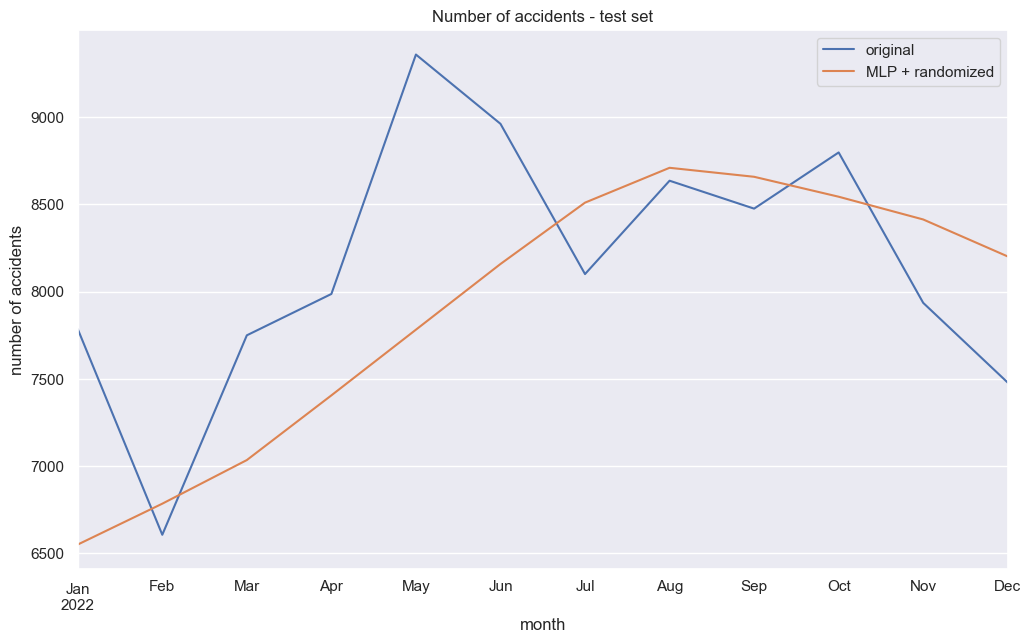

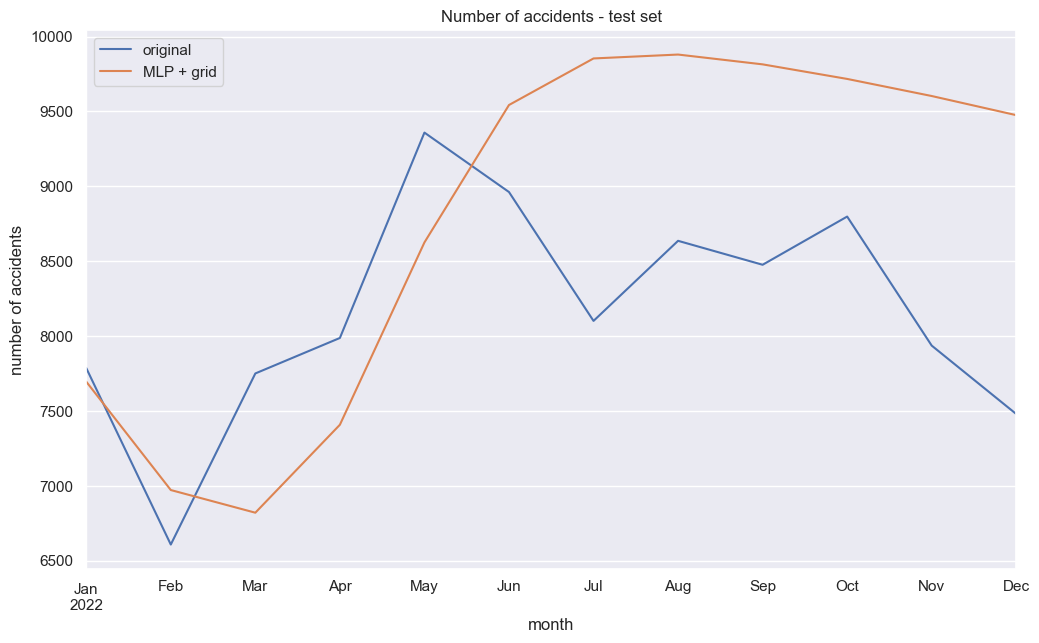

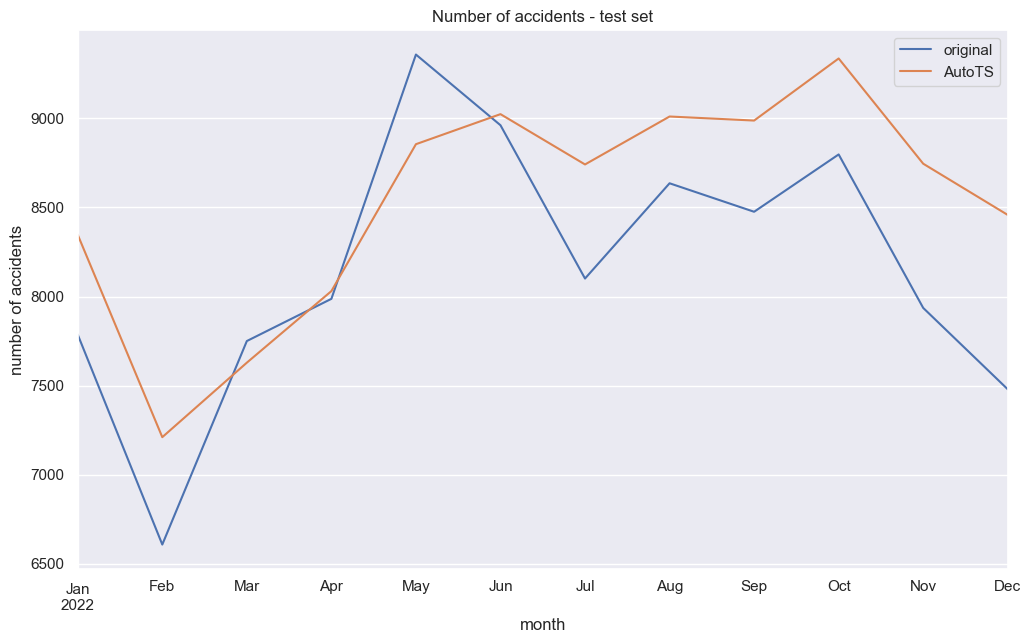

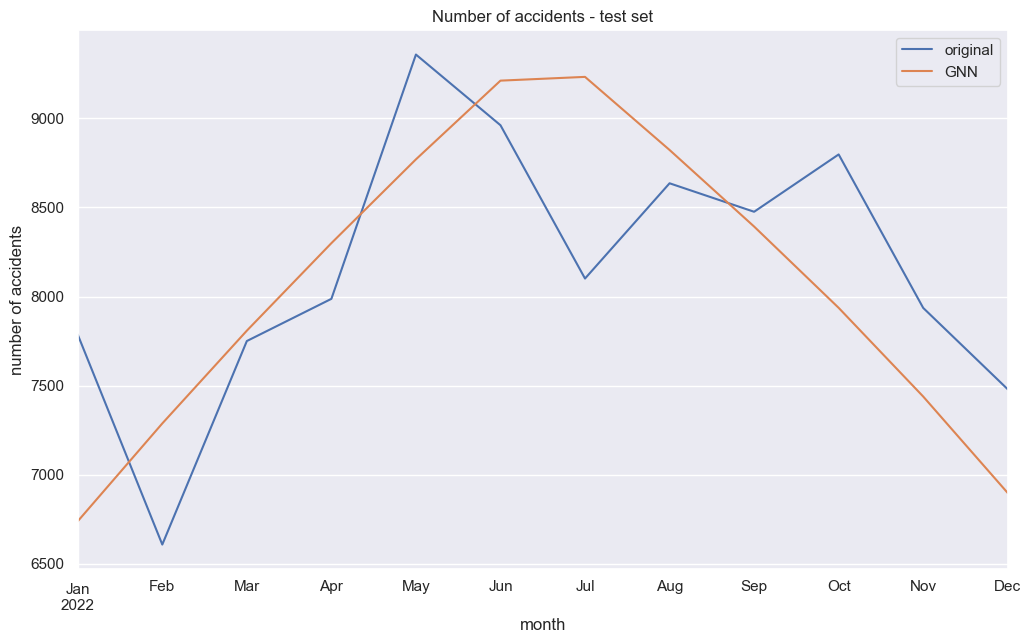

In [314]:
for col in monthly_predict_df.columns:
    if col != 'original':
        plt.rcParams['figure.figsize'] = [12, 7]
        monthly_predict_df[['original', col]].tail(12 + months_to_predict).head(12).plot()
        plt.title("Number of accidents - test set")
        plt.xlabel("month")
        plt.ylabel("number of accidents")
        plt.show()